In [2]:
0

In [6]:
import os
import SimpleITK as sitk
import numpy as np
import pandas as pd
import medpy

def dice_coefficient_per_label(y_true, y_pred, label):
    # Flatten the arrays and extract the label
    y_true = (y_true == label).astype(int)
    y_pred = (y_pred == label).astype(int)
    
    # Calculate intersection
    intersection = np.sum(y_true * y_pred)
    
    # Calculate Dice score
    dice = 2.0 * intersection / (np.sum(y_true) + np.sum(y_pred))
    
    return dice if np.sum(y_true) + np.sum(y_pred) > 0 else np.nan  # Return NaN if both are empty

# Directories
ref_dir = "/mnt/largedrive3/mhamghalam/fd/labelsTs_r01"  # reference directory
pred_dir = "/mnt/largedrive3/mhamghalam/fd/phase4_nnv2"  # prediction directory

# List all files in reference and prediction folders that end with '.nii.gz'
ref_files = sorted([f for f in os.listdir(ref_dir) if f.endswith('.nii.gz')])
pred_files = sorted([f for f in os.listdir(pred_dir) if f.endswith('.nii.gz')])

# Initialize a list for storing results
results = []

# Labels of interest
labels = {
    1: "Liver",
    2: "Tumor",
    3: "Vessels",
    4: "Cyst"
}

for ref_file, pred_file in zip(ref_files, pred_files):
    # Ensure the file names match
    if ref_file == pred_file:
        ref_path = os.path.join(ref_dir, ref_file)
        pred_path = os.path.join(pred_dir, pred_file)
        
        # Load reference and prediction images
        ref_img = sitk.ReadImage(ref_path)
        pred_img = sitk.ReadImage(pred_path)
        
        # Convert images to numpy arrays
        ref_array = sitk.GetArrayFromImage(ref_img)
        pred_array = sitk.GetArrayFromImage(pred_img)
        
        # Get voxel spacing
        voxel_spacing = ref_img.GetSpacing()
        
        # Calculate DSC for each label
        dsc_scores = {}
        for label, label_name in labels.items():
            dsc_scores[label_name] = dice_coefficient_per_label(ref_array, pred_array, label)
        
        # Save result in a dictionary
        result = {
            'Name': ref_file,
            'Voxel Spacing': voxel_spacing
        }
        result.update(dsc_scores)
        results.append(result)

# Convert results to a pandas DataFrame
df_results = pd.DataFrame(results)

# Save the DataFrame to a CSV file
df_results.to_csv('dsc_results_per_label.csv', index=False)

# Display the first few rows of the DataFrame
print(df_results.head())


/tmp/ipykernel_3476065/858071573.py:15: RuntimeWarning: invalid value encountered in scalar divide
  dice = 2.0 * intersection / (np.sum(y_true) + np.sum(y_pred))


                             Name  \
0    RIA_17-010A_000_312_2.nii.gz   
1  RIA_17-010A_000_332_101.nii.gz   
2    RIA_17-010A_000_354_2.nii.gz   
3    RIA_17-010A_000_389_2.nii.gz   
4    RIA_17-010A_000_390_2.nii.gz   

                                   Voxel Spacing     Liver     Tumor  \
0  (0.9765620231628418, 0.9765620231628418, 5.0)  0.991424       NaN   
1  (0.9765620231628418, 0.9765620231628418, 1.5)  0.984875  0.000000   
2  (0.9082030057907104, 0.9082030057907104, 5.0)  0.988306       NaN   
3  (0.8300780057907104, 0.8300780057907104, 5.0)  0.990540  0.111888   
4  (0.9765620231628418, 0.9765620231628418, 5.0)  0.989132       NaN   

    Vessels  Cyst  
0  0.927596   NaN  
1  0.888804   NaN  
2  0.853195   NaN  
3  0.931834   NaN  
4  0.867705   NaN  


In [158]:
#    Copyright 2020 Division of Medical Image Computing, German Cancer Research Center (DKFZ), Heidelberg, Germany
#
#    Licensed under the Apache License, Version 2.0 (the "License");
#    you may not use this file except in compliance with the License.
#    You may obtain a copy of the License at
#
#        http://www.apache.org/licenses/LICENSE-2.0
#
#    Unless required by applicable law or agreed to in writing, software
#    distributed under the License is distributed on an "AS IS" BASIS,
#    WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#    See the License for the specific language governing permissions and
#    limitations under the License.


import numpy as np
from medpy.metric.binary import __surface_distances


def normalized_surface_dice(a: np.ndarray, b: np.ndarray, threshold: float = 1.0, spacing: tuple = None, connectivity=1, label_value = 2):
    """
    This implementation differs from the official surface dice implementation! These two are not comparable!!!!!

    The normalized surface dice is symmetric, so it should not matter whether a or b is the reference image

    This implementation natively supports 2D and 3D images. Whether other dimensions are supported depends on the
    __surface_distances implementation in medpy

    :param a: image 1, must have the same shape as b
    :param b: image 2, must have the same shape as a
    :param threshold: distances below this threshold will be counted as true positives. Threshold is in mm, not voxels!
    (if spacing = (1, 1(, 1)) then one voxel=1mm so the threshold is effectively in voxels)
    must be a tuple of len dimension(a)
    :param spacing: how many mm is one voxel in reality? Can be left at None, we then assume an isotropic spacing of 1mm
    :param connectivity: see scipy.ndimage.generate_binary_structure for more information. I suggest you leave that
    one alone
    :return:
    """
    a = (a == label_value).astype(int)  # Tumor label (2)
    b = (b == label_value).astype(int)
    
    # Check if there are any positive pixels in ground truth or prediction
    true_sum = np.sum(a.flatten())
    pred_sum = np.sum(b.flatten())
    
    if true_sum == 0 and pred_sum == 0:
        return 1.0  # No tumor in both, perfect match
    elif true_sum == 0 or pred_sum == 0:
        return 0.0  # One has no tumor, the other does
    
    a_to_b = __surface_distances(a, b, spacing, connectivity)
    b_to_a = __surface_distances(b, a, spacing, connectivity)

    numel_a = len(a_to_b)
    numel_b = len(b_to_a)

    tp_a = np.sum(a_to_b <= threshold) / numel_a
    tp_b = np.sum(b_to_a <= threshold) / numel_b

    fp = np.sum(a_to_b > threshold) / numel_a
    fn = np.sum(b_to_a > threshold) / numel_b

    dc = (tp_a + tp_b) / (tp_a + tp_b + fp + fn + 1e-8)  # 1e-8 just so that we don't get div by 0
    return dc


In [2]:
import os
import SimpleITK as sitk
import numpy as np
import pandas as pd

# Function to calculate Dice Similarity Coefficient (DSC) for the tumor label (2)
def dice_coefficient(y_true, y_pred, label_value=2):
    """
    Calculate Dice Similarity Coefficient (DSC) for the tumor label (2).
    Handles cases where there is no tumor in the ground truth or prediction.
    """
    y_true = (y_true == label_value).flatten()  # Tumor label (2)
    y_pred = (y_pred == label_value).flatten()
    
    # Check if there are any positive pixels in ground truth or prediction
    true_sum = np.sum(y_true)
    pred_sum = np.sum(y_pred)
    
    if true_sum == 0 and pred_sum == 0:
        return 1.0  # No tumor in both, perfect match
    elif true_sum == 0 or pred_sum == 0:
        return 0.0  # One has no tumor, the other does
    
    # Calculate intersection and Dice score
    intersection = np.sum(y_true & y_pred)
    return 2.0 * intersection / (true_sum + pred_sum)

# Directories for the predictions
pred_dirs = [
    "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f0",
    "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f1",
    "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f2",
    "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f3",
    "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f4"
]

# Collect list of .nii.gz files from the first folder (assuming all folders have matching filenames)
ref_files = sorted([f for f in os.listdir(pred_dirs[0]) if f.endswith(".nii.gz")])

# Initialize a list to store results
results = []

# Loop over all reference files
for ref_file in ref_files:
    
    # Load all prediction images for the current file
    pred_arrays = []
    for pred_dir in pred_dirs:
        pred_file = os.path.join(pred_dir, ref_file)
        pred_img = sitk.ReadImage(pred_file)
        pred_array = sitk.GetArrayFromImage(pred_img)
        pred_arrays.append(pred_array)
    
    num_preds = len(pred_arrays)
    pairwise_dscs = []
    
    # Calculate pairwise DSC for tumor label (2)
    for i in range(num_preds):
        for j in range(i + 1, num_preds):
            dsc = dice_coefficient(pred_arrays[i], pred_arrays[j], label_value=2)  # Tumor label
            pairwise_dscs.append(dsc)
    
    # Calculate the mean pairwise DSC for the current image
    avg_pairwise_dsc = np.mean(pairwise_dscs)
    
    # Store results in the list
    results.append({
        'Name': ref_file,
        'Avg Pairwise Tumor DSC': avg_pairwise_dsc
    })

# Convert the results into a Pandas DataFrame
df_results = pd.DataFrame(results)

# Save the results to a CSV file
df_results.to_csv('pairwise_tumor_dsc_results.csv', index=False)

# Display the first few rows of the dataframe
print(df_results.head())


                             Name  Avg Pairwise Tumor DSC
0    RIA_17-010A_000_312_2.nii.gz                1.000000
1  RIA_17-010A_000_332_101.nii.gz                0.127919
2    RIA_17-010A_000_354_2.nii.gz                1.000000
3    RIA_17-010A_000_389_2.nii.gz                0.465375
4    RIA_17-010A_000_390_2.nii.gz                1.000000


In [39]:
# original AURC reults from fd paper 
import os
import SimpleITK as sitk
import numpy as np
import pandas as pd

phase = 0
# Function to calculate Dice Similarity Coefficient (DSC) for a given label (e.g., tumor)
def dice_coefficient(y_true, y_pred, label_value=2):
    """
    Calculate Dice Similarity Coefficient (DSC) for the given label.
    Handles cases where there is no tumor in the ground truth or prediction.
    """
    y_true = (y_true == label_value).flatten()  # Focus on the label (2 = tumor)
    y_pred = (y_pred == label_value).flatten()
    
    true_sum = np.sum(y_true)
    pred_sum = np.sum(y_pred)
    
    if true_sum == 0 and pred_sum == 0:
        return 1.0  # No tumor in both, perfect match
    elif true_sum == 0 or pred_sum == 0:
        return 0.0  # One has no tumor, the other does
    
    intersection = np.sum(y_true & y_pred)
    return 2.0 * intersection / (true_sum + pred_sum)

# Directories for the predictions and ensembeled prediction
if phase == 0:
    # Directories for the predictions and ensembeled prediction
    pred_dirs = [
        "/mnt/largedrive3/mhamghalam/segPaper/phase0_f0",
        "/mnt/largedrive3/mhamghalam/segPaper/phase0_f1",
        "/mnt/largedrive3/mhamghalam/segPaper/phase0_f2",
        "/mnt/largedrive3/mhamghalam/segPaper/phase0_f3",
        "/mnt/largedrive3/mhamghalam/segPaper/phase0_f4"
    ]

    ensembled_dir = "/mnt/largedrive3/mhamghalam/segPaper/phase0_5folds"

else:
# Directories for the predictions and ensembled prediction
    pred_dirs = [
        "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f0",
        "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f1",
        "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f2",
        "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f3",
        "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f4"
    ]

    ensembled_dir = "/mnt/largedrive3/mhamghalam/segPaper/ensembled_phase4"
   
ref_dir =   '/mnt/largedrive3/mhamghalam/segPaper/labelsTs_r01'
# Collect list of .nii.gz files from the reference folder
ref_files = sorted([f for f in os.listdir(ref_dir) if f.endswith(".nii.gz")])
ensembled_files = sorted([f for f in os.listdir(ensembled_dir) if f.endswith(".nii.gz")])

# Initialize lists to store results
risk_values = []
confidence_values = []
results = []
dscs_ensembled = []

# Loop over all reference files and ensembeled files
for ref_file, ensembled_file in zip(ref_files, ensembled_files):
    
    # Load reference image
    ref_path = os.path.join(ref_dir, ref_file)
    ref_img = sitk.ReadImage(ref_path)
    ref_array = sitk.GetArrayFromImage(ref_img)
    
    # Load ensembled prediction image
    ensembled_path = os.path.join(ensembled_dir, ensembled_file)
    ensembled_img = sitk.ReadImage(ensembled_path)
    ensembled_array = sitk.GetArrayFromImage(ensembled_img)
    
    # Calculate DSC for the ensembled prediction (focus on tumor label 2)
    dsc_ensembled = dice_coefficient(ref_array, ensembled_array, label_value=2)
    
    # Calculate risk as (1 - DSC)
    risk_value = 1.0 - dsc_ensembled
    risk_values.append(risk_value)
    dscs_ensembled.append(dsc_ensembled)

    # Load all predictions for the current file
    pred_arrays = []
    for pred_dir in pred_dirs:
        pred_file = os.path.join(pred_dir, ref_file)
        pred_img = sitk.ReadImage(pred_file)
        pred_array = sitk.GetArrayFromImage(pred_img)
        pred_arrays.append(pred_array)
    
    # Calculate pairwise DSC for the tumor label (2)
    num_preds = len(pred_arrays)
    pairwise_dscs = []
    
    for i in range(num_preds):
        for j in range(i + 1, num_preds):
            dsc = dice_coefficient(pred_arrays[i], pred_arrays[j], label_value=2)
            pairwise_dscs.append(dsc)
    
    # Calculate the mean pairwise DSC for the current image (confidence score)
    avg_pairwise_dsc = np.mean(pairwise_dscs)
    confidence_values.append(avg_pairwise_dsc)

    # Store results in the list for tracking
    results.append({
        'Name': ref_file,
        'Risk (1 - DSC)': risk_value,
        'Confidence (Pairwise DSC)': avg_pairwise_dsc,
        'DICE pred Ensemble':dsc_ensembled
    })

# Convert the results into a pandas DataFrame
df_results = pd.DataFrame(results)

# Save the results to a CSV file
df_results.to_csv('risk_confidence_results.csv', index=False)

# Save risk values and confidence values as numpy arrays
risk_array = np.array(risk_values)
confidence_array = np.array(confidence_values)

# Save the numpy arrays to files
np.save('risk_values.npy', risk_array)
np.save('confidence_values.npy', confidence_array)

# Display the first few rows of the results dataframe
print(df_results.head())


                             Name  Risk (1 - DSC)  Confidence (Pairwise DSC)  \
0    RIA_17-010A_000_312_2.nii.gz         0.00000                   1.000000   
1  RIA_17-010A_000_332_101.nii.gz         0.95541                   0.072916   
2    RIA_17-010A_000_354_2.nii.gz         0.00000                   1.000000   
3    RIA_17-010A_000_389_2.nii.gz         1.00000                   0.100000   
4    RIA_17-010A_000_390_2.nii.gz         0.00000                   1.000000   

   DICE pred Ensemble  
0             1.00000  
1             0.04459  
2             1.00000  
3             0.00000  
4             1.00000  


In [40]:
# For cohort analysis
# Define cohort mapping function
def map_to_cohort(filename):
    if "010A_000" in filename:
        return "Recurrence Prediction-MSK"
    elif "010C_000" in filename:
        return "Response Analysis-MSK"
    elif "010_002" in filename:
        return "Contrast Injection Timing-MDA"
    elif "mcrc" in filename:
        return "TCIA-MSK"
    else:
        return "Contrast Injection Timing-MSK"

# Add cohort column to DataFrame
df_results['Cohort'] = df_results['Name'].apply(map_to_cohort)

# Verify added column
# print(df_results[['Name', 'Cohort']].head())

# Save updated results
# df_results.to_csv('risk_confidence_scores.csv', index=False)

# Calculate AURC for each cohort
aurc_per_cohort = {}
spearmanr_per_cohort = {}
pearsonr_per_cohort = {}

for cohort_name, group in df_results.groupby("Cohort"):
    cohort_risks = group["Risk (1 - DSC)"].values
    cohort_confids = group["Confidence (Pairwise DSC)"].values
    
    # Skip cohorts with no data
    if len(cohort_risks) == 0:
        print(f"Skipping empty cohort: {cohort_name}")
        continue
    
    # Calculate AURC
    stats = StatsCache(confids=cohort_confids, risks=cohort_risks)
    aurc = get_metric_function("aurc")(stats)
    aurc_per_cohort[cohort_name] = aurc*100
    spearmanr_per_cohort[cohort_name] = scipy.stats.spearmanr(cohort_confids, cohort_risks).statistic
    pearsonr_per_cohort[cohort_name] = scipy.stats.pearsonr(cohort_confids, cohort_risks).statistic

    # print('spearmanr',scipy.stats.spearmanr(confids, risks).statistic)
    # print('pearsonr',scipy.stats.pearsonr(confids, risks).statistic)

# Display results
print("\nAURC Values by Cohort:")
for cohort, aurc in aurc_per_cohort.items():
    print(f"{cohort}: {aurc:.4f}")
    
for cohort, aurc in spearmanr_per_cohort.items():
    print(f"{cohort}: {aurc:.4f}")

for cohort, aurc in pearsonr_per_cohort.items():
    print(f"{cohort}: {aurc:.4f}")



AURC Values by Cohort:
Contrast Injection Timing-MDA: 8.3886
Contrast Injection Timing-MSK: 8.7332
Recurrence Prediction-MSK: 31.3999
Response Analysis-MSK: 6.3795
TCIA-MSK: 27.5562
Contrast Injection Timing-MDA: -0.7857
Contrast Injection Timing-MSK: -0.6791
Recurrence Prediction-MSK: -0.5556
Response Analysis-MSK: -0.9301
TCIA-MSK: -0.4804
Contrast Injection Timing-MDA: -0.9140
Contrast Injection Timing-MSK: -0.5486
Recurrence Prediction-MSK: -0.5903
Response Analysis-MSK: -0.5806
TCIA-MSK: -0.5755


In [34]:
import numpy as np
from segmentation_failures.evaluation.failure_detection.metrics import StatsCache, get_metric_function
import scipy 

# compute risk scores and confidence scores as you like
risks = risk_array
confids = confidence_array

stats = StatsCache(confids=confids, risks=risks)
aurc_values = get_metric_function("aurc")(stats)
print('aurc', aurc_values*100)
print('spearmanr',scipy.stats.spearmanr(confids, risks))
print('pearsonr',scipy.stats.pearsonr(confids, risks))



aurc 16.677903026438468
spearmanr SignificanceResult(statistic=-0.7056490325407486, pvalue=5.706262211304227e-15)
pearsonr PearsonRResult(statistic=-0.6605288880010691, pvalue=1.0516214822053433e-12)


In [18]:
print(get_metric_function("aurc")(stats))

0.16677903026438468


In [30]:
import matplotlib.pyplot as plt

aurc = aurc_values 
color_accept = "#147012"
optimal_confid = -risks
stats_cache = StatsCache(confids, risks)
opt_stats = StatsCache(optimal_confid, risks)

opt_coverages, opt_selrisks, _ = opt_stats.rc_curve_stats
coverages, selrisks, _ = stats_cache.rc_curve_stats
aurc = get_metric_function("aurc")(stats_cache)
# plot the risks
fig = plt.figure(figsize=(3, 3))
# set aspect ratio to 1:1
fig.patch.set_facecolor("none")
# plt.gca().set_aspect('equal', adjustable='box')
plt.plot(coverages, selrisks, color=color_accept)
# add a shaded region below the curve
plt.fill_between(
    coverages, 0, selrisks, color=color_accept, alpha=0.2, label=f"AURC = {aurc:0.3f}"
)
plt.plot(opt_coverages, opt_selrisks, linestyle=":", color="black", label="optimal")
plt.xlabel(r"Coverage (% samples > $\tau$)")
plt.ylabel(r"Avg. risk (of samples > $\tau$)")
plt.legend()

# from scipy import stats
print(scipy.stats.spearmanr(confids, risks).statistic)



TypeError: bad operand type for unary -: 'list'

In [121]:
#  AURC reults by decreasing confidence for average tumor colume --> not great improvement

import os
import SimpleITK as sitk
import numpy as np
import pandas as pd
from scipy import ndimage
from segmentation_failures.evaluation.failure_detection.metrics import StatsCache, get_metric_function

# Function to calculate Dice Similarity Coefficient (DSC) for a given label (e.g., tumor)
def dice_coefficient(y_true, y_pred, label_value=2):
    y_true = (y_true == label_value).flatten()
    y_pred = (y_pred == label_value).flatten()
    
    true_sum = np.sum(y_true)
    pred_sum = np.sum(y_pred)
    
    if true_sum == 0 and pred_sum == 0:
        return 1.0  # No tumor in both, perfect match
    elif true_sum == 0 or pred_sum == 0:
        return 0.0  # One has no tumor, the other does
    
    intersection = np.sum(y_true & y_pred)
    return 2.0 * intersection / (true_sum + pred_sum)

# Function to detect tumors and calculate their real-world volumes
def detect_tumors_with_volumes(y_pred, voxel_spacing):
    """
    Detect tumors and calculate their volumes (in mm³) based on voxel spacing.
    Return:
    - total_tumor_volume: Total volume of tumors in mm³.
    - average_tumor_volume: Average tumor volume across all tumors in mm³.
    """
    tumor_voxels = (y_pred == 2).astype(np.int32)
    labeled_image, num_tumors = ndimage.label(tumor_voxels)
    
    tumor_volumes = []
    
    for tumor_label in range(1, num_tumors + 1):
        tumor_size_voxels = np.sum(labeled_image == tumor_label)
        tumor_volume = tumor_size_voxels * np.prod(voxel_spacing)  # Convert to mm³
        tumor_volumes.append(tumor_volume)
    
    total_tumor_volume = np.sum(tumor_volumes)
    average_tumor_volume = np.mean(tumor_volumes) if len(tumor_volumes) > 0 else 0.0
    
    return total_tumor_volume, average_tumor_volume

# Directories for the predictions and ensembled prediction
pred_dirs = [
    "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f0",
    "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f1",
    "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f2",
    "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f3",
    "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f4"
]

ensembled_dir = "/mnt/largedrive3/mhamghalam/segPaper/ensembled_phase4"
ref_dir =   '/mnt/largedrive3/mhamghalam/segPaper/labelsTs_r01'

# Collect list of .nii.gz files from the reference folder
ref_files = sorted([f for f in os.listdir(ref_dir) if f.endswith(".nii.gz")])
ensembled_files = sorted([f for f in os.listdir(ensembled_dir) if f.endswith(".nii.gz")])

# Initialize lists to store results
risk_values = []
confidence_values = []
results = []

# Loop over all reference files and ensembled files
for ref_file, ensembled_file in zip(ref_files, ensembled_files):
    
    # Load reference image
    ref_path = os.path.join(ref_dir, ref_file)
    ref_img = sitk.ReadImage(ref_path)
    ref_array = sitk.GetArrayFromImage(ref_img)
    
    # Load ensembled prediction image
    ensembled_path = os.path.join(ensembled_dir, ensembled_file)
    ensembled_img = sitk.ReadImage(ensembled_path)
    ensembled_array = sitk.GetArrayFromImage(ensembled_img)
    
    # Get voxel spacing from image header (real-world dimensions in mm)
    voxel_spacing = ref_img.GetSpacing()

    # Calculate DSC for the ensembled prediction (focus on tumor label 2)
    dsc_ensembled = dice_coefficient(ref_array, ensembled_array, label_value=2)
    
    # Calculate risk as (1 - DSC)
    risk_value = 1.0 - dsc_ensembled
    risk_values.append(risk_value)

    # Load all predictions for the current file
    pred_arrays = []
    tumor_volumes = []  # To store the tumor volume for each prediction
    avg_tumor_volumes = []  # To store the average tumor volumes for each prediction
    
    for pred_dir in pred_dirs:
        pred_file = os.path.join(pred_dir, ref_file)
        pred_img = sitk.ReadImage(pred_file)
        pred_array = sitk.GetArrayFromImage(pred_img)
        pred_arrays.append(pred_array)
        
        # Calculate tumor volumes
        total_tumor_volume, avg_tumor_volume = detect_tumors_with_volumes(pred_array, voxel_spacing)
        tumor_volumes.append(total_tumor_volume)
        avg_tumor_volumes.append(avg_tumor_volume)
    
    # Calculate pairwise DSC for the tumor label (2), weighted by average tumor volume
    num_preds = len(pred_arrays)
    weighted_pairwise_dscs = []
    avg_tumor_volume_global = np.mean(avg_tumor_volumes)  # Average tumor volume for weighting
    
    for i in range(num_preds):
        for j in range(i + 1, num_preds):
            dsc = dice_coefficient(pred_arrays[i], pred_arrays[j], label_value=2)
            avg_vol_ij = (avg_tumor_volumes[i] + avg_tumor_volumes[j]) / 2  # Average tumor volume for this pair
            
            # Penalize confidence if the average volume is small
            penalization_factor = avg_vol_ij / avg_tumor_volume_global if avg_tumor_volume_global > 0 else 1.0
            
            # Weight by tumor volume (lower weight for small average volumes)
            weighted_pairwise_dscs.append(dsc * penalization_factor)
    
    # Calculate the mean weighted pairwise DSC for the current image (confidence score)
    if len(weighted_pairwise_dscs) > 0:
        avg_weighted_pairwise_dsc = np.mean(weighted_pairwise_dscs)
    else:
        avg_weighted_pairwise_dsc = 0.0
    
    confidence_values.append(avg_weighted_pairwise_dsc)

    # Store results in the list for tracking
    results.append({
        'Name': ref_file,
        'Risk (1 - DSC)': risk_value,
        'Confidence (Weighted Pairwise DSC)': avg_weighted_pairwise_dsc
    })

# Convert the results into a pandas DataFrame
df_results = pd.DataFrame(results)

# Save the results to a CSV file
df_results.to_csv('risk_confidence_results_with_continuous_penalization.csv', index=False)

# Save risk values and confidence values as numpy arrays
risk_array = np.array(risk_values)
confidence_array = np.array(confidence_values)

# Save the numpy arrays to files
np.save('risk_values.npy', risk_array)
np.save('confidence_values.npy', confidence_array)

# Display the first few rows of the results dataframe
print(df_results.head())

# -----------------------------------
# Using StatsCache and get_metric_function to calculate AURC
# -----------------------------------

# Initialize StatsCache with confidence and risk arrays
stats = StatsCache(confids=confidence_array, risks=risk_array)

# Calculate AURC (Area Under the Risk-Coverage Curve)
aurc_values = get_metric_function("aurc")(stats)
print(f"AURC Values: {aurc_values*100}")


                             Name  Risk (1 - DSC)  \
0    RIA_17-010A_000_312_2.nii.gz        0.000000   
1  RIA_17-010A_000_332_101.nii.gz        0.801368   
2    RIA_17-010A_000_354_2.nii.gz        0.000000   
3    RIA_17-010A_000_389_2.nii.gz        0.890909   
4    RIA_17-010A_000_390_2.nii.gz        0.000000   

   Confidence (Weighted Pairwise DSC)  
0                            1.000000  
1                            0.225621  
2                            1.000000  
3                            0.444700  
4                            1.000000  
AURC Values: 16.648113057459724


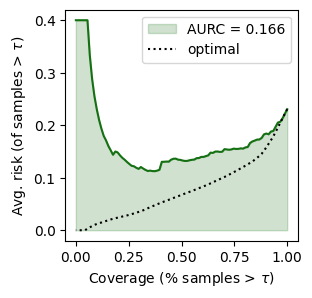

In [125]:
aurc = aurc_values 
color_accept = "#147012"
optimal_confid = -risks
stats_cache = StatsCache(confids, risks)
opt_stats = StatsCache(optimal_confid, risks)

opt_coverages, opt_selrisks, _ = opt_stats.rc_curve_stats
coverages, selrisks, _ = stats_cache.rc_curve_stats
aurc = get_metric_function("aurc")(stats_cache)
# plot the risks
fig = plt.figure(figsize=(3, 3))
# set aspect ratio to 1:1
fig.patch.set_facecolor("none")
# plt.gca().set_aspect('equal', adjustable='box')
plt.plot(coverages, selrisks, color=color_accept)
# add a shaded region below the curve
plt.fill_between(
    coverages, 0, selrisks, color=color_accept, alpha=0.2, label=f"AURC = {aurc:0.3f}"
)
plt.plot(opt_coverages, opt_selrisks, linestyle=":", color="black", label="optimal")
plt.xlabel(r"Coverage (% samples > $\tau$)")
plt.ylabel(r"Avg. risk (of samples > $\tau$)")
plt.legend()

In [129]:
# decrese conf for image bigger than 5mm --> 13
# decrese conf for image bigger/smaller 5mm-->15
# import os
import SimpleITK as sitk
import numpy as np
import pandas as pd
from scipy import ndimage
from segmentation_failures.evaluation.failure_detection.metrics import StatsCache, get_metric_function

# Function to calculate Dice Similarity Coefficient (DSC) for a given label (e.g., tumor)
def dice_coefficient(y_true, y_pred, label_value=2):
    y_true = (y_true == label_value).flatten()
    y_pred = (y_pred == label_value).flatten()
    
    true_sum = np.sum(y_true)
    pred_sum = np.sum(y_pred)
    
    if true_sum == 0 and pred_sum == 0:
        return 1.0  # No tumor in both, perfect match
    elif true_sum == 0 or pred_sum == 0:
        return 0.0  # One has no tumor, the other does
    
    intersection = np.sum(y_true & y_pred)
    return 2.0 * intersection / (true_sum + pred_sum)

# Function to detect tumors and calculate their real-world volumes
def detect_tumors_with_volumes(y_pred, voxel_spacing):
    """
    Detect tumors and calculate their volumes (in mm³) based on voxel spacing.
    Return:
    - total_tumor_volume: Total volume of tumors in mm³.
    - average_tumor_volume: Average tumor volume across all tumors in mm³.
    """
    tumor_voxels = (y_pred == 2).astype(np.int32)
    labeled_image, num_tumors = ndimage.label(tumor_voxels)
    
    tumor_volumes = []
    
    for tumor_label in range(1, num_tumors + 1):
        tumor_size_voxels = np.sum(labeled_image == tumor_label)
        tumor_volume = tumor_size_voxels * np.prod(voxel_spacing)  # Convert to mm³
        tumor_volumes.append(tumor_volume)
    
    total_tumor_volume = np.sum(tumor_volumes)
    average_tumor_volume = np.mean(tumor_volumes) if len(tumor_volumes) > 0 else 0.0
    
    return total_tumor_volume, average_tumor_volume

# Directories for the predictions and ensembled prediction
pred_dirs = [
    "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f0",
    "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f1",
    "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f2",
    "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f3",
    "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f4"
]

ensembled_dir = "/mnt/largedrive3/mhamghalam/segPaper/ensembled_phase4"

ref_dir =   '/mnt/largedrive3/mhamghalam/segPaper/labelsTs_r01'

# Collect list of .nii.gz files from the reference folder
ref_files = sorted([f for f in os.listdir(ref_dir) if f.endswith(".nii.gz")])
ensembled_files = sorted([f for f in os.listdir(ensembled_dir) if f.endswith(".nii.gz")])

# Initialize lists to store results
risk_values = []
confidence_values = []
results = []

# Function to calculate penalty based on z-axis spacing
def penalize_based_on_voxel_spacing(voxel_spacing, ideal_z_spacing=5.0):
    """
    Penalize confidence based on the deviation from ideal z-axis spacing (5 mm).
    A higher z-axis resolution (smaller spacing) should receive less penalty.
    """
    z_spacing = voxel_spacing[2]  # Z-axis spacing (third element)
    
    # Calculate the penalty factor based on the deviation from the ideal z-spacing (5 mm)
    if z_spacing < ideal_z_spacing:
        penalty_factor = 1.0  # No penalty if resolution is fine
    else:
        penalty_factor = ideal_z_spacing / z_spacing  # Penalize lower resolution
    # print(voxel_spacing)
    return penalty_factor

# Loop over all reference files and ensembled files
for ref_file, ensembled_file in zip(ref_files, ensembled_files):
    
    # Load reference image
    ref_path = os.path.join(ref_dir, ref_file)
    ref_img = sitk.ReadImage(ref_path)
    ref_array = sitk.GetArrayFromImage(ref_img)
    
    # Load ensembled prediction image
    ensembled_path = os.path.join(ensembled_dir, ensembled_file)
    ensembled_img = sitk.ReadImage(ensembled_path)
    ensembled_array = sitk.GetArrayFromImage(ensembled_img)
    
    # Get voxel spacing from image header (real-world dimensions in mm)
    voxel_spacing = ref_img.GetSpacing()

    # Calculate DSC for the ensembled prediction (focus on tumor label 2)
    dsc_ensembled = dice_coefficient(ref_array, ensembled_array, label_value=2)
    
    # Calculate risk as (1 - DSC)
    risk_value = 1.0 - dsc_ensembled
    risk_values.append(risk_value)

    # Load all predictions for the current file
    pred_arrays = []
    tumor_volumes = []  # To store the tumor volume for each prediction
    avg_tumor_volumes = []  # To store the average tumor volumes for each prediction
    
    for pred_dir in pred_dirs:
        pred_file = os.path.join(pred_dir, ref_file)
        pred_img = sitk.ReadImage(pred_file)
        pred_array = sitk.GetArrayFromImage(pred_img)
        pred_arrays.append(pred_array)
        
        # Calculate tumor volumes
        # total_tumor_volume, avg_tumor_volume = detect_tumors_with_volumes(pred_array, voxel_spacing)
        # tumor_volumes.append(total_tumor_volume)
        # avg_tumor_volumes.append(avg_tumor_volume)
    
    # Calculate pairwise DSC for the tumor label (2), weighted by average tumor volume
    num_preds = len(pred_arrays)
    weighted_pairwise_dscs = []
    # avg_tumor_volume_global = np.mean(avg_tumor_volumes)  # Average tumor volume for weighting
    
    for i in range(num_preds):
        for j in range(i + 1, num_preds):
            dsc = dice_coefficient(pred_arrays[i], pred_arrays[j], label_value=2)
            # avg_vol_ij = (avg_tumor_volumes[i] + avg_tumor_volumes[j]) / 2  # Average tumor volume for this pair
            
            # Penalize confidence if the average volume is small
            # penalization_factor = avg_vol_ij / avg_tumor_volume_global if avg_tumor_volume_global > 0 else 1.0
            
            # Weight by tumor volume (lower weight for small average volumes)
            weighted_pairwise_dscs.append(dsc * 1)
    
    # Calculate the mean weighted pairwise DSC for the current image (confidence score)
    if len(weighted_pairwise_dscs) > 0:
        avg_weighted_pairwise_dsc = np.mean(weighted_pairwise_dscs)
    else:
        avg_weighted_pairwise_dsc = 0.0
    
    # Apply penalty for low-resolution images based on z-axis spacing
    penalty_factor = penalize_based_on_voxel_spacing(voxel_spacing)
    penalized_confidence = avg_weighted_pairwise_dsc * penalty_factor
    confidence_values.append(penalized_confidence)

    # Store results in the list for tracking
    results.append({
        'Name': ref_file,
        'Risk (1 - DSC)': risk_value,
        'Confidence (Penalized Weighted Pairwise DSC)': penalized_confidence
    })

# Convert the results into a pandas DataFrame
combined_combined_combined_df_results = pd.DataFrame(results)

# Save the results to a CSV file
df_results.to_csv('risk_confidence_results_with_voxel_spacing_penalization.csv', index=False)

# Save risk values and confidence values as numpy arrays
risk_array = np.array(risk_values)
confidence_array = np.array(confidence_values)

# Save the numpy arrays to files
np.save('risk_values_voxel_spacing_penalized.npy', risk_array)
np.save('confidence_values_voxel_spacing_penalized.npy', confidence_array)

# Display the first few rows of the results dataframe
print(df_results.head())

# -----------------------------------
# Using StatsCache and get_metric_function to calculate AURC
# -----------------------------------

# Initialize StatsCache with confidence and risk arrays
stats = StatsCache(confids=confidence_array, risks=risk_array)

# Calculate AURC (Area Under the Risk-Coverage Curve)
aurc_values = get_metric_function("aurc")(stats)
print(f"AURC Values: {aurc_values}")


                             Name  Risk (1 - DSC)  \
0    RIA_17-010A_000_312_2.nii.gz        0.000000   
1  RIA_17-010A_000_332_101.nii.gz        0.801368   
2    RIA_17-010A_000_354_2.nii.gz        0.000000   
3    RIA_17-010A_000_389_2.nii.gz        0.890909   
4    RIA_17-010A_000_390_2.nii.gz        0.000000   

   Confidence (Penalized Weighted Pairwise DSC)  
0                                      1.000000  
1                                      0.127919  
2                                      1.000000  
3                                      0.465375  
4                                      1.000000  
AURC Values: 0.1333681450290143


In [1]:
# Calculate AURC
risks = np.array(risk_values)
confids = np.array(confidence_values)
# confids = -risks
stats = StatsCache(confids=confids, risks=risks)
coverages, selrisks, _ = stats.rc_curve_stats

aurc_values = get_metric_function("aurc")(stats)
print("AURC Values:", aurc_values)

NameError: name 'np' is not defined

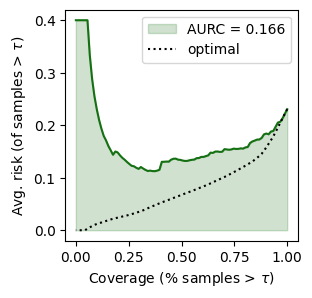

In [127]:
aurc = aurc_values 
color_accept = "#147012"
optimal_confid = -risks
stats_cache = StatsCache(confids, risks)
opt_stats = StatsCache(optimal_confid, risks)

opt_coverages, opt_selrisks, _ = opt_stats.rc_curve_stats
coverages, selrisks, _ = stats_cache.rc_curve_stats
aurc = get_metric_function("aurc")(stats_cache)
# plot the risks
fig = plt.figure(figsize=(3, 3))
# set aspect ratio to 1:1
fig.patch.set_facecolor("none")
# plt.gca().set_aspect('equal', adjustable='box')
plt.plot(coverages, selrisks, color=color_accept)
# add a shaded region below the curve
plt.fill_between(
    coverages, 0, selrisks, color=color_accept, alpha=0.2, label=f"AURC = {aurc:0.3f}"
)
plt.plot(opt_coverages, opt_selrisks, linestyle=":", color="black", label="optimal")
plt.xlabel(r"Coverage (% samples > $\tau$)")
plt.ylabel(r"Avg. risk (of samples > $\tau$)")
plt.legend()

In [131]:
import numpy as np
from segmentation_failures.evaluation.failure_detection.metrics import StatsCache, get_metric_function
import scipy 

# compute risk scores and confidence scores as you like
risks = risk_array
confids = confidence_array

stats = StatsCache(confids=confids, risks=risks)
aurc_values = get_metric_function("aurc")(stats)
print('aurc', aurc_values*100)
print('spearmanr',scipy.stats.spearmanr(confids, risks).statistic)
print('pearsonr',scipy.stats.pearsonr(confids, risks).statistic)

aurc 13.336814502901431
spearmanr -0.7561245619624084
pearsonr -0.6995197970564245


In [137]:
import numpy as np
import SimpleITK as sitk
import pandas as pd
from scipy import ndimage
from segmentation_failures.evaluation.failure_detection.metrics import StatsCache, get_metric_function
phase = 0
# Function to calculate Dice Similarity Coefficient (DSC) for a given label (e.g., tumor)
def dice_coefficient(y_true, y_pred, label_value=2):
    y_true = (y_true == label_value).flatten()
    y_pred = (y_pred == label_value).flatten()
    
    true_sum = np.sum(y_true)
    pred_sum = np.sum(y_pred)
    
    if true_sum == 0 and pred_sum == 0:
        return 1.0  # No tumor in both, perfect match
    elif true_sum == 0 or pred_sum == 0:
        return 0.0  # One has no tumor, the other does
    
    intersection = np.sum(y_true & y_pred)
    return 2.0 * intersection / (true_sum + pred_sum)

# Function to detect tumors and calculate their real-world volumes
def detect_tumors_with_volumes(y_pred, voxel_spacing):
    tumor_voxels = (y_pred == 2).astype(np.int32)
    labeled_image, num_tumors = ndimage.label(tumor_voxels)
    
    tumor_volumes = []
    
    for tumor_label in range(1, num_tumors + 1):
        tumor_size_voxels = np.sum(labeled_image == tumor_label)
        tumor_volume = tumor_size_voxels * np.prod(voxel_spacing)  # Convert to mm³
        tumor_volumes.append(tumor_volume)
    
    total_tumor_volume = np.sum(tumor_volumes)
    average_tumor_volume = np.mean(tumor_volumes) if len(tumor_volumes) > 0 else 0.0
    
    return total_tumor_volume, average_tumor_volume

# Function to calculate the scaling factor based on tumor size
# def scale_confidence_based_on_tumor_size(tumor_volume, threshold_size=3385.0):
#     """
#     Scale confidence based on tumor volume.
#     If the tumor volume is larger than the threshold, increase confidence.
#     Otherwise, decrease confidence.
#     """
#     if tumor_volume > threshold_size:
#         return 1.2  # Confidence boost for large tumors
#     else:
#         return 0.8  # Confidence penalty for small tumors

# Function to penalize confidence based on z-axis spacing
# def penalize_based_on_voxel_spacing(voxel_spacing, ideal_z_spacing=5.0):
#     """
#     Penalize confidence based on deviation from ideal z-axis spacing (5 mm).
#     """
#     z_spacing = voxel_spacing[2]  # Z-axis spacing (third element)
    
#     if z_spacing == ideal_z_spacing:
#         return 1.0  # No penalty if ideal z-spacing
#     else:
#         # Penalize based on how far the z-spacing deviates from 5 mm
#         penalty_factor = 1 / (1 + abs(z_spacing - ideal_z_spacing))  # Inverse penalty
#         return penalty_factor

def penalize_based_on_voxel_spacing(voxel_spacing, ideal_z_spacing=5.0):
    """
    Penalize confidence based on the deviation from ideal z-axis spacing (5 mm).
    A higher z-axis resolution (smaller spacing) should receive less penalty.
    """
    z_spacing = voxel_spacing[2]  # Z-axis spacing (third element)
    
    # Calculate the penalty factor based on the deviation from the ideal z-spacing (5 mm)
    if z_spacing < ideal_z_spacing:
        penalty_factor = 1.0  # No penalty if resolution is fine
    else:
        penalty_factor = ideal_z_spacing / z_spacing  # Penalize lower resolution
    # print(voxel_spacing)
    return penalty_factor
# def scale_confidence_based_on_tumor_size(tumor_volume, threshold_size=3385.0):
#     """
#     Scale confidence based on tumor volume.
#     If the tumor volume is larger than the threshold, increase confidence.
#     Otherwise, decrease confidence.
#     Confidence is capped between 0 and 1.
#     """
#     if tumor_volume > threshold_size:
#         return min(1.0, 0.8 + (tumor_volume / threshold_size) * 0.2)  # Confidence boost for large tumors, capped at 1.0
#     else:
#         return max(0.0, 0.8 * (tumor_volume / threshold_size))  # Confidence penalty for small tumors, no negative scores

# def scale_factor_based_on_tumor_size(tumor_volume, lower_bound=510.0, upper_bound=3385.0):
def scale_factor_based_on_tumor_size(tumor_volume, lower_bound=510.0, upper_bound=3385.0):

    """
    Return a scaling factor between 0 and 1 based on tumor volume.
    Small tumors get a smaller factor, large tumors get a larger factor.
    """
    if tumor_volume <= lower_bound:
        return 0.8  # Minimum scaling for small tumors
    elif tumor_volume >= upper_bound:
        return 1.0  # Maximum scaling for large tumors
    else:
        # Smooth scaling between 0 and 1 for tumor sizes between lower_bound and upper_bound
        return (tumor_volume - lower_bound) / (upper_bound - lower_bound)





# Directories for the predictions and ensembled prediction
# pred_dirs = [
#     "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f0",
#     "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f1",
#     "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f2",
#     "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f3",
#     "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f4"
# ]

# ensembled_dir = "/mnt/largedrive3/mhamghalam/segPaper/ensembled_phase4"
if phase == 0:
    # Directories for the predictions and ensembeled prediction
    pred_dirs = [
        "/mnt/largedrive3/mhamghalam/segPaper/phase0_f0",
        "/mnt/largedrive3/mhamghalam/segPaper/phase0_f1",
        "/mnt/largedrive3/mhamghalam/segPaper/phase0_f2",
        "/mnt/largedrive3/mhamghalam/segPaper/phase0_f3",
        "/mnt/largedrive3/mhamghalam/segPaper/phase0_f4"
    ]

    ensembled_dir = "/mnt/largedrive3/mhamghalam/segPaper/phase0_5folds"

else:
# Directories for the predictions and ensembled prediction
    pred_dirs = [
        "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f0",
        "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f1",
        "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f2",
        "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f3",
        "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f4"
    ]

    ensembled_dir = "/mnt/largedrive3/mhamghalam/segPaper/ensembled_phase4"
  
ref_dir =   '/mnt/largedrive3/mhamghalam/segPaper/labelsTs_r01'

# Collect list of .nii.gz files from the reference folder
ref_files = sorted([f for f in os.listdir(ref_dir) if f.endswith(".nii.gz")])
ensembled_files = sorted([f for f in os.listdir(ensembled_dir) if f.endswith(".nii.gz")])

# Initialize lists to store results
risk_values = []
confidence_values = []
results = []

# Loop over all reference files and ensembled files
for ref_file, ensembled_file in zip(ref_files, ensembled_files):
    
    # Load reference image
    ref_path = os.path.join(ref_dir, ref_file)
    ref_img = sitk.ReadImage(ref_path)
    ref_array = sitk.GetArrayFromImage(ref_img)
    
    # Load ensembled prediction image
    ensembled_path = os.path.join(ensembled_dir, ensembled_file)
    ensembled_img = sitk.ReadImage(ensembled_path)
    ensembled_array = sitk.GetArrayFromImage(ensembled_img)
    
    # Get voxel spacing from image header (real-world dimensions in mm)
    voxel_spacing = ref_img.GetSpacing()

    # Calculate DSC for the ensembled prediction (focus on tumor label 2)
    dsc_ensembled = dice_coefficient(ref_array, ensembled_array, label_value=2)
    
    # Calculate risk as (1 - DSC)
    risk_value = 1.0 - dsc_ensembled
    risk_values.append(risk_value)

    # Load all predictions for the current file
    pred_arrays = []
    tumor_volumes = []  # To store the tumor volume for each prediction
    avg_tumor_volumes = []  # To store the average tumor volumes for each prediction
    
    for pred_dir in pred_dirs:
        pred_file = os.path.join(pred_dir, ref_file)
        pred_img = sitk.ReadImage(pred_file)
        pred_array = sitk.GetArrayFromImage(pred_img)
        pred_arrays.append(pred_array)
        
        # Calculate tumor volumes
        total_tumor_volume, avg_tumor_volume = detect_tumors_with_volumes(pred_array, voxel_spacing)
        tumor_volumes.append(total_tumor_volume)
        avg_tumor_volumes.append(avg_tumor_volume)
    
    # Calculate pairwise DSC for the tumor label (2), weighted by average tumor volume
    num_preds = len(pred_arrays)
    weighted_pairwise_dscs = []
    avg_tumor_volume_global = np.mean(avg_tumor_volumes)  # Average tumor volume for weighting
    
    for i in range(num_preds):
        for j in range(i + 1, num_preds):
            dsc = dice_coefficient(pred_arrays[i], pred_arrays[j], label_value=2)
            avg_vol_ij = (avg_tumor_volumes[i] + avg_tumor_volumes[j]) / 2  # Average tumor volume for this pair
            
            # Penalize confidence if the average volume is small
            penalization_factor = avg_vol_ij / avg_tumor_volume_global if avg_tumor_volume_global > 0 else 1.0
            
            # Weight by tumor volume (lower weight for small average volumes)
            weighted_pairwise_dscs.append(dsc * penalization_factor)
    
    # Calculate the mean weighted pairwise DSC for the current image (confidence score)
    if len(weighted_pairwise_dscs) > 0:
        avg_weighted_pairwise_dsc = np.mean(weighted_pairwise_dscs)
    else:
        avg_weighted_pairwise_dsc = 0.0
    
    # Scale confidence based on tumor size (penalize small tumors)
    tumor_size_scaling_factor = scale_factor_based_on_tumor_size(np.mean(tumor_volumes))
    
    # Apply penalty for low-resolution images based on z-axis spacing
    voxel_spacing_penalty_factor = penalize_based_on_voxel_spacing(voxel_spacing)
    
    # Adjust confidence by tumor size scaling and voxel spacing penalty
    # voxel_spacing_penalty_factor = 1
    # tumor_size_scaling_factor = 1
    penalized_confidence_size = avg_weighted_pairwise_dsc * voxel_spacing_penalty_factor * 1
    no_penalized_confidence = avg_weighted_pairwise_dsc 

    penalized_confidence = avg_weighted_pairwise_dsc * tumor_size_scaling_factor * voxel_spacing_penalty_factor
    confidence_values.append(penalized_confidence)

    # Store results in the list for tracking
    results.append({
        'Name': ref_file,
        'Risk (1 - DSC)': risk_value,
        'Confidence (Penalized)': penalized_confidence,
        'Confidence (Penalized size)': penalized_confidence_size,
        'Confidence (No Penalized Weighted Pairwise DSC)': no_penalized_confidence,
    })

# Convert the results into a pandas DataFrame
df_results = pd.DataFrame(results)

# Save the results to a CSV file
df_results.to_csv('risk_confidence_scores.csv', index=False)

# Display results for review
print(df_results)


                              Name  Risk (1 - DSC)  Confidence (Penalized)  \
0     RIA_17-010A_000_312_2.nii.gz        0.000000                0.800000   
1   RIA_17-010A_000_332_101.nii.gz        0.955410                0.116803   
2     RIA_17-010A_000_354_2.nii.gz        0.000000                0.800000   
3     RIA_17-010A_000_389_2.nii.gz        1.000000                0.000000   
4     RIA_17-010A_000_390_2.nii.gz        0.000000                0.800000   
..                             ...             ...                     ...   
86                 mcrc_288.nii.gz        1.000000                0.533333   
87                 mcrc_296.nii.gz        0.151947                0.953139   
88                 mcrc_311.nii.gz        0.186054                0.942184   
89                 mcrc_317.nii.gz        0.307269                0.863312   
90                 mcrc_348.nii.gz        0.199558                0.926369   

    Confidence (Penalized size)  \
0                      1.000

In [136]:

stats = StatsCache(confids=df_results['Confidence (Penalized)'].values
, risks=df_results['Risk (1 - DSC)'].values
)
aurc = get_metric_function("aurc")(stats)
print(aurc*100)

10.312383608041593


In [110]:
# Define cohort mapping function
def map_to_cohort(filename):
    if "010A_000" in filename:
        return "Recurrence Prediction-MSK"
    elif "010C_000" in filename:
        return "Response Analysis-MSK"
    elif "010_002" in filename:
        return "Contrast Injection Timing-MDA"
    elif "mcrc" in filename:
        return "TCIA-MSK"
    else:
        return "Contrast Injection Timing-MSK"

# Add cohort column to DataFrame
df_results['Cohort'] = df_results['Name'].apply(map_to_cohort)

# Verify added column
# print(df_results[['Name', 'Cohort']].head())

# Save updated results
# df_results.to_csv('risk_confidence_scores.csv', index=False)

# Calculate AURC for each cohort
aurc_per_cohort = {}
spearmanr_per_cohort = {}
pearsonr_per_cohort = {}

for cohort_name, group in df_results.groupby("Cohort"):
    cohort_risks = group["Risk (1 - DSC)"].values
    # cohort_confids = group["Confidence (Penalized)"].values
    # cohort_confids = group["Confidence (Penalized size)"].values
    cohort_confids = group["Confidence (No Penalized Weighted Pairwise DSC)"].values


    #  'Confidence (Penalized)': penalized_confidence,
    #     'Confidence (Penalized size)': penalized_confidence_size,
    #     'Confidence (No Penalized Weighted Pairwise DSC)': no_penalized_confidence,
    
    # Skip cohorts with no data
    if len(cohort_risks) == 0:
        print(f"Skipping empty cohort: {cohort_name}")
        continue
    
    # Calculate AURC
    stats = StatsCache(confids=cohort_confids, risks=cohort_risks)
    aurc = get_metric_function("aurc")(stats)
    aurc_per_cohort[cohort_name] = aurc*100
    spearmanr_per_cohort[cohort_name] = scipy.stats.spearmanr(cohort_confids, cohort_risks).statistic
    pearsonr_per_cohort[cohort_name] = scipy.stats.pearsonr(cohort_confids, cohort_risks).statistic

    # print('spearmanr',scipy.stats.spearmanr(confids, risks).statistic)
    # print('pearsonr',scipy.stats.pearsonr(confids, risks).statistic)

# Display results
print("\nAURC Values by Cohort:")
for cohort, aurc in aurc_per_cohort.items():
    print(f"{cohort}: {aurc:.4f}")
    
for cohort, aurc1 in spearmanr_per_cohort.items():
    print(f"{cohort}: {aurc1:.4f}")

for cohort, aurc in pearsonr_per_cohort.items():
    print(f"{cohort}: {aurc:.4f}")



AURC Values by Cohort:
Contrast Injection Timing-MDA: 8.3886
Contrast Injection Timing-MSK: 8.5030
Recurrence Prediction-MSK: 31.3504
Response Analysis-MSK: 6.3795
TCIA-MSK: 27.5670
Contrast Injection Timing-MDA: -0.7857
Contrast Injection Timing-MSK: -0.7275
Recurrence Prediction-MSK: -0.5747
Response Analysis-MSK: -0.9301
TCIA-MSK: -0.4831
Contrast Injection Timing-MDA: -0.9216
Contrast Injection Timing-MSK: -0.5724
Recurrence Prediction-MSK: -0.5955
Response Analysis-MSK: -0.5669
TCIA-MSK: -0.5948


In [82]:
for cohort_name, group in df_results.groupby("Cohort"):
    print(group)

                                         Name  Risk (1 - DSC)  \
27  RIA_17-010_002_015_clinical_500_20.nii.gz        0.039427   
28  RIA_17-010_002_022_clinical_500_20.nii.gz        0.113329   
29  RIA_17-010_002_025_clinical_500_20.nii.gz        0.041885   
30  RIA_17-010_002_041_clinical_500_20.nii.gz        0.170234   
31  RIA_17-010_002_042_clinical_500_20.nii.gz        0.097441   
32  RIA_17-010_002_044_clinical_500_20.nii.gz        0.041642   
33  RIA_17-010_002_049_clinical_500_20.nii.gz        0.053043   
34  RIA_17-010_002_050_clinical_500_20.nii.gz        0.118353   
35  RIA_17-010_002_051_clinical_500_20.nii.gz        0.047345   
36  RIA_17-010_002_057_clinical_500_20.nii.gz        0.048756   
37  RIA_17-010_002_060_clinical_500_20.nii.gz        0.190988   
38  RIA_17-010_002_064_clinical_500_20.nii.gz        0.032760   
39  RIA_17-010_002_071_clinical_500_20.nii.gz        0.016262   
40  RIA_17-010_002_077_clinical_500_20.nii.gz        0.042816   
41  RIA_17-010_002_087_cl

In [77]:
spearmanr_per_cohort

{'Contrast Injection Timing-MDA': -0.9035714285714285,
 'Contrast Injection Timing-MSK': -0.8681318681318682,
 'Recurrence Prediction-MSK': -0.5127506643963614,
 'Response Analysis-MSK': -0.9440559440559443,
 'TCIA-MSK': -0.4916740940724875}

In [69]:
# Calculate AURC
risks = np.array(risk_values)
confids = np.array(confidence_values)
# confids = -risks
stats = StatsCache(confids=confids, risks=risks)
coverages, selrisks, _ = stats.rc_curve_stats

aurc_values = get_metric_function("aurc")(stats)
print("AURC Values:", aurc_values)

AURC Values: 0.10540867185052616


In [24]:
df_results

,Name,Risk (1 - DSC),Confidence (Pairwise DSC),DICE pred Ensemble,Cohort
0,RIA_17-010A_000_312_2.nii.gz,0.000000,1.000000,1.000000,Recurrence Prediction-MSK
1,RIA_17-010A_000_332_101.nii.gz,0.801368,0.127919,0.198632,Recurrence Prediction-MSK
2,RIA_17-010A_000_354_2.nii.gz,0.000000,1.000000,1.000000,Recurrence Prediction-MSK
3,RIA_17-010A_000_389_2.nii.gz,0.890909,0.465375,0.109091,Recurrence Prediction-MSK
4,RIA_17-010A_000_390_2.nii.gz,0.000000,1.000000,1.000000,Recurrence Prediction-MSK
...,...,...,...,...,...
86,mcrc_288.nii.gz,1.000000,1.000000,0.000000,TCIA-MSK
87,mcrc_296.nii.gz,0.147509,0.968415,0.852491,TCIA-MSK
88,mcrc_311.nii.gz,0.192416,0.955203,0.807584,TCIA-MSK
89,mcrc_317.nii.gz,0.318077,0.888525,0.681923,TCIA-MSK


In [45]:
# Calculate AURC for each cohort
aurc_per_cohort = {}
spearmanr_per_cohort = {}
pearsonr_per_cohort = {}

for cohort_name, group in df_results.groupby("Cohort"):
    cohort_risks = group["Risk (1 - DSC)"].values
    cohort_confids = group["Confidence (Pairwise DSC)"].values
    
    # Skip cohorts with no data
    if len(cohort_risks) == 0:
        print(f"Skipping empty cohort: {cohort_name}")
        continue
    
    # Calculate AURC
    stats = StatsCache(confids=cohort_confids, risks=cohort_risks)
    aurc = get_metric_function("aurc")(stats)
    aurc_per_cohort[cohort_name] = aurc*100
    spearmanr_per_cohort[cohort_name] = scipy.stats.spearmanr(cohort_confids, cohort_risks).statistic
    pearsonr_per_cohort[cohort_name] = scipy.stats.pearsonr(cohort_confids, cohort_risks).statistic

    # print('spearmanr',scipy.stats.spearmanr(confids, risks).statistic)
    # print('pearsonr',scipy.stats.pearsonr(confids, risks).statistic)

# Display results
print("\nAURC Values by Cohort:")
for cohort, aurc in aurc_per_cohort.items():
    print(f"{cohort}: {aurc:.4f}")
    
for cohort, aurc in spearmanr_per_cohort.items():
    print(f"{cohort}: {aurc:.4f}")

for cohort, aurc in pearsonr_per_cohort.items():
    print(f"{cohort}: {aurc:.4f}")



AURC Values by Cohort:
Contrast Injection Timing-MDA: 8.3886
Contrast Injection Timing-MSK: 8.7332
Recurrence Prediction-MSK: 31.3999
Response Analysis-MSK: 6.3795
TCIA-MSK: 27.5562
Contrast Injection Timing-MDA: -0.7857
Contrast Injection Timing-MSK: -0.6791
Recurrence Prediction-MSK: -0.5556
Response Analysis-MSK: -0.9301
TCIA-MSK: -0.4804
Contrast Injection Timing-MDA: -0.9140
Contrast Injection Timing-MSK: -0.5486
Recurrence Prediction-MSK: -0.5903
Response Analysis-MSK: -0.5806
TCIA-MSK: -0.5755


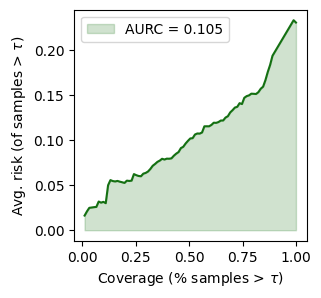

In [52]:
import matplotlib.pyplot as plt
color_accept = "#147012"
   
 # plot the risks
fig = plt.figure(figsize=(3, 3))
    # set aspect ratio to 1:1
fig.patch.set_facecolor("none")
   # plt.gca().set_aspect('equal', adjustable='box')
plt.plot(coverages, selrisks, color=color_accept)
  # add a shaded region below the curve
plt.fill_between(
        coverages, 0, selrisks, color=color_accept, alpha=0.2, label=f"AURC = {aurc_values:0.3f}"
    )
# plt.plot(opt_coverages, opt_selrisks, linestyle=":", color="black", label="optimal")
plt.xlabel(r"Coverage (% samples > $\tau$)")
plt.ylabel(r"Avg. risk (of samples > $\tau$)")
plt.legend()
    # return fig

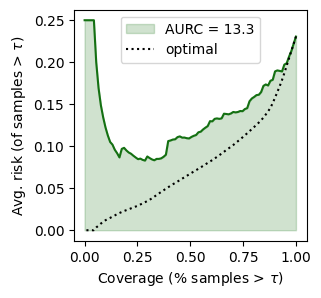

In [63]:
aurc = aurc_values 
color_accept = "#147012"
optimal_confid = -risks
stats_cache = StatsCache(confids, risks)
opt_stats = StatsCache(optimal_confid, risks)

opt_coverages, opt_selrisks, _ = opt_stats.rc_curve_stats
coverages, selrisks, _ = stats_cache.rc_curve_stats
aurc = get_metric_function("aurc")(stats_cache)
# plot the risks
fig = plt.figure(figsize=(3, 3))
# set aspect ratio to 1:1
fig.patch.set_facecolor("none")
# plt.gca().set_aspect('equal', adjustable='box')
plt.plot(coverages, selrisks, color=color_accept)
# add a shaded region below the curve
plt.fill_between(
    coverages, 0, selrisks, color=color_accept, alpha=0.2, label=f"AURC = {aurc*100:0.1f}"
)
plt.plot(opt_coverages, opt_selrisks, linestyle=":", color="black", label="optimal")
plt.xlabel(r"Coverage (% samples > $\tau$)")
plt.ylabel(r"Avg. risk (of samples > $\tau$)")
plt.legend()
plt.savefig("AURC_scaled_thickness_no_tumor.png", dpi=300, bbox_inches="tight")


In [146]:
import numpy as np
from segmentation_failures.evaluation.failure_detection.metrics import StatsCache, get_metric_function
import scipy 

# compute risk scores and confidence scores as you like
# risks = risk_array
# confids = confidence_array

stats = StatsCache(confids=confids, risks=risks)
aurc_values = get_metric_function("aurc")(stats)
print('aurc', aurc_values*100)
print('spearmanr',scipy.stats.spearmanr(confids, risks).statistic)
print('pearsonr',scipy.stats.pearsonr(confids, risks).statistic)

aurc 10.258935353570106
spearmanr -0.6811325262822555
pearsonr -0.7781675938710036


In [42]:
import numpy as np
from sklearn import metrics
y = np.array([1, 1, 2, 2])
pred = np.array([0.1, 0.4, 0.35, 0.8])
fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=2)
metrics.auc(fpr, tpr)

0.75

In [43]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
y = np.array([0, 0, 1, 1])
pred = np.array([0.1, 0.4, 0.35, 0.8])
fpr, tpr, thresholds = metrics.roc_curve(risks, confids,pos_label=0)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
display.plot()
plt.show()

ValueError: continuous format is not supported

In [147]:
# Analysis of phase 0 model

In [157]:
# original AURC reults from fd paper 
import os
import SimpleITK as sitk
import numpy as np
import pandas as pd
from segmentation_failures.evaluation.failure_detection.metrics import StatsCache, get_metric_function
import scipy 
phase = 4

# Function to calculate Dice Similarity Coefficient (DSC) for a given label (e.g., tumor)
def dice_coefficient(y_true, y_pred, label_value=2):
    """
    Calculate Dice Similarity Coefficient (DSC) for the given label.
    Handles cases where there is no tumor in the ground truth or prediction.
    """
    y_true = (y_true == label_value).flatten()  # Focus on the label (2 = tumor)
    y_pred = (y_pred == label_value).flatten()
    
    true_sum = np.sum(y_true)
    pred_sum = np.sum(y_pred)
    
    if true_sum == 0 and pred_sum == 0:
        return 1.0  # No tumor in both, perfect match
    elif true_sum == 0 or pred_sum == 0:
        return 0.0  # One has no tumor, the other does
    
    intersection = np.sum(y_true & y_pred)
    return 2.0 * intersection / (true_sum + pred_sum)

# Directories for the predictions and ensembeled prediction
# pred_dirs = [
#     "/mnt/largedrive3/mhamghalam/segPaper/phase0_f0",
#     "/mnt/largedrive3/mhamghalam/segPaper/phase0_f1",
#     "/mnt/largedrive3/mhamghalam/segPaper/phase0_f2",
#     "/mnt/largedrive3/mhamghalam/segPaper/phase0_f3",
#     "/mnt/largedrive3/mhamghalam/segPaper/phase0_f4"
# ]

# ensembled_dir = "/mnt/largedrive3/mhamghalam/segPaper/phase0_5folds"
if phase == 0:
    # Directories for the predictions and ensembeled prediction
    pred_dirs = [
        "/mnt/largedrive3/mhamghalam/segPaper/phase0_f0",
        "/mnt/largedrive3/mhamghalam/segPaper/phase0_f1",
        "/mnt/largedrive3/mhamghalam/segPaper/phase0_f2",
        "/mnt/largedrive3/mhamghalam/segPaper/phase0_f3",
        "/mnt/largedrive3/mhamghalam/segPaper/phase0_f4"
    ]

    ensembled_dir = "/mnt/largedrive3/mhamghalam/segPaper/phase0_5folds"

else:
# Directories for the predictions and ensembled prediction
    pred_dirs = [
        "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f0",
        "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f1",
        "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f2",
        "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f3",
        "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f4"
    ]

    ensembled_dir = "/mnt/largedrive3/mhamghalam/segPaper/ensembled_phase4"
  
ref_dir =   '/mnt/largedrive3/mhamghalam/segPaper/labelsTs_r01'
# Collect list of .nii.gz files from the reference folder
ref_files = sorted([f for f in os.listdir(ref_dir) if f.endswith(".nii.gz")])
ensembled_files = sorted([f for f in os.listdir(ensembled_dir) if f.endswith(".nii.gz")])

# Initialize lists to store results
risk_values = []
confidence_values = []
results = []
dscs_ensembled = []

# Loop over all reference files and ensembeled files
for ref_file, ensembled_file in zip(ref_files, ensembled_files):
    
    # Load reference image
    ref_path = os.path.join(ref_dir, ref_file)
    ref_img = sitk.ReadImage(ref_path)
    ref_array = sitk.GetArrayFromImage(ref_img)
    
    # Load ensembled prediction image
    ensembled_path = os.path.join(ensembled_dir, ensembled_file)
    ensembled_img = sitk.ReadImage(ensembled_path)
    ensembled_array = sitk.GetArrayFromImage(ensembled_img)
    
    # Calculate DSC for the ensembled prediction (focus on tumor label 2)
    dsc_ensembled = dice_coefficient(ref_array, ensembled_array, label_value=2)
    
    # Calculate risk as (1 - DSC)
    risk_value = 1.0 - dsc_ensembled
    risk_values.append(risk_value)
    dscs_ensembled.append(dsc_ensembled)

    # Load all predictions for the current file
    pred_arrays = []
    for pred_dir in pred_dirs:
        pred_file = os.path.join(pred_dir, ref_file)
        pred_img = sitk.ReadImage(pred_file)
        pred_array = sitk.GetArrayFromImage(pred_img)
        pred_arrays.append(pred_array)
    
    # Calculate pairwise DSC for the tumor label (2)
    num_preds = len(pred_arrays)
    pairwise_dscs = []
    
    for i in range(num_preds):
        for j in range(i + 1, num_preds):
            dsc = dice_coefficient(pred_arrays[i], pred_arrays[j], label_value=2)
            pairwise_dscs.append(dsc)
    
    # Calculate the mean pairwise DSC for the current image (confidence score)
    avg_pairwise_dsc = np.mean(pairwise_dscs)
    confidence_values.append(avg_pairwise_dsc)

    # Store results in the list for tracking
    results.append({
        'Name': ref_file,
        'Risk (1 - DSC)': risk_value,
        'Confidence (Pairwise DSC)': avg_pairwise_dsc,
        'DICE pred Ensemble':dsc_ensembled
    })

# Convert the results into a pandas DataFrame
df_results = pd.DataFrame(results)

# Save the results to a CSV file
df_results.to_csv('risk_confidence_results.csv', index=False)

# Save risk values and confidence values as numpy arrays
risk_array = np.array(risk_values)
confidence_array = np.array(confidence_values)

# Save the numpy arrays to files
np.save('risk_values.npy', risk_array)
np.save('confidence_values.npy', confidence_array)

# Display the first few rows of the results dataframe
print(df_results.head())
# compute risk scores and confidence scores as you like
risks = risk_array
confids = confidence_array

stats = StatsCache(confids=confids, risks=risks)
aurc_values = get_metric_function("aurc")(stats)
print('aurc', aurc_values*100)
print('spearmanr',scipy.stats.spearmanr(confids, risks).statistic)
print('pearsonr',scipy.stats.pearsonr(confids, risks).statistic)


                             Name  Risk (1 - DSC)  Confidence (Pairwise DSC)  \
0    RIA_17-010A_000_312_2.nii.gz         0.00000                   1.000000   
1  RIA_17-010A_000_332_101.nii.gz         0.95541                   0.072916   
2    RIA_17-010A_000_354_2.nii.gz         0.00000                   1.000000   
3    RIA_17-010A_000_389_2.nii.gz         1.00000                   0.100000   
4    RIA_17-010A_000_390_2.nii.gz         0.00000                   1.000000   

   DICE pred Ensemble  
0             1.00000  
1             0.04459  
2             1.00000  
3             0.00000  
4             1.00000  
aurc 21.092305766133297
spearmanr -0.5512170488011595
pearsonr -0.5912714370626131


In [19]:
# original AURC reults from fd paper 
import os
import SimpleITK as sitk
import numpy as np
import pandas as pd
from segmentation_failures.evaluation.failure_detection.metrics import StatsCache, get_metric_function
import scipy 

phase=4
# Function to calculate Dice Similarity Coefficient (DSC) for a given label (e.g., tumor)
def dice_coefficient(y_true, y_pred, label_value=2):
    """
    Calculate Dice Similarity Coefficient (DSC) for the given label.
    Handles cases where there is no tumor in the ground truth or prediction.
    """
    y_true = (y_true == label_value).flatten()  # Focus on the label (2 = tumor)
    y_pred = (y_pred == label_value).flatten()
    
    true_sum = np.sum(y_true)
    pred_sum = np.sum(y_pred)
    
    if true_sum == 0 and pred_sum == 0:
        return 1.0  # No tumor in both, perfect match
    elif true_sum == 0 or pred_sum == 0:
        return 0.0  # One has no tumor, the other does
    
    intersection = np.sum(y_true & y_pred)
    return 2.0 * intersection / (true_sum + pred_sum)

# Directories for the predictions and ensembeled prediction
# pred_dirs = [
#     "/mnt/largedrive3/mhamghalam/segPaper/phase0_f0",
#     "/mnt/largedrive3/mhamghalam/segPaper/phase0_f1",
#     "/mnt/largedrive3/mhamghalam/segPaper/phase0_f2",
#     "/mnt/largedrive3/mhamghalam/segPaper/phase0_f3",
#     "/mnt/largedrive3/mhamghalam/segPaper/phase0_f4"
# ]

# ensembled_dir = "/mnt/largedrive3/mhamghalam/segPaper/phase0_5folds"

if phase == 0:
    # Directories for the predictions and ensembeled prediction
    pred_dirs = [
        "/mnt/largedrive3/mhamghalam/segPaper/phase0_f0",
        "/mnt/largedrive3/mhamghalam/segPaper/phase0_f1",
        "/mnt/largedrive3/mhamghalam/segPaper/phase0_f2",
        "/mnt/largedrive3/mhamghalam/segPaper/phase0_f3",
        "/mnt/largedrive3/mhamghalam/segPaper/phase0_f4"
    ]

    ensembled_dir = "/mnt/largedrive3/mhamghalam/segPaper/phase0_5folds"

else:
# Directories for the predictions and ensembled prediction
    pred_dirs = [
        "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f0",
        "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f1",
        "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f2",
        "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f3",
        "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f4"
    ]

    ensembled_dir = "/mnt/largedrive3/mhamghalam/segPaper/ensembled_phase4"
  
ref_dir =   '/mnt/largedrive3/mhamghalam/segPaper/labelsTs_r01'
# Collect list of .nii.gz files from the reference folder
ref_files = sorted([f for f in os.listdir(ref_dir) if f.endswith(".nii.gz")])
ensembled_files = sorted([f for f in os.listdir(ensembled_dir) if f.endswith(".nii.gz")])

# Initialize lists to store results
risk_values = []
confidence_values = []
results = []
dscs_ensembled = []


# Function to map file names to cohorts
def map_to_cohort(filename): 
    if "010A_000" in filename:
        return "Recurrence Prediction-MSK"  # aim1.1
    elif "010C_000" in filename:
        return "Response Analysis-MSK"  # aim1.2
    elif "010_002" in filename:
        return "Contrast Injection Timing-MDA"  # aim2
    elif "mcrc" in filename:
        return "TCIA-MSK"  # public
    else:
        return "Contrast Injection Timing-MSK"  # aim2

# Initialize dictionaries to store risk and confidence values per cohort
cohort_risk_values = {}
cohort_confidence_values = {}
nsd = []
cohort_dsc_values = []
cohort_nsd_values = []
# Loop over all reference files and ensembeled files
for ref_file, ensembled_file in zip(ref_files, ensembled_files):
    
    # Load reference image
    ref_path = os.path.join(ref_dir, ref_file)
    ref_img = sitk.ReadImage(ref_path)
    ref_array = sitk.GetArrayFromImage(ref_img)
    voxel_spacing = ref_img.GetSpacing()
    
    # Load ensembled prediction image
    ensembled_path = os.path.join(ensembled_dir, ensembled_file)
    ensembled_img = sitk.ReadImage(ensembled_path)
    ensembled_array = sitk.GetArrayFromImage(ensembled_img)
    
    # Calculate DSC for the ensembled prediction (focus on tumor label 2)
    dsc_ensembled = dice_coefficient(ref_array, ensembled_array, label_value=2)
    # nsd_ensembled = normalized_surface_dice(ref_array==2, ensembled_array==2, spacing = voxel_spacing, connectivity=1)
    # print(nsd_ensembled)
    # nsd.append(nsd_ensembled)
    # Calculate risk as (1 - DSC)
    risk_value = 1.0 - dsc_ensembled
    
    # Load all predictions for the current file
    pred_arrays = []
    for pred_dir in pred_dirs:
        pred_file = os.path.join(pred_dir, ref_file)
        pred_img = sitk.ReadImage(pred_file)
        pred_array = sitk.GetArrayFromImage(pred_img)
        pred_arrays.append(pred_array)
    
    # Calculate pairwise DSC for the tumor label (2)
    num_preds = len(pred_arrays)
    pairwise_dscs = []
    
    for i in range(num_preds):
        for j in range(i + 1, num_preds):
            dsc = dice_coefficient(pred_arrays[i], pred_arrays[j], label_value=2)
            pairwise_dscs.append(dsc)
    
    # Calculate the mean pairwise DSC for the current image (confidence score)
    avg_pairwise_dsc = np.mean(pairwise_dscs)
    
    # Determine the cohort for this sample
    cohort = map_to_cohort(ref_file)
    
    # Initialize lists for the cohort if not already done
    if cohort not in cohort_risk_values:
        cohort_risk_values[cohort] = []
        cohort_confidence_values[cohort] = []
        # cohort_dsc_values[cohort] = []
        # cohort_nsd_values[cohort] = []
    # Append the risk and confidence values to the corresponding cohort
    cohort_risk_values[cohort].append(risk_value)
    cohort_confidence_values[cohort].append(avg_pairwise_dsc)
    # cohort_dsc_values[cohort].append(dsc_ensembled)
    # cohort_nsd_values[cohort].append(nsd_ensembled)


# Function to calculate stats for each cohort
def calculate_stats_for_cohort(risk_values, confidence_values):
    risk_array = np.array(risk_values)
    confidence_array = np.array(confidence_values)
    
    stats = StatsCache(confids=confidence_array, risks=risk_array)
    aurc_values = get_metric_function("aurc")(stats)
    
    spearman_corr = scipy.stats.spearmanr(confidence_array, risk_array).statistic
    pearson_corr = scipy.stats.pearsonr(confidence_array, risk_array).statistic
    
    return aurc_values * 100, spearman_corr, pearson_corr

# Calculate stats for each cohort
for cohort, risks in cohort_risk_values.items():
    confids = cohort_confidence_values[cohort]
    aurc, spearman_corr, pearson_corr = calculate_stats_for_cohort(risks, confids)
    # np.mean(cohort_dsc_values[cohort])
    # np.std(cohort_dsc_values[cohort])
    
    print(f"Stats for cohort {cohort}:")
    print(f"  AURC: {aurc}")
    print(f"  Spearman Correlation: {spearman_corr}")
    print(f"  Pearson Correlation: {pearson_corr}")

    print("\n")


Stats for cohort Recurrence Prediction-MSK:
  AURC: 25.99593057950426
  Spearman Correlation: -0.5507321950923881
  Pearson Correlation: -0.5405000877473061


Stats for cohort Response Analysis-MSK:
  AURC: 4.07695455580526
  Spearman Correlation: -0.9440559440559443
  Pearson Correlation: -0.9621842426019668


Stats for cohort Contrast Injection Timing-MSK:
  AURC: 6.4538315674898925
  Spearman Correlation: -0.8505494505494505
  Pearson Correlation: -0.7787654069722132


Stats for cohort Contrast Injection Timing-MDA:
  AURC: 4.075650611423896
  Spearman Correlation: -0.8821428571428571
  Pearson Correlation: -0.9091275864844632


Stats for cohort TCIA-MSK:
  AURC: 26.537444293939956
  Spearman Correlation: -0.4882968249660937
  Pearson Correlation: -0.5743949145909338




In [189]:
nsd = [1,2,np.nan]
print(np.mean(np.array(nsd)))

nan


In [156]:
#  phase 0 with cohort and NSD calculation
import os
import SimpleITK as sitk
import numpy as np
import pandas as pd
from segmentation_failures.evaluation.failure_detection.metrics import StatsCache, get_metric_function
import scipy 
from medpy.metric.binary import __surface_distances
from scipy import ndimage
# import stats
from collections import defaultdict


dsc_voxel_spacing = defaultdict(list)



phase = 4
label = 1 #1: livrer 2:tumor
# Function to calculate Dice Similarity Coefficient (DSC) for a given label (e.g., tumor)
def dice_coefficient(y_true, y_pred, label_value=2):
    """
    Calculate Dice Similarity Coefficient (DSC) for the given label.
    Handles cases where there is no tumor in the ground truth or prediction.
    """
    y_true = (y_true == label_value).flatten()  # Focus on the label (2 = tumor)
    y_pred = (y_pred == label_value).flatten()
    
    true_sum = np.sum(y_true)
    pred_sum = np.sum(y_pred)
    
    if true_sum == 0 and pred_sum == 0:
        return 1.0  # No tumor in both, perfect match
    elif true_sum == 0 or pred_sum == 0:
        return 0.0  # One has no tumor, the other does
    
    intersection = np.sum(y_true & y_pred)
    return 2.0 * intersection / (true_sum + pred_sum)






if phase == 0:
    # Directories for the predictions and ensembeled prediction
    pred_dirs = [
        "/mnt/largedrive3/mhamghalam/segPaper/phase0_f0",
        "/mnt/largedrive3/mhamghalam/segPaper/phase0_f1",
        "/mnt/largedrive3/mhamghalam/segPaper/phase0_f2",
        "/mnt/largedrive3/mhamghalam/segPaper/phase0_f3",
        "/mnt/largedrive3/mhamghalam/segPaper/phase0_f4"
    ]

    ensembled_dir = "/mnt/largedrive3/mhamghalam/segPaper/phase0_5folds"

else:
# Directories for the predictions and ensembled prediction
    pred_dirs = [
        "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f0",
        "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f1",
        "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f2",
        "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f3",
        "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f4"
    ]

    ensembled_dir = "/mnt/largedrive3/mhamghalam/segPaper/ensembled_phase4"



ref_dir =   '/mnt/largedrive3/mhamghalam/segPaper/labelsTs_r01'
# Collect list of .nii.gz files from the reference folder
ref_files = sorted([f for f in os.listdir(ref_dir) if f.endswith(".nii.gz")])
ensembled_files = sorted([f for f in os.listdir(ensembled_dir) if f.endswith(".nii.gz")])

# Initialize lists to store results
risk_values = []
confidence_values = []
results = []
dscs_ensembled = []
nsds_ensembled = []




def normalized_surface_dice(a: np.ndarray, b: np.ndarray, threshold: float = 1.0, spacing: tuple = None, connectivity=1, label_value = 2):
    """
    This implementation differs from the official surface dice implementation! These two are not comparable!!!!!

    The normalized surface dice is symmetric, so it should not matter whether a or b is the reference image

    This implementation natively supports 2D and 3D images. Whether other dimensions are supported depends on the
    __surface_distances implementation in medpy

    :param a: image 1, must have the same shape as b
    :param b: image 2, must have the same shape as a
    :param threshold: distances below this threshold will be counted as true positives. Threshold is in mm, not voxels!
    (if spacing = (1, 1(, 1)) then one voxel=1mm so the threshold is effectively in voxels)
    must be a tuple of len dimension(a)
    :param spacing: how many mm is one voxel in reality? Can be left at None, we then assume an isotropic spacing of 1mm
    :param connectivity: see scipy.ndimage.generate_binary_structure for more information. I suggest you leave that
    one alone
    :return:
    """
    a = (a == label_value).astype(int)  # Tumor label (2)
    b = (b == label_value).astype(int)
    
    # Check if there are any positive pixels in ground truth or prediction
    true_sum = np.sum(a.flatten())
    pred_sum = np.sum(b.flatten())
    
    if true_sum == 0 and pred_sum == 0:
        return 1.0  # No tumor in both, perfect match
    elif true_sum == 0 or pred_sum == 0:
        return 0.0  # One has no tumor, the other does
    
    a_to_b = __surface_distances(a, b, spacing, connectivity)
    b_to_a = __surface_distances(b, a, spacing, connectivity)

    numel_a = len(a_to_b)
    numel_b = len(b_to_a)

    tp_a = np.sum(a_to_b <= threshold) / numel_a
    tp_b = np.sum(b_to_a <= threshold) / numel_b

    fp = np.sum(a_to_b > threshold) / numel_a
    fn = np.sum(b_to_a > threshold) / numel_b

    dc = (tp_a + tp_b) / (tp_a + tp_b + fp + fn + 1e-8)  # 1e-8 just so that we don't get div by 0
    return dc




# Function to map file names to cohorts
def map_to_cohort(filename): 
    if "010A_000" in filename:
        return "Recurrence Prediction-MSK"  # aim1.1
    elif "010C_000" in filename:
        return "Response Analysis-MSK"  # aim1.2
    elif "010_002" in filename:
        return "Contrast Injection Timing-MDA"  # aim2
    elif "mcrc" in filename:
        return "TCIA-MSK"  # public
    else:
        return "Contrast Injection Timing-MSK"  # aim2

# Initialize dictionaries to store risk and confidence values per cohort
cohort_risk_values = {}
cohort_confidence_values = {}


def penalize_based_on_voxel_spacing(voxel_spacing, ideal_z_spacing=5.0):
    """
    Penalize confidence based on the deviation from ideal z-axis spacing (5 mm).
    A higher z-axis resolution (smaller spacing) should receive less penalty.
    """
    z_spacing = voxel_spacing[2]  # Z-axis spacing (third element)
    
    # Calculate the penalty factor based on the deviation from the ideal z-spacing (5 mm)
    if z_spacing < ideal_z_spacing:
        penalty_factor = 1.0  # No penalty if resolution is fine
    else:
        penalty_factor = ideal_z_spacing / z_spacing  # Penalize lower resolution
    # print(voxel_spacing)
    return penalty_factor

def scale_factor_based_on_tumor_size(tumor_volume, lower_bound=510.0, upper_bound=3385.0):
    """
    Return a scaling factor between 0 and 1 based on tumor volume.
    Small tumors get a smaller factor, large tumors get a larger factor.
    """
    if tumor_volume <= lower_bound:
        return 0.0  # Minimum scaling for small tumors
    elif tumor_volume >= upper_bound:
        return 1.0  # Maximum scaling for large tumors
    else:
        # Smooth scaling between 0 and 1 for tumor sizes between lower_bound and upper_bound
        return (tumor_volume - lower_bound) / (upper_bound - lower_bound)


# Function to detect tumors and calculate their real-world volumes
def detect_tumors_with_volumes(y_pred, voxel_spacing):
    tumor_voxels = (y_pred == 2).astype(np.int32)
    labeled_image, num_tumors = ndimage.label(tumor_voxels)
    
    tumor_volumes = []
    
    for tumor_label in range(1, num_tumors + 1):
        tumor_size_voxels = np.sum(labeled_image == tumor_label)
        tumor_volume = tumor_size_voxels * np.prod(voxel_spacing)  # Convert to mm³
        tumor_volumes.append(tumor_volume)
    
    total_tumor_volume = np.sum(tumor_volumes)
    average_tumor_volume = np.mean(tumor_volumes) if len(tumor_volumes) > 0 else 0.0
    
    return total_tumor_volume, average_tumor_volume

# Initialize dictionaries to store risk, confidence values, and ensembled DSC per cohort
cohort_risk_values = {}
cohort_confidence_values = {}
cohort_ensembled_dsc_values = {}  # To store ensembled DSC for each cohort
cohort_ensembled_nsd_values = {}  # To store ensembled NSD for each cohort

# Loop over all reference files and ensembled files
for ref_file, ensembled_file in zip(ref_files, ensembled_files):
    
    # Load reference image
    ref_path = os.path.join(ref_dir, ref_file)
    ref_img = sitk.ReadImage(ref_path)
    ref_array = sitk.GetArrayFromImage(ref_img)
    
    # Load ensembled prediction image
    ensembled_path = os.path.join(ensembled_dir, ensembled_file)
    ensembled_img = sitk.ReadImage(ensembled_path)
    ensembled_array = sitk.GetArrayFromImage(ensembled_img)

        # Get voxel spacing (slice thickness)
    voxel_spacing = ref_img.GetSpacing()
    
    # Calculate DSC for the ensembled prediction (focus on tumor label 2)
    dsc_ensembled = dice_coefficient(ref_array, ensembled_array, label_value=label)
    
    nsd_ensembled = normalized_surface_dice(a = ref_array, b = ensembled_array, spacing = voxel_spacing, connectivity=1, label_value = label, threshold=3)
    print(nsd_ensembled)
    nsds_ensembled.append(nsd_ensembled)

    # normalized_surface_dice(a: np.ndarray, b: np.ndarray, threshold: float = 1.0, spacing: tuple = None, connectivity=1, label_value = 2):
    # print(nsd_ensembled)
    # nsd.append(nsd_ensembled)
    # Calculate risk as (1 - DSC)
    
    dscs_ensembled.append(dsc_ensembled)
    # Calculate risk as (1 - DSC)
    risk_value = 1.0 - dsc_ensembled
    
    # Calculate tumor volume (number of voxels labeled as 2)
    # tumor_volume = np.sum(ref_array == 2)
    
    dsc_voxel_spacing[round(voxel_spacing[2],1)].append(dsc_ensembled)
    print(dsc_voxel_spacing)
    
    
    # Load all predictions for the current file
    pred_arrays = []
    tumor_volumes = []  # To store the tumor volume for each prediction
    avg_tumor_volumes = []  # To store the average tumor volumes for each prediction
    
    for pred_dir in pred_dirs:
        pred_file = os.path.join(pred_dir, ref_file)
        pred_img = sitk.ReadImage(pred_file)
        pred_array = sitk.GetArrayFromImage(pred_img)
        pred_arrays.append(pred_array)
        
        # Calculate tumor volumes
        total_tumor_volume, avg_tumor_volume = detect_tumors_with_volumes(pred_array, voxel_spacing)
        tumor_volumes.append(total_tumor_volume)
        avg_tumor_volumes.append(avg_tumor_volume)
    
    # Calculate pairwise DSC for the tumor label (2), weighted by average tumor volume
    num_preds = len(pred_arrays)
    weighted_pairwise_dscs = []
    avg_tumor_volume_global = np.mean(avg_tumor_volumes)  # Average tumor volume for weighting
    
    for i in range(num_preds):
        for j in range(i + 1, num_preds):
            dsc = dice_coefficient(pred_arrays[i], pred_arrays[j], label_value=label)
            avg_vol_ij = (avg_tumor_volumes[i] + avg_tumor_volumes[j]) / 2  # Average tumor volume for this pair
            
            # Penalize confidence if the average volume is small
            penalization_factor = avg_vol_ij / avg_tumor_volume_global if avg_tumor_volume_global > 0 else 1.0
            
            # Weight by tumor volume (lower weight for small average volumes)
            weighted_pairwise_dscs.append(dsc * penalization_factor)
    
    # Calculate the mean weighted pairwise DSC for the current image (confidence score)
    if len(weighted_pairwise_dscs) > 0:
        avg_weighted_pairwise_dsc = np.mean(weighted_pairwise_dscs)
    else:
        avg_weighted_pairwise_dsc = 0.0
    
    # Scale confidence based on tumor size (penalize small tumors)
    tumor_size_scaling_factor = scale_factor_based_on_tumor_size(np.mean(tumor_volumes))
    
    # Apply penalty for low-resolution images based on z-axis spacing
    voxel_spacing_penalty_factor = penalize_based_on_voxel_spacing(voxel_spacing)
    
    # Adjust confidence by tumor size scaling and voxel spacing penalty
    scaled_confidence = avg_weighted_pairwise_dsc * tumor_size_scaling_factor * voxel_spacing_penalty_factor
    # confidence_values.append(penalized_confidence)


    # Determine the cohort for this sample
    cohort = map_to_cohort(ref_file)
    
    # Initialize lists for the cohort if not already done
    if cohort not in cohort_risk_values:
        cohort_risk_values[cohort] = []
        cohort_confidence_values[cohort] = []
        cohort_ensembled_dsc_values[cohort] = []  # Initialize for ensembled DSC
        cohort_ensembled_nsd_values[cohort] = []

    # Append the risk, scaled confidence, and ensembled DSC values to the corresponding cohort
    cohort_risk_values[cohort].append(risk_value)
    cohort_confidence_values[cohort].append(scaled_confidence)
    cohort_ensembled_dsc_values[cohort].append(dsc_ensembled)  # Store ensembled DSC
    cohort_ensembled_nsd_values[cohort].append(nsd_ensembled)

# Function to calculate stats for each cohort
def calculate_stats_for_cohort(risk_values, confidence_values, ensembled_dsc_values, ensembled_nsd_values):
    risk_array = np.array(risk_values)
    confidence_array = np.array(confidence_values)
    ensembled_dsc_array = np.array(ensembled_dsc_values)
    ensembled_nsd_array = np.array(ensembled_nsd_values)

    
    stats = StatsCache(confids=confidence_array, risks=risk_array)
    aurc_values = get_metric_function("aurc")(stats)
    
    spearman_corr = scipy.stats.spearmanr(confidence_array, risk_array).statistic
    pearson_corr = scipy.stats.pearsonr(confidence_array, risk_array).statistic
    
    # Calculate mean ensembled DSC for this cohort
    mean_ensembled_dsc = np.mean(ensembled_dsc_array)
    mean_ensembled_nsd = np.mean(ensembled_nsd_array)

    
    return aurc_values * 100, spearman_corr, pearson_corr, mean_ensembled_dsc, mean_ensembled_nsd

# Calculate stats for each cohort
for cohort, risks in cohort_risk_values.items():
    confids = cohort_confidence_values[cohort]
    ensembled_dscs = cohort_ensembled_dsc_values[cohort]  # Get ensembled DSC for cohort
    ensembled_nsds = cohort_ensembled_nsd_values[cohort]  # Get ensembled DSC for cohort

    
    aurc, spearman_corr, pearson_corr, mean_ensembled_dsc, mean_ensembled_nsd = calculate_stats_for_cohort(risks, confids, ensembled_dscs, ensembled_nsds)
    
    print(f"Stats for cohort {cohort}:")
    print(f"  AURC: {aurc}")
    print(f"  Spearman Correlation: {spearman_corr}")
    print(f"  Pearson Correlation: {pearson_corr}")
    print(f"  Mean Ensembled DSC: {mean_ensembled_dsc}")
    print(f"  Mean Ensembled NSD: {mean_ensembled_nsd}")

    print("\n")

print(f"NSD: {np.mean(np.array(nsds_ensembled))}")

# tumor_dices = [0.9695,0.9694,0.969,0.9698,0.9494]

# # Calculate mean
# mean_nsd = np.mean(np.array(nsds_ensembled))

# # Calculate 95% confidence interval
# confidence_interval = stats.t.interval(0.95, len(nsds_ensembled)-1, loc=mean_nsd, scale=stats.sem(nsds_ensembled))



0.9973102891615384
defaultdict(<class 'list'>, {5.0: [0.9900131358157209]})
0.9663133040581406
defaultdict(<class 'list'>, {5.0: [0.9900131358157209], 1.5: [0.9849070223376231]})
0.9941671282105926
defaultdict(<class 'list'>, {5.0: [0.9900131358157209, 0.9887237701567814], 1.5: [0.9849070223376231]})
0.9985099277725098
defaultdict(<class 'list'>, {5.0: [0.9900131358157209, 0.9887237701567814, 0.9924067936538323], 1.5: [0.9849070223376231]})
0.9976107347886242
defaultdict(<class 'list'>, {5.0: [0.9900131358157209, 0.9887237701567814, 0.9924067936538323, 0.989599241341938], 1.5: [0.9849070223376231]})
0.9827189576253194
defaultdict(<class 'list'>, {5.0: [0.9900131358157209, 0.9887237701567814, 0.9924067936538323, 0.989599241341938, 0.9664955994114646], 1.5: [0.9849070223376231]})
0.9967478669986276
defaultdict(<class 'list'>, {5.0: [0.9900131358157209, 0.9887237701567814, 0.9924067936538323, 0.989599241341938, 0.9664955994114646, 0.9859684758880595], 1.5: [0.9849070223376231]})
0.9248623

2025-01-26 18:21:31,747 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-01-26 18:21:31,752 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-01-26 18:21:31,772 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-01-26 18:21:31,774 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


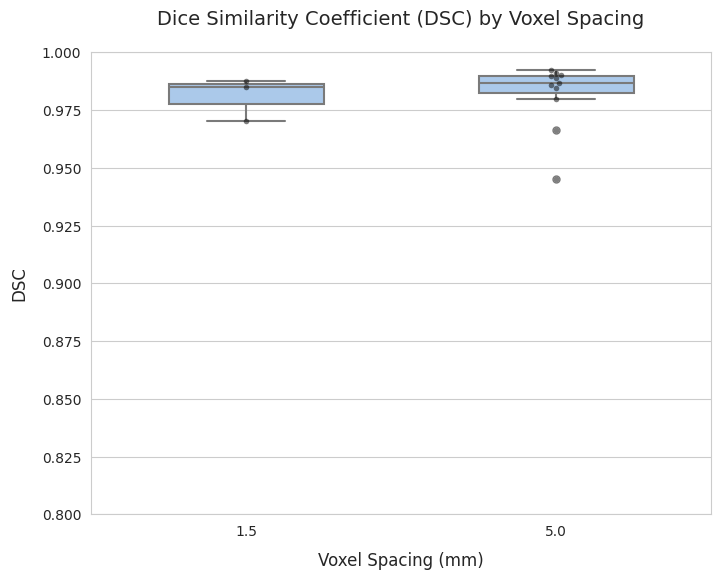

In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

# Example data (replace this with your actual defaultdict)
# dsc_voxel_spacing = defaultdict(list)
# dsc_voxel_spacing[1.0] = [0.95, 0.92, 0.93, 0.94]  # DSC values for 1.0 mm voxel spacing
# dsc_voxel_spacing[2.5] = [0.89, 0.88, 0.90, 0.91]  # DSC values for 2.5 mm voxel spacing
# dsc_voxel_spacing[5.0] = [0.85, 0.84, 0.86, 0.87]  # DSC values for 5.0 mm voxel spacing

# Convert defaultdict to DataFrame
data = []
for spacing, dsc_values in dsc_voxel_spacing.items():
    for dsc in dsc_values:
        data.append({"Voxel Spacing (mm)": spacing, "DSC": dsc})

df = pd.DataFrame(data)

# Set up the plot
plt.figure(figsize=(8, 6))  # Adjust figure size
sns.set_style("whitegrid")  # Use a clean grid style
sns.set_palette("pastel")   # Use a soft color palette

# Create the box plot
ax = sns.boxplot(
    x="Voxel Spacing (mm)", 
    y="DSC", 
    data=df, 
    width=0.5, 
    linewidth=1.5, 
    fliersize=5
)

# Add swarm plot for individual data points (optional)
sns.swarmplot(
    x="Voxel Spacing (mm)", 
    y="DSC", 
    data=df, 
    color="black", 
    alpha=0.5, 
    size=4
)

# Customize the plot
plt.title("Dice Similarity Coefficient (DSC) by Voxel Spacing", fontsize=14, pad=20)
plt.xlabel("Voxel Spacing (mm)", fontsize=12, labelpad=10)
plt.ylabel("DSC", fontsize=12, labelpad=10)
plt.ylim(0.8, 1.0)  # Set y-axis limits for better visualization

# Save the plot as a high-resolution image
plt.savefig("dsc_vs_voxel_spacing.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

2025-01-26 19:02:20,500 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-01-26 19:02:20,505 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-01-26 19:02:20,546 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_249326/334515937.py:89: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:.25'` for the same effect.

  sns.swarmplot(
2025-01-26 19:02:20,550 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. 

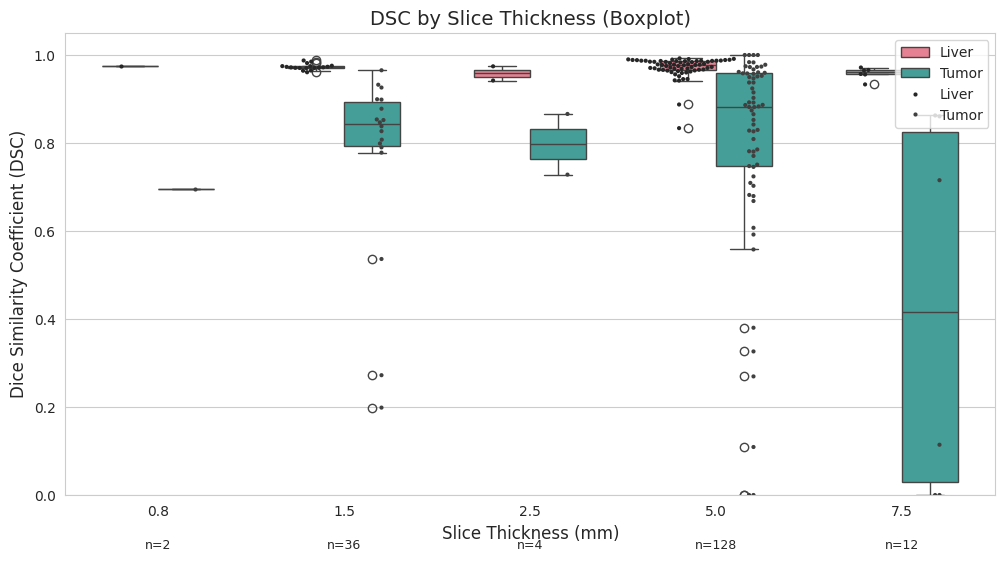

In [70]:
import os
import numpy as np
import SimpleITK as sitk
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

# Configuration
PLOT_TYPE = "box"  # Choose: "box", "violin", "line", "facet", or "all"
SHOW_SWARM = True  # For box/violin plots
SAVE_FIG = True

# --------------------------------------------
# Core Functions (No changes needed below here)
# --------------------------------------------

def dice_coefficient(y_true: np.ndarray, y_pred: np.ndarray, label_value: int) -> float:
    """Calculate Dice Similarity Coefficient for a specific label."""
    mask_true = (y_true == label_value).astype(int)
    mask_pred = (y_pred == label_value).astype(int)

    if np.sum(mask_true) + np.sum(mask_pred) == 0:
        return 1.0
    if np.sum(mask_true) == 0 or np.sum(mask_pred) == 0:
        return 0.0

    intersection = np.sum(mask_true & mask_pred)
    return (2.0 * intersection) / (np.sum(mask_true) + np.sum(mask_pred))

def process_files(ref_dir: str, pred_dir: str) -> pd.DataFrame:
    """Process files and return formatted DataFrame."""
    dsc_data = defaultdict(lambda: defaultdict(list))

    ref_files = sorted(f for f in os.listdir(ref_dir) if f.endswith(".nii.gz"))
    pred_files = sorted(f for f in os.listdir(pred_dir) if f.endswith(".nii.gz"))

    for ref_file, pred_file in zip(ref_files, pred_files):
        try:
            ref_img = sitk.ReadImage(os.path.join(ref_dir, ref_file))
            pred_img = sitk.ReadImage(os.path.join(pred_dir, pred_file))
            
            thickness = round(ref_img.GetSpacing()[2], 1)
            ref_array = sitk.GetArrayFromImage(ref_img)
            pred_array = sitk.GetArrayFromImage(pred_img)

            dsc_data[thickness]["Liver"].append(
                dice_coefficient(ref_array, pred_array, 1)
            )
            dsc_data[thickness]["Tumor"].append(
                dice_coefficient(ref_array, pred_array, 2)
            )
            
        except Exception as e:
            print(f"Error processing {ref_file}: {str(e)}")

    # Convert to DataFrame
    data = []
    for thickness, labels in dsc_data.items():
        for label, values in labels.items():
            data.extend([{"Slice Thickness (mm)": thickness, 
                         "DSC": v, 
                         "Structure": label} for v in values])
    
    df = pd.DataFrame(data)
    df["Slice Thickness (mm)"] = pd.Categorical(
        df["Slice Thickness (mm)"], 
        categories=sorted(df["Slice Thickness (mm)"].unique()), 
        ordered=True
    )
    
    return df

def create_boxplot(df: pd.DataFrame):
    """Create a boxplot with optional swarm plot overlay."""
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    sns.set_palette("husl", n_colors=2)
    
    ax = sns.boxplot(
        x="Slice Thickness (mm)", 
        y="DSC", 
        hue="Structure", 
        data=df, 
        width=0.6
    )
    
    if SHOW_SWARM:
        sns.swarmplot(
            x="Slice Thickness (mm)", 
            y="DSC", 
            hue="Structure", 
            data=df, 
            dodge=True, 
            color=".25", 
            size=3
        )
    
    plt.title("DSC by Slice Thickness (Boxplot)", fontsize=14)
    plt.xlabel("Slice Thickness (mm)", fontsize=12)
    plt.ylabel("Dice Similarity Coefficient (DSC)", fontsize=12)
    plt.ylim(0, 1.05)
    
    # Add sample sizes
    for i, thickness in enumerate(df["Slice Thickness (mm)"].cat.categories):
        n = df[df["Slice Thickness (mm)"] == thickness].shape[0]
        plt.text(i, -0.1, f"n={n}", ha="center", va="top", fontsize=9)
    
    plt.legend(loc="upper right")
    
    if SAVE_FIG:
        plt.savefig("dsc_vs_thickness_boxplot.png", dpi=300, bbox_inches="tight")
    
    plt.show()

def create_violinplot(df: pd.DataFrame):
    """Create a violin plot."""
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    sns.set_palette("husl", n_colors=2)
    
    ax = sns.violinplot(
        x="Slice Thickness (mm)", 
        y="DSC", 
        hue="Structure", 
        data=df, 
        split=True, 
        inner="quartile"
    )
    
    plt.title("DSC by Slice Thickness (Violin Plot)", fontsize=14)
    plt.xlabel("Slice Thickness (mm)", fontsize=12)
    plt.ylabel("Dice Similarity Coefficient (DSC)", fontsize=12)
    plt.ylim(0, 1.05)
    
    # Add sample sizes
    for i, thickness in enumerate(df["Slice Thickness (mm)"].cat.categories):
        n = df[df["Slice Thickness (mm)"] == thickness].shape[0]
        plt.text(i, -0.1, f"n={n}", ha="center", va="top", fontsize=9)
    
    plt.legend(loc="upper right")
    
    if SAVE_FIG:
        plt.savefig("dsc_vs_thickness_violinplot.png", dpi=300, bbox_inches="tight")
    
    plt.show()

def create_lineplot(df: pd.DataFrame):
    """Create a line plot with confidence intervals."""
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    sns.set_palette("husl", n_colors=2)
    
    ax = sns.lineplot(
        x="Slice Thickness (mm)", 
        y="DSC", 
        hue="Structure", 
        data=df, 
        estimator="median", 
        errorbar=("pi", 95), 
        marker="o", 
        markersize=8
    )
    
    plt.title("DSC by Slice Thickness (Line Plot)", fontsize=14)
    plt.xlabel("Slice Thickness (mm)", fontsize=12)
    plt.ylabel("Dice Similarity Coefficient (DSC)", fontsize=12)
    plt.ylim(0, 1.05)
    
    plt.legend(loc="upper right")
    
    if SAVE_FIG:
        plt.savefig("dsc_vs_thickness_lineplot.png", dpi=300, bbox_inches="tight")
    
    plt.show()

def create_facetplot(df: pd.DataFrame):
    """Create a facet plot with separate subplots for Liver and Tumor."""
    g = sns.FacetGrid(df, col="Structure", height=5, aspect=1.2)
    g.map_dataframe(sns.boxplot, x="Slice Thickness (mm)", y="DSC")
    g.set_titles(col_template="{col_name}")
    
    plt.suptitle("DSC by Slice Thickness (Facet Plot)", fontsize=14, y=1.02)
    g.set_axis_labels("Slice Thickness (mm)", "Dice Similarity Coefficient (DSC)")
    
    if SAVE_FIG:
        plt.savefig("dsc_vs_thickness_facetplot.png", dpi=300, bbox_inches="tight")
    
    plt.show()

# ----------------------
# Main Execution
# ----------------------
if __name__ == "__main__":
    # Initialize data
    df = process_files(
        ref_dir='/mnt/largedrive3/mhamghalam/segPaper/labelsTs_r01',
        pred_dir="/mnt/largedrive3/mhamghalam/segPaper/ensembled_phase4"
    )
    
    # Generate selected plot(s)
    if PLOT_TYPE == "box":
        create_boxplot(df)
    elif PLOT_TYPE == "violin":
        create_violinplot(df)
    elif PLOT_TYPE == "line":
        create_lineplot(df)
    elif PLOT_TYPE == "facet":
        create_facetplot(df)
    elif PLOT_TYPE == "all":
        create_boxplot(df)
        create_violinplot(df)
        create_lineplot(df)
        create_facetplot(df)
    else:
        raise ValueError("Invalid PLOT_TYPE. Choose: 'box', 'violin', 'line', 'facet', or 'all'.")

,Slice Thickness (mm),DSC,Structure,filename,cohort
0,5.0,0.990013,Liver,RIA_17-010A_000_312_2.nii.gz,Recurrence
1,5.0,0.988724,Liver,RIA_17-010A_000_354_2.nii.gz,Recurrence
2,5.0,0.992407,Liver,RIA_17-010A_000_389_2.nii.gz,Recurrence
3,5.0,0.989599,Liver,RIA_17-010A_000_390_2.nii.gz,Recurrence
4,5.0,0.966496,Liver,RIA_17-010A_000_411_2.nii.gz,Recurrence
...,...,...,...,...,...
177,0.8,0.695832,Tumor,mcrc_105.nii.gz,Public CRLM
178,2.5,0.941995,Liver,mcrc_122.nii.gz,Public CRLM
179,2.5,0.974264,Liver,mcrc_159.nii.gz,Public CRLM
180,2.5,0.728153,Tumor,mcrc_122.nii.gz,Public CRLM


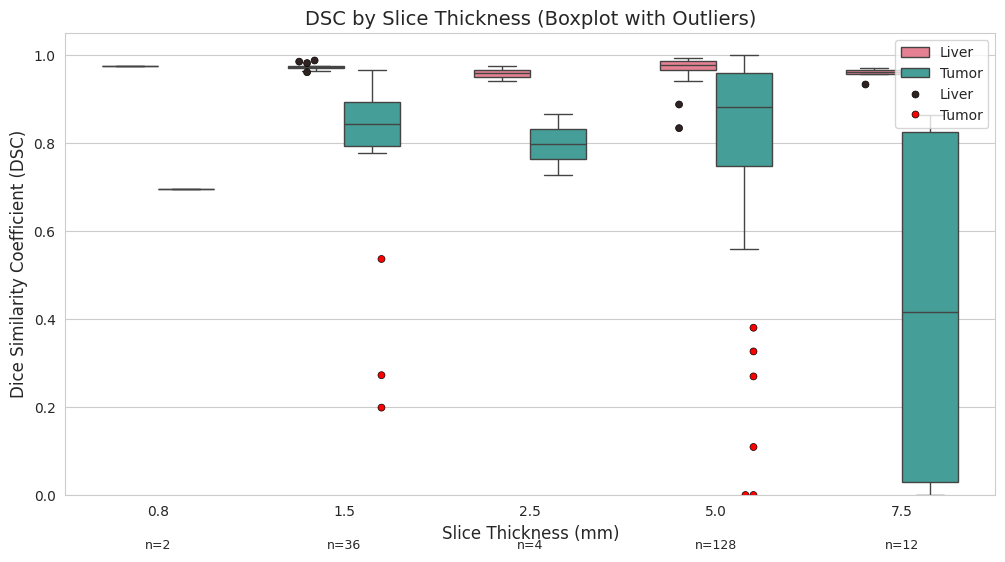

In [140]:
import os
import numpy as np
import SimpleITK as sitk
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

# Configuration
SAVE_FIG = True

# --------------------------------------------
# Core Functions (No changes needed below here)
# --------------------------------------------

def dice_coefficient(y_true: np.ndarray, y_pred: np.ndarray, label_value: int) -> float:
    """Calculate Dice Similarity Coefficient for a specific label."""
    mask_true = (y_true == label_value).astype(int)
    mask_pred = (y_pred == label_value).astype(int)

    if np.sum(mask_true) + np.sum(mask_pred) == 0:
        return 1.0
    if np.sum(mask_true) == 0 or np.sum(mask_pred) == 0:
        return 0.0

    intersection = np.sum(mask_true & mask_pred)
    return (2.0 * intersection) / (np.sum(mask_true) + np.sum(mask_pred))

def process_files(ref_dir: str, pred_dir: str) -> pd.DataFrame:
    """Process files and return formatted DataFrame."""
    dsc_data = defaultdict(lambda: defaultdict(list))

    ref_files = sorted(f for f in os.listdir(ref_dir) if f.endswith(".nii.gz"))
    pred_files = sorted(f for f in os.listdir(pred_dir) if f.endswith(".nii.gz"))

    for ref_file, pred_file in zip(ref_files, pred_files):
        try:
            ref_img = sitk.ReadImage(os.path.join(ref_dir, ref_file))
            pred_img = sitk.ReadImage(os.path.join(pred_dir, pred_file))
            
            thickness = round(ref_img.GetSpacing()[2], 1)
            ref_array = sitk.GetArrayFromImage(ref_img)
            pred_array = sitk.GetArrayFromImage(pred_img)

            dsc_data[thickness]["Liver"].append(
                dice_coefficient(ref_array, pred_array, 1)
            )
            dsc_data[thickness]["Tumor"].append(
                dice_coefficient(ref_array, pred_array, 2)
            )
            
        except Exception as e:
            print(f"Error processing {ref_file}: {str(e)}")

    # Convert to DataFrame
    data = []
    for thickness, labels in dsc_data.items():
        for label, values in labels.items():
            data.extend([{"Slice Thickness (mm)": thickness, 
                         "DSC": v, 
                         "Structure": label} for v in values])
    
    df = pd.DataFrame(data)
    df["Slice Thickness (mm)"] = pd.Categorical(
        df["Slice Thickness (mm)"], 
        categories=sorted(df["Slice Thickness (mm)"].unique()), 
        ordered=True
    )
    
    return df

def create_boxplot_with_outliers(df: pd.DataFrame):
    """Create a boxplot with swarmplot overlay for outliers only."""
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    sns.set_palette("husl", n_colors=2)
    
    # Create the boxplot
    ax = sns.boxplot(
        x="Slice Thickness (mm)", 
        y="DSC", 
        hue="Structure", 
        data=df, 
        width=0.6,
        showfliers=False  # Hide default outliers
    )
    
    # Identify and plot outliers using swarmplot
    outliers_data = []
    for structure in df["Structure"].unique():
        for thickness in df["Slice Thickness (mm)"].cat.categories:
            subset = df[(df["Slice Thickness (mm)"] == thickness) & (df["Structure"] == structure)]
            if len(subset) > 0:
                # Calculate IQR
                Q1 = subset["DSC"].quantile(0.25)
                Q3 = subset["DSC"].quantile(0.75)
                IQR = Q3 - Q1
                
                # Define outliers
                outliers = subset[(subset["DSC"] < (Q1 - 1.5 * IQR)) | (subset["DSC"] > (Q3 + 1.5 * IQR))]
                outliers_data.extend(outliers.to_dict('records'))
    
    # Convert outliers to DataFrame
    outliers_df = pd.DataFrame(outliers_data)
    
    # Plot outliers using swarmplot
    if not outliers_df.empty:
        sns.swarmplot(
            x="Slice Thickness (mm)", 
            y="DSC", 
            hue="Structure", 
            data=outliers_df, 
            dodge=True, 
            palette="dark:red",  # Use gradient palette for red
            size=5,              # Increase size for visibility
            edgecolor="black",   # Add black border to points
            linewidth=0.5
        )
    
    plt.title("DSC by Slice Thickness (Boxplot with Outliers)", fontsize=14)
    plt.xlabel("Slice Thickness (mm)", fontsize=12)
    plt.ylabel("Dice Similarity Coefficient (DSC)", fontsize=12)
    plt.ylim(0, 1.05)
    
    # Add sample sizes
    for i, thickness in enumerate(df["Slice Thickness (mm)"].cat.categories):
        n = df[df["Slice Thickness (mm)"] == thickness].shape[0]
        plt.text(i, -0.1, f"n={n}", ha="center", va="top", fontsize=9)
    
    # Add legend for outliers
    handles, labels = ax.get_legend_handles_labels()
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, markeredgecolor='black'))
    # labels.append("Outliers")
    ax.legend(handles, labels, loc="upper right")
    
    if SAVE_FIG:
        plt.savefig("dsc_vs_thickness_boxplot_outliers.png", dpi=300, bbox_inches="tight")
    
    plt.show()

# ----------------------
# Main Execution
# ----------------------
if __name__ == "__main__":
    # Initialize data
    df = process_files(
        ref_dir='/mnt/largedrive3/mhamghalam/segPaper/labelsTs_r01',
        pred_dir="/mnt/largedrive3/mhamghalam/segPaper/ensembled_phase4"
    )
    
    # Generate boxplot with outliers as swarmplot
    create_boxplot_with_outliers(df)

In [141]:
def map_to_cohort(filename): 
    if "010A_000" in filename:
        return "Recurrence"  # aim1.1
    elif "010C_000" in filename:
        return "Response"  # aim1.2
    elif "010_002" in filename:
        return "Contrast Timing-MDA"  # aim2
    elif "mcrc" in filename:
        return "Public CRLM"  # public
    else:
        return "Contrast Timing-MSK"  # aim2


In [143]:
def create_unified_cohort_plot(df: pd.DataFrame):
    """Create a unified plot showing all cohorts and structures in one view."""
    plt.figure(figsize=(18, 8))
    sns.set_style("whitegrid")
    palette = sns.color_palette("husl", n_colors=len(df['cohort'].unique()))
    
    # Create combined positioning
    unique_thicknesses = sorted(df["Slice Thickness (mm)"].unique())
    cohort_names = df['cohort'].unique()
    
    # Calculate positions for precise box placement
    positions = []
    offset = 0.2  # Space between thickness groups
    box_width = 0.15  # Width of each individual box
    
    for i, thickness in enumerate(unique_thicknesses):
        for j, cohort in enumerate(cohort_names):
            # Base position for this thickness group
            base_pos = i * (len(cohort_names) + 1) * offset
            positions.append(base_pos + j * box_width)
    
    # Create the boxplot
    boxplot = sns.boxplot(
        x=[f"{thick}\n{cohort}" for thick, cohort in zip(df["Slice Thickness (mm)"], df["cohort"])],
        y="DSC", 
        hue="Structure",
        data=df,
        palette="Set2",
        width=box_width,
        showfliers=False,
        dodge=True
    )
    
    # Add swarmplot for outliers
    outliers = []
    for (thickness, cohort, structure), group in df.groupby(["Slice Thickness (mm)", "cohort", "Structure"]):
        Q1 = group["DSC"].quantile(0.25)
        Q3 = group["DSC"].quantile(0.75)
        IQR = Q3 - Q1
        outlier_group = group[(group["DSC"] < (Q1 - 1.5 * IQR)) | (group["DSC"] > (Q3 + 1.5 * IQR))]
        outliers.append(outlier_group)
    
    if outliers:
        outliers_df = pd.concat(outliers)
        sns.swarmplot(
            x=[f"{thick}\n{cohort}" for thick, cohort in zip(outliers_df["Slice Thickness (mm)"], outliers_df["cohort"])],
            y="DSC",
            hue="Structure",
            data=outliers_df,
            palette="dark:red",
            size=6,
            edgecolor="black",
            linewidth=0.5,
            dodge=True
        )
    
    # Plot styling
    plt.title("DSC by Slice Thickness, Cohort, and Structure", fontsize=16)
    plt.xlabel("Slice Thickness (mm) with Cohort", fontsize=12)
    plt.ylabel("Dice Similarity Coefficient (DSC)", fontsize=12)
    plt.ylim(-0.05, 1.1)
    
    # Add sample size annotations
    for (thickness, cohort), group in df.groupby(["Slice Thickness (mm)", "cohort"]):
        pos = positions[len(cohort_names) * unique_thicknesses.index(thickness) + list(cohort_names).index(cohort)]
        plt.text(pos, -0.15, f"n={len(group)}", 
                rotation=45, ha='right', va='top', fontsize=8)
    
    # Legend customization
    handles, labels = boxplot.get_legend_handles_labels()
    plt.legend(handles[:2], labels[:2], title="Structure", 
              bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add cohort color indicators
    for j, cohort in enumerate(cohort_names):
        plt.plot([], [], color=palette[j], label=cohort)
    plt.legend(bbox_to_anchor=(1.05, 0.7), loc='upper left', title="Cohort")
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    if SAVE_FIG:
        plt.savefig("unified_cohort_dsc_plot.png", dpi=300, bbox_inches="tight")
    
    plt.show()

# Add cohort mapping to your existing dataframe
df['cohort'] = df['filename'].apply(map_to_cohort)

# Generate the unified plot
create_unified_cohort_plot(df)

KeyError: 'filename'

In [144]:
def create_cohort_based_plot(df: pd.DataFrame):
    """Create plot comparing DSC between cohorts (aggregating all thicknesses)."""
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    sns.set_palette("husl", n_colors=2)
    
    # Create the boxplot
    ax = sns.boxplot(
        x="cohort", 
        y="DSC", 
        hue="Structure", 
        data=df, 
        width=0.6,
        showfliers=False
    )
    
    # Identify and plot outliers
    outliers_data = []
    for cohort in df["cohort"].unique():
        for structure in df["Structure"].unique():
            subset = df[(df["cohort"] == cohort) & (df["Structure"] == structure)]
            if len(subset) > 0:
                Q1 = subset["DSC"].quantile(0.25)
                Q3 = subset["DSC"].quantile(0.75)
                IQR = Q3 - Q1
                outliers = subset[(subset["DSC"] < (Q1 - 1.5 * IQR)) | 
                                 (subset["DSC"] > (Q3 + 1.5 * IQR))]
                outliers_data.extend(outliers.to_dict('records'))
    
    # Plot outliers
    outliers_df = pd.DataFrame(outliers_data)
    if not outliers_df.empty:
        sns.swarmplot(
            x="cohort", 
            y="DSC", 
            hue="Structure", 
            data=outliers_df, 
            dodge=True, 
            palette="dark:red",
            size=5,
            edgecolor="black",
            linewidth=0.5
        )
    
    plt.title("DSC by Cohort (All Slice Thicknesses Combined)", fontsize=14)
    plt.xlabel("Cohort", fontsize=12)
    plt.ylabel("Dice Similarity Coefficient (DSC)", fontsize=12)
    plt.ylim(0, 1.05)
    
    # Add sample sizes
    for i, cohort in enumerate(df["cohort"].unique()):
        n = df[df["cohort"] == cohort].shape[0]
        plt.text(i, -0.1, f"n={n}", ha="center", va="top", fontsize=9)
    
    # Legend handling
    handles, labels = ax.get_legend_handles_labels()
    handles.append(plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor='red', markersize=10, 
                            markeredgecolor='black'))
    ax.legend(handles, labels, loc="upper right")
    
    plt.xticks(rotation=45, ha='right')
    
    if SAVE_FIG:
        plt.savefig("dsc_by_cohort.png", dpi=300, bbox_inches="tight")
    
    plt.show()

def create_thickness_based_plot(df: pd.DataFrame):
    """Create plot comparing DSC between slice thicknesses (aggregating all cohorts)."""
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    sns.set_palette("husl", n_colors=2)
    
    # Create the boxplot
    ax = sns.boxplot(
        x="Slice Thickness (mm)", 
        y="DSC", 
        hue="Structure", 
        data=df, 
        width=0.6,
        showfliers=False
    )
    
    # Identify and plot outliers
    outliers_data = []
    for thickness in df["Slice Thickness (mm)"].unique():
        for structure in df["Structure"].unique():
            subset = df[(df["Slice Thickness (mm)"] == thickness) & 
                       (df["Structure"] == structure)]
            if len(subset) > 0:
                Q1 = subset["DSC"].quantile(0.25)
                Q3 = subset["DSC"].quantile(0.75)
                IQR = Q3 - Q1
                outliers = subset[(subset["DSC"] < (Q1 - 1.5 * IQR)) | 
                                 (subset["DSC"] > (Q3 + 1.5 * IQR))]
                outliers_data.extend(outliers.to_dict('records'))
    
    # Plot outliers
    outliers_df = pd.DataFrame(outliers_data)
    if not outliers_df.empty:
        sns.swarmplot(
            x="Slice Thickness (mm)", 
            y="DSC", 
            hue="Structure", 
            data=outliers_df, 
            dodge=True, 
            palette="dark:red",
            size=5,
            edgecolor="black",
            linewidth=0.5
        )
    
    plt.title("DSC by Slice Thickness (All Cohorts Combined)", fontsize=14)
    plt.xlabel("Slice Thickness (mm)", fontsize=12)
    plt.ylabel("Dice Similarity Coefficient (DSC)", fontsize=12)
    plt.ylim(0, 1.05)
    
    # Add sample sizes
    for i, thickness in enumerate(df["Slice Thickness (mm)"].cat.categories):
        n = df[df["Slice Thickness (mm)"] == thickness].shape[0]
        plt.text(i, -0.1, f"n={n}", ha="center", va="top", fontsize=9)
    
    # Legend handling
    handles, labels = ax.get_legend_handles_labels()
    handles.append(plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor='red', markersize=10, 
                            markeredgecolor='black'))
    ax.legend(handles, labels, loc="upper right")
    
    if SAVE_FIG:
        plt.savefig("dsc_by_thickness.png", dpi=300, bbox_inches="tight")
    
    plt.show()

# In your main execution:
if __name__ == "__main__":
    # Initialize data
    df = process_files(
        ref_dir='/mnt/largedrive3/mhamghalam/segPaper/labelsTs_r01',
        pred_dir="/mnt/largedrive3/mhamghalam/segPaper/ensembled_phase4"
    )
    
    # Add cohort mapping
    df['cohort'] = df['filename'].apply(map_to_cohort)
    
    # Generate separate plots
    create_cohort_based_plot(df)
    create_thickness_based_plot(df)

KeyError: 'filename'

In [145]:
def create_cohort_based_plot(df: pd.DataFrame):
    """Create cohort-based plot with mean±std annotations."""
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    sns.set_palette("husl", n_colors=2)
    
    # Create boxplot
    ax = sns.boxplot(
        x="cohort", 
        y="DSC", 
        hue="Structure", 
        data=df, 
        width=0.6,
        showfliers=False
    )
    
    # Add outliers
    outliers_data = []
    for cohort in df["cohort"].unique():
        for structure in df["Structure"].unique():
            subset = df[(df["cohort"] == cohort) & (df["Structure"] == structure)]
            if subset.empty:
                continue
            Q1 = subset["DSC"].quantile(0.25)
            Q3 = subset["DSC"].quantile(0.75)
            IQR = Q3 - Q1
            outliers = subset[(subset["DSC"] < (Q1 - 1.5 * IQR)) | 
                             (subset["DSC"] > (Q3 + 1.5 * IQR))]
            outliers_data.extend(outliers.to_dict('records'))
    
    outliers_df = pd.DataFrame(outliers_data)
    if not outliers_df.empty:
        sns.swarmplot(
            x="cohort", 
            y="DSC", 
            hue="Structure", 
            data=outliers_df, 
            dodge=True, 
            palette="dark:red",
            size=5,
            edgecolor="black",
            linewidth=0.5
        )

    # Calculate mean and std for annotations
    stats_df = df.groupby(['cohort', 'Structure'])['DSC'].agg(['mean', 'std']).reset_index()
    
    # Annotate mean ± std
    for i, (cohort, structure) in enumerate(stats_df[['cohort', 'Structure']].values):
        mean = stats_df.loc[i, 'mean']
        std = stats_df.loc[i, 'std']
        
        # Calculate x-position based on boxplot structure
        cohort_idx = df['cohort'].unique().tolist().index(cohort)
        structure_offset = 0.2 if structure == "Tumor" else -0.2
        x_pos = cohort_idx + structure_offset
        
        ax.text(x_pos, 1.02, 
               f"μ={mean:.2f}\n±{std:.2f}", 
               ha='center', va='bottom',
               fontsize=8, color='darkslategray')

    plt.title("DSC by Cohort (All Slice Thicknesses Combined)", fontsize=14)
    plt.xlabel("Cohort", fontsize=12)
    plt.ylabel("Dice Similarity Coefficient (DSC)", fontsize=12)
    plt.ylim(0, 1.1)
    plt.xticks(rotation=0)  # Horizontal labels
    
    # Add sample sizes
    for i, cohort in enumerate(df["cohort"].unique()):
        n = df[df["cohort"] == cohort].shape[0]
        plt.text(i, -0.08, f"n={n}", ha='center', va='top', fontsize=9)
    
    # Legend handling
    handles, labels = ax.get_legend_handles_labels()
    handles.append(plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor='red', markersize=10, 
                            markeredgecolor='black'))
    ax.legend(handles, labels, loc="upper right")
    
    if SAVE_FIG:
        plt.savefig("dsc_by_cohort.png", dpi=300, bbox_inches="tight")
    
    plt.show()

def create_thickness_based_plot(df: pd.DataFrame):
    """Create thickness-based plot with mean±std annotations."""
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    sns.set_palette("husl", n_colors=2)
    
    # Create boxplot
    ax = sns.boxplot(
        x="Slice Thickness (mm)", 
        y="DSC", 
        hue="Structure", 
        data=df, 
        width=0.6,
        showfliers=False
    )
    
    # Add outliers
    outliers_data = []
    for thickness in df["Slice Thickness (mm)"].unique():
        for structure in df["Structure"].unique():
            subset = df[(df["Slice Thickness (mm)"] == thickness) & 
                       (df["Structure"] == structure)]
            if subset.empty:
                continue
            Q1 = subset["DSC"].quantile(0.25)
            Q3 = subset["DSC"].quantile(0.75)
            IQR = Q3 - Q1
            outliers = subset[(subset["DSC"] < (Q1 - 1.5 * IQR)) | 
                             (subset["DSC"] > (Q3 + 1.5 * IQR))]
            outliers_data.extend(outliers.to_dict('records'))
    
    outliers_df = pd.DataFrame(outliers_data)
    if not outliers_df.empty:
        sns.swarmplot(
            x="Slice Thickness (mm)", 
            y="DSC", 
            hue="Structure", 
            data=outliers_df, 
            dodge=True, 
            palette="dark:red",
            size=5,
            edgecolor="black",
            linewidth=0.5
        )

    # Calculate mean and std for annotations
    stats_df = df.groupby(['Slice Thickness (mm)', 'Structure'])['DSC'].agg(['mean', 'std']).reset_index()
    
    # Annotate mean ± std
    for i, (thickness, structure) in enumerate(stats_df[['Slice Thickness (mm)', 'Structure']].values):
        mean = stats_df.loc[i, 'mean']
        std = stats_df.loc[i, 'std']
        
        # Calculate x-position based on boxplot structure
        thickness_idx = df['Slice Thickness (mm)'].cat.categories.tolist().index(thickness)
        structure_offset = 0.2 if structure == "Tumor" else -0.2
        x_pos = thickness_idx + structure_offset
        
        ax.text(x_pos, 1.02, 
               f"μ={mean:.2f}\n±{std:.2f}", 
               ha='center', va='bottom',
               fontsize=8, color='darkslategray')

    plt.title("DSC by Slice Thickness (All Cohorts Combined)", fontsize=14)
    plt.xlabel("Slice Thickness (mm)", fontsize=12)
    plt.ylabel("Dice Similarity Coefficient (DSC)", fontsize=12)
    plt.ylim(0, 1.1)
    plt.xticks(rotation=0)  # Horizontal labels
    
    # Add sample sizes
    for i, thickness in enumerate(df["Slice Thickness (mm)"].cat.categories):
        n = df[df["Slice Thickness (mm)"] == thickness].shape[0]
        plt.text(i, -0.08, f"n={n}", ha='center', va='top', fontsize=9)
    
    # Legend handling
    handles, labels = ax.get_legend_handles_labels()
    handles.append(plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor='red', markersize=10, 
                            markeredgecolor='black'))
    ax.legend(handles, labels, loc="upper right")
    
    if SAVE_FIG:
        plt.savefig("dsc_by_thickness.png", dpi=300, bbox_inches="tight")
    
    plt.show()

# In your main execution:
if __name__ == "__main__":
    # Initialize data
    df = process_files(
        ref_dir='/mnt/largedrive3/mhamghalam/segPaper/labelsTs_r01',
        pred_dir="/mnt/largedrive3/mhamghalam/segPaper/ensembled_phase4"
    )
    
    # Add cohort mapping
    df['cohort'] = df['filename'].apply(map_to_cohort)
    
    # Generate separate plots
    create_cohort_based_plot(df)
    create_thickness_based_plot(df)

KeyError: 'filename'

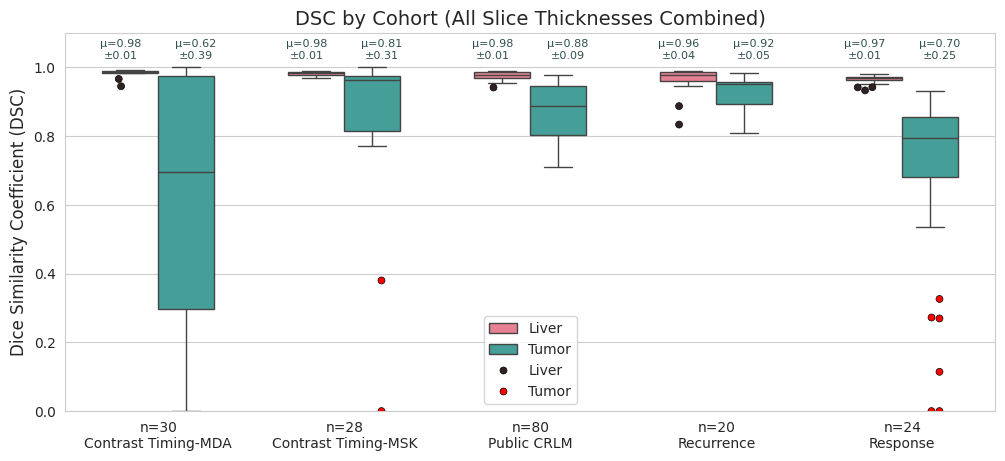

2025-01-27 18:02:21,426 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-01-27 18:02:21,430 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-01-27 18:02:21,484 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-01-27 18:02:21,488 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
/tmp/ipykernel_249326/2304747283.py:132: FutureWarning: The default of observed=False is deprecated and will

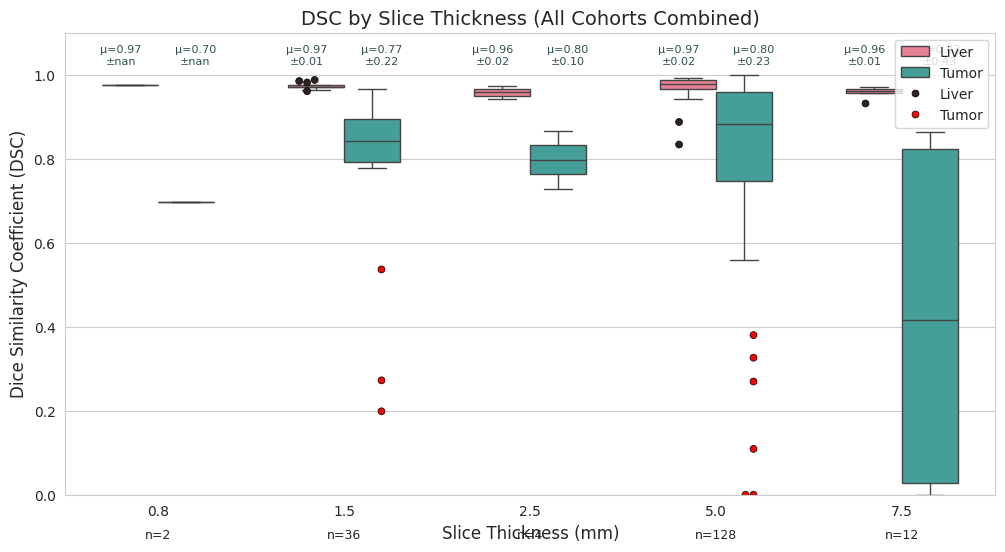

In [90]:
def create_cohort_based_plot(df: pd.DataFrame):
    """Create cohort-based plot with optimized label positioning."""
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    sns.set_palette("husl", n_colors=2)
    
    # Create boxplot
    ax = sns.boxplot(
        x="cohort", 
        y="DSC", 
        hue="Structure", 
        data=df, 
        width=0.6,
        showfliers=False
    )
    
    # Add outliers
    outliers_data = []
    for cohort in df["cohort"].unique():
        for structure in df["Structure"].unique():
            subset = df[(df["cohort"] == cohort) & (df["Structure"] == structure)]
            if subset.empty:
                continue
            Q1 = subset["DSC"].quantile(0.25)
            Q3 = subset["DSC"].quantile(0.75)
            IQR = Q3 - Q1
            outliers = subset[(subset["DSC"] < (Q1 - 1.5 * IQR)) | 
                             (subset["DSC"] > (Q3 + 1.5 * IQR))]
            outliers_data.extend(outliers.to_dict('records'))
    
    outliers_df = pd.DataFrame(outliers_data)
    if not outliers_df.empty:
        sns.swarmplot(
            x="cohort", 
            y="DSC", 
            hue="Structure", 
            data=outliers_df, 
            dodge=True, 
            palette="dark:red",
            size=5,
            edgecolor="black",
            linewidth=0.5
        )

    # Calculate mean and std for annotations
    stats_df = df.groupby(['cohort', 'Structure'])['DSC'].agg(['mean', 'std']).reset_index()
    
    # Annotate mean ± std
    for i, (cohort, structure) in enumerate(stats_df[['cohort', 'Structure']].values):
        mean = stats_df.loc[i, 'mean']
        std = stats_df.loc[i, 'std']
        
        cohort_idx = df['cohort'].unique().tolist().index(cohort)
        structure_offset = 0.2 if structure == "Tumor" else -0.2
        x_pos = cohort_idx + structure_offset
        
        ax.text(x_pos, 1.02, 
               f"μ={mean:.2f}\n±{std:.2f}", 
               ha='center', va='bottom',
               fontsize=8, color='darkslategray')

    plt.title("DSC by Cohort (All Slice Thicknesses Combined)", fontsize=14)
    plt.xlabel("")
    plt.ylabel("Dice Similarity Coefficient (DSC)", fontsize=12)
    plt.ylim(0, 1.1)
    
    # Create custom x-axis labels with cohort names below sample sizes
    cohort_counts = df.groupby('cohort').size()
    xtick_labels = [f"n={count}\n{cohort}" 
                   for cohort, count in cohort_counts.items()]
    
    ax.set_xticks(range(len(cohort_counts)))
    ax.set_xticklabels(xtick_labels, rotation=0, ha='center', fontsize=10)
    
    # Adjust plot margins to accommodate labels
    plt.subplots_adjust(bottom=0.25)
    
    # Legend handling
    handles, labels = ax.get_legend_handles_labels()
    handles.append(plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor='red', markersize=10, 
                            markeredgecolor='black'))
    ax.legend(handles, labels, loc="lower center")
    
    if SAVE_FIG:
        plt.savefig("dsc_by_cohort.png", dpi=300, bbox_inches="tight")
    
    plt.show()

# In your main execution:
if __name__ == "__main__":
    # Initialize data
    df = process_files(
        ref_dir='/mnt/largedrive3/mhamghalam/segPaper/labelsTs_r01',
        pred_dir="/mnt/largedrive3/mhamghalam/segPaper/ensembled_phase4"
    )
    
    # Add cohort mapping
    df['cohort'] = df['filename'].apply(map_to_cohort)
    
    # Generate separate plots
    create_cohort_based_plot(df)
    create_thickness_based_plot(df)

In [102]:
stats_df = df.groupby(['cohort', 'Structure'])['DSC'].agg(['mean', 'std']).unstack()

stats_df

mean                 std          
Structure               Liver     Tumor     Liver     Tumor
cohort                                                     
Contrast Timing-MDA  0.961040  0.924652  0.043796  0.052136
Contrast Timing-MSK  0.975589  0.875385  0.013382  0.092326
Public CRLM          0.966418  0.700142  0.010152  0.251473
Recurrence           0.982210  0.619051  0.014934  0.386972
Response             0.981484  0.808369  0.006985  0.307846

In [155]:
df.head()

,Slice Thickness (mm),DSC,Structure
0,5.0,0.990013,Liver
1,5.0,0.988724,Liver
2,5.0,0.992407,Liver
3,5.0,0.989599,Liver
4,5.0,0.966496,Liver


In [15]:
def create_cohort_based_plot(df: pd.DataFrame):
    """Create cohort-based plot with aligned statistics."""
    # Set professional style
    df = df.rename(columns={"Structure": "Target"})

    sns.set_theme(style="whitegrid", context="paper", font_scale=1.1)
    # plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['axes.spines.top'] = False
    plt.rcParams['axes.spines.right'] = False

    # Get plot order first
    plot_order = df['cohort'].unique()  # Preserve natural order
    
    # Convert to categorical to maintain order
    df['cohort'] = pd.Categorical(df['cohort'], categories=plot_order, ordered=True)
    
    # Calculate statistics using plot order
    stats_df = (df.groupby(['cohort', 'Target'])['DSC']
                .agg(['mean', 'std'])
                .unstack()
                .reindex(plot_order))  # Explicit ordering

    cohort_counts = df.groupby('cohort')['filename'].nunique()

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

        # Create boxplot with enforced order# Create boxplot
    sns.boxplot(
        x="cohort", 
        y="DSC", 
        hue="Target", 
        data=df, 
        palette="Blues_r",
        order=plot_order,  # Explicit order control
        showmeans=True,
        meanprops={'marker': 'D', 'markerfacecolor': 'white', 'markeredgecolor': 'k', 'markersize': 8},
        boxprops={'edgecolor': 'k', 'linewidth': 1.5},
        width=0.7,
        showfliers=False,
        ax=ax
    )

    # Add annotations using aligned statistics
    for cohort_idx, cohort in enumerate(plot_order):
        liver_mean = stats_df.loc[cohort, ('mean', 'Liver')]
        liver_std = stats_df.loc[cohort, ('std', 'Liver')]
        tumor_mean = stats_df.loc[cohort, ('mean', 'Tumor')]
        tumor_std = stats_df.loc[cohort, ('std', 'Tumor')]
        
        annotation_text = f"Liver: {liver_mean:.2f} ± {liver_std:.2f}\nTumor: {tumor_mean:.2f} ± {tumor_std:.2f}"
        
        ax.text(
            x=cohort_idx,
            y=0.05,
            s=annotation_text,
            ha='center',
            va='bottom',
            fontsize=9,
            color='black',
            bbox=dict(facecolor='white', alpha=0.9, edgecolor='none', boxstyle='round,pad=0.2')
        )

    # Add plot title
    plt.title("DSC by Cohort and Target", 
            fontsize=14, pad=20, fontweight='bold')

    # Save and show plot
    plt.savefig("dsc_by_cohort_phase4.png", dpi=300, bbox_inches="tight")
    plt.show()

    # Remaining formatting code unchanged...
    # Add mean 

# # In your main execution:
# if __name__ == "__main__":
#     # Initialize data
#     df = process_files(
#         ref_dir='/mnt/largedrive3/mhamghalam/segPaper/labelsTs_r01',
#         pred_dir="/mnt/largedrive3/mhamghalam/segPaper/ensembled_phase4"
#     )
    
#     # Add cohort mapping
#     df['cohort'] = df['filename'].apply(map_to_cohort)
    
#     # Generate combined plot
#     create_combined_cohort_thickness_plot(df)

# In your main execution:
if __name__ == "__main__":
    # Initialize data
    df = process_files(
        ref_dir='/mnt/largedrive3/mhamghalam/segPaper/labelsTs_r01',
        pred_dir="/mnt/largedrive3/mhamghalam/segPaper/ensembled_phase4"
                # pred_dir="/mnt/largedrive3/mhamghalam/segPaper/phase0_5folds"

    )
    
    # Add cohort mapping
    df['cohort'] = df['filename'].apply(map_to_cohort)
    
    # Generate separate plots
    create_cohort_based_plot(df)
    # create_thickness_based_plot(df)

NameError: name 'process_files' is not defined

In [105]:
stats_df = df.groupby(['cohort', 'Structure'])['DSC'].agg(['mean', 'std']).unstack()
cohort_counts = df.groupby('cohort')['filename'].nunique()
print(stats_df)

                         mean                 std          
Structure               Liver     Tumor     Liver     Tumor
cohort                                                     
Contrast Timing-MDA  0.961040  0.924652  0.043796  0.052136
Contrast Timing-MSK  0.975589  0.875385  0.013382  0.092326
Public CRLM          0.966418  0.700142  0.010152  0.251473
Recurrence           0.982210  0.619051  0.014934  0.386972
Response             0.981484  0.808369  0.006985  0.307846


In [147]:
df

,Slice Thickness (mm),DSC,Structure
0,5.0,0.990013,Liver
1,5.0,0.988724,Liver
2,5.0,0.992407,Liver
3,5.0,0.989599,Liver
4,5.0,0.966496,Liver
...,...,...,...
177,0.8,0.695832,Tumor
178,2.5,0.941995,Liver
179,2.5,0.974264,Liver
180,2.5,0.728153,Tumor


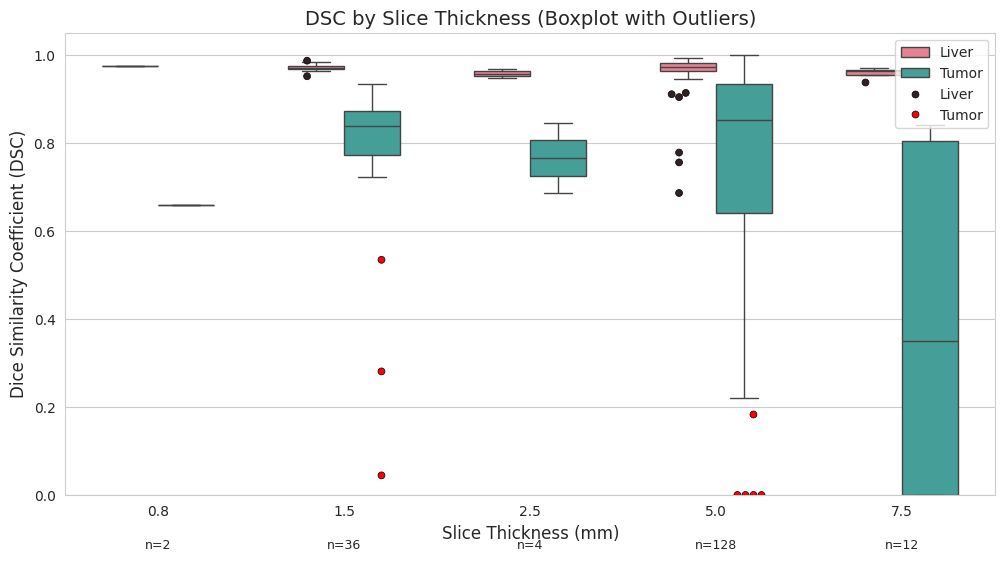

In [150]:
# OOD Test
import os
import numpy as np
import SimpleITK as sitk
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

# Configuration
SAVE_FIG = True

# --------------------------------------------
# Core Functions (No changes needed below here)
# --------------------------------------------

def dice_coefficient(y_true: np.ndarray, y_pred: np.ndarray, label_value: int) -> float:
    """Calculate Dice Similarity Coefficient for a specific label."""
    mask_true = (y_true == label_value).astype(int)
    mask_pred = (y_pred == label_value).astype(int)

    if np.sum(mask_true) + np.sum(mask_pred) == 0:
        return 1.0
    if np.sum(mask_true) == 0 or np.sum(mask_pred) == 0:
        return 0.0

    intersection = np.sum(mask_true & mask_pred)
    return (2.0 * intersection) / (np.sum(mask_true) + np.sum(mask_pred))

def process_files(ref_dir: str, pred_dir: str) -> pd.DataFrame:
    """Process files and return formatted DataFrame."""
    dsc_data = defaultdict(lambda: defaultdict(list))

    ref_files = sorted(f for f in os.listdir(ref_dir) if f.endswith(".nii.gz"))
    pred_files = sorted(f for f in os.listdir(pred_dir) if f.endswith(".nii.gz"))

    for ref_file, pred_file in zip(ref_files, pred_files):
        try:
            ref_img = sitk.ReadImage(os.path.join(ref_dir, ref_file))
            pred_img = sitk.ReadImage(os.path.join(pred_dir, pred_file))
            
            thickness = round(ref_img.GetSpacing()[2], 1)
            ref_array = sitk.GetArrayFromImage(ref_img)
            pred_array = sitk.GetArrayFromImage(pred_img)

            dsc_data[thickness]["Liver"].append(
                dice_coefficient(ref_array, pred_array, 1)
            )
            dsc_data[thickness]["Tumor"].append(
                dice_coefficient(ref_array, pred_array, 2)
            )
            
        except Exception as e:
            print(f"Error processing {ref_file}: {str(e)}")

    # Convert to DataFrame
    data = []
    for thickness, labels in dsc_data.items():
        for label, values in labels.items():
            data.extend([{"Slice Thickness (mm)": thickness, 
                         "DSC": v, 
                         "Structure": label} for v in values])
    
    df = pd.DataFrame(data)
    df["Slice Thickness (mm)"] = pd.Categorical(
        df["Slice Thickness (mm)"], 
        categories=sorted(df["Slice Thickness (mm)"].unique()), 
        ordered=True
    )
    
    return df

def create_boxplot_with_outliers(df: pd.DataFrame):
    """Create a boxplot with swarmplot overlay for outliers only."""
    plt.figure(figsize=(12, 6))
    sns.set_style("whitegrid")
    sns.set_palette("husl", n_colors=2)
    
    # Create the boxplot
    ax = sns.boxplot(
        x="Slice Thickness (mm)", 
        y="DSC", 
        hue="Structure", 
        data=df, 
        width=0.6,
        showfliers=False  # Hide default outliers
    )
    
    # Identify and plot outliers using swarmplot
    outliers_data = []
    for structure in df["Structure"].unique():
        for thickness in df["Slice Thickness (mm)"].cat.categories:
            subset = df[(df["Slice Thickness (mm)"] == thickness) & (df["Structure"] == structure)]
            if len(subset) > 0:
                # Calculate IQR
                Q1 = subset["DSC"].quantile(0.25)
                Q3 = subset["DSC"].quantile(0.75)
                IQR = Q3 - Q1
                
                # Define outliers
                outliers = subset[(subset["DSC"] < (Q1 - 1.5 * IQR)) | (subset["DSC"] > (Q3 + 1.5 * IQR))]
                outliers_data.extend(outliers.to_dict('records'))
    
    # Convert outliers to DataFrame
    outliers_df = pd.DataFrame(outliers_data)
    
    # Plot outliers using swarmplot
    if not outliers_df.empty:
        sns.swarmplot(
            x="Slice Thickness (mm)", 
            y="DSC", 
            hue="Structure", 
            data=outliers_df, 
            dodge=True, 
            palette="dark:red",  # Use gradient palette for red
            size=5,              # Increase size for visibility
            edgecolor="black",   # Add black border to points
            linewidth=0.5
        )
    
    plt.title("DSC by Slice Thickness (Boxplot with Outliers)", fontsize=14)
    plt.xlabel("Slice Thickness (mm)", fontsize=12)
    plt.ylabel("Dice Similarity Coefficient (DSC)", fontsize=12)
    plt.ylim(0, 1.05)
    
    # Add sample sizes
    for i, thickness in enumerate(df["Slice Thickness (mm)"].cat.categories):
        n = df[df["Slice Thickness (mm)"] == thickness].shape[0]
        plt.text(i, -0.1, f"n={n}", ha="center", va="top", fontsize=9)
    
    # Add legend for outliers
    handles, labels = ax.get_legend_handles_labels()
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, markeredgecolor='black'))
    # labels.append("Outliers")
    ax.legend(handles, labels, loc="upper right")
    
    if SAVE_FIG:
        plt.savefig("dsc_vs_thickness_boxplot_outliers.png", dpi=300, bbox_inches="tight")
    
    plt.show()

# ----------------------
# Main Execution
# ----------------------
if __name__ == "__main__":
    # Initialize data
    df = process_files(
        ref_dir='/mnt/largedrive3/mhamghalam/segPaper/labelsTs_r01',
        pred_dir="/mnt/largedrive3/mhamghalam/segPaper/phase0_5folds"
    )
    
    # Generate boxplot with outliers as swarmplot
    create_boxplot_with_outliers(df)

In [151]:
df

,Slice Thickness (mm),DSC,Structure
0,5.0,0.993015,Liver
1,5.0,0.987574,Liver
2,5.0,0.992368,Liver
3,5.0,0.989917,Liver
4,5.0,0.965890,Liver
...,...,...,...
177,0.8,0.658889,Tumor
178,2.5,0.947417,Liver
179,2.5,0.967967,Liver
180,2.5,0.685707,Tumor


In [149]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    x="Slice Thickness (mm)", 
    y="DSC", 
    hue="Label", 
    data=df, 
    width=0.6, 
    linewidth=1.5, 
    fliersize=5
)
sns.swarmplot(
    x="Slice Thickness (mm)", 
    y="DSC", 
    hue="Label", 
    data=df, 
    dodge=True, 
    color="black", 
    alpha=0.5
)
plt.title("Dice Similarity Coefficient (DSC) by Slice Thickness", fontsize=14, pad=20)
plt.xlabel("Slice Thickness (mm)", fontsize=12, labelpad=10)
plt.ylabel("DSC", fontsize=12, labelpad=10)
plt.ylim(0.0, 1.0)
plt.legend(title="Label", loc="upper right")
plt.savefig("dsc_vs_slice_thickness_box_swarm.png", dpi=300, bbox_inches="tight")
plt.show()

ValueError: Could not interpret value `Label` for `hue`. An entry with this name does not appear in `data`.

<Figure size 1000x600 with 0 Axes>

In [13]:
# import stats

confidence_interval = scipy.stats.t.interval(0.95, len(nsds_ensembled)-1, loc=np.mean(np.array(nsds_ensembled)), scale=scipy.stats.sem(nsds_ensembled))
confidence_interval

(0.9785620402246571, 0.9856367096195751)

In [19]:
aa = {}

In [25]:


dsc_voxel_spacing[round(voxel_spacing[2],1)].append(4)
print(dsc_voxel_spacing)

defaultdict(<class 'list'>, {1.5: [4]})


In [ ]:
phase4 results
# Stats for cohort Recurrence Prediction-MSK:
#   AURC: 24.757749207948105
#   Spearman Correlation: -0.3481640313802454
#   Pearson Correlation: -0.5573452218742668
#   Mean Ensembled DSC: 0.6190511309924606
#   Mean Ensembled NSD: 0.6332081419984779


# Stats for cohort Response Analysis-MSK:
#   AURC: 5.561580371809849
#   Spearman Correlation: -0.5594405594405596
#   Pearson Correlation: -0.8528131396940893
#   Mean Ensembled DSC: 0.8083686377342542
#   Mean Ensembled NSD: 0.839259039283013


# Stats for cohort Contrast Injection Timing-MSK:
#   AURC: 6.37833056140115
#   Spearman Correlation: -0.8681318681318682
#   Pearson Correlation: -0.7810016777245553
#   Mean Ensembled DSC: 0.8753847304795725
#   Mean Ensembled NSD: 0.9106475990985305


# Stats for cohort Contrast Injection Timing-MDA:
#   AURC: 4.064303592518042
#   Spearman Correlation: -0.9035714285714285
#   Pearson Correlation: -0.9169664061383692
#   Mean Ensembled DSC: 0.9246515301351714
#   Mean Ensembled NSD: 0.9418982769823737


# Stats for cohort TCIA-MSK:
#   AURC: 17.53248658324013
#   Spearman Correlation: -0.6782682122007412
#   Pearson Correlation: -0.8033902194612283
#   Mean Ensembled DSC: 0.7001415402577287
#   Mean Ensembled NSD: 0.7230976695353146


# NSD: 0.7934575518121819

In [211]:

# print(f"NSD: {np.mean(np.array(nsds_ensembled))}")

# tumor_dices = [0.9695,0.9694,0.969,0.9698,0.9494]

nsds_ensembled_p = [ x for x in nsds_ensembled if x!=1]
# Calculate mean
ab = nsds_ensembled
mean_nsd = np.mean(np.array(ab))

# Calculate 95% confidence interval
confidence_interval = ss.t.interval(0.95, len(ab)-1, loc=mean_nsd, scale=ss.sem(ab))
print(mean_nsd)
print(confidence_interval)


0.9293597238537387
(0.9159668704762844, 0.9427525772311929)


In [202]:
from scipy import stats as ss


In [201]:
stats

StatsCache(confids=array([1.        , 0.07291584, 1.        , 0.1       , 1.        ,
       0.58248984, 0.94539682, 0.17519813, 1.        , 0.90458228,
       0.94889987, 0.68644818, 0.92563378, 0.95621281, 0.95918146,
       1.        , 0.88097116, 0.96172667, 0.94372564, 0.89102709,
       0.91591723, 0.80724656, 0.92499599, 0.86092567, 0.91454541,
       0.82175894, 0.94803243, 0.96098705, 0.91714007, 0.95760224,
       0.84017289, 0.92811689, 0.92139022, 0.9358471 , 0.70963556,
       0.92693221, 0.92182871, 0.79954942, 0.90136255, 0.91297491,
       0.84515489, 0.8294127 , 0.91919518, 0.95177583, 0.91875138,
       0.92724372, 0.82680128, 0.94555778, 0.8833852 , 0.8372188 ,
       0.83845456, 0.37843137, 0.92812594, 0.93090466, 0.93538579,
       0.94335877, 0.88858915, 0.92448783, 0.93809797, 0.3       ,
       0.81635638, 0.95482314, 0.94847768, 0.68812262, 0.95596847,
       0.90927357, 0.93420202, 0.96002479, 0.92033244, 0.69911509,
       0.96651039, 0.94924347, 0.95000134, 

In [173]:
# Initialize lists for global metrics (without considering cohort)
global_risk_values = []
global_confidence_values = []
global_dscs_ensembled = []

# Initialize dictionaries to store risk, confidence values, and ensembled DSC per cohort
cohort_risk_values = {}
cohort_confidence_values = {}
cohort_ensembled_dsc_values = {}

# Loop over all reference files and ensembled files
for ref_file, ensembled_file in zip(ref_files, ensembled_files):
    
    # Load reference image
    ref_path = os.path.join(ref_dir, ref_file)
    ref_img = sitk.ReadImage(ref_path)
    ref_array = sitk.GetArrayFromImage(ref_img)
    
    # Load ensembled prediction image
    ensembled_path = os.path.join(ensembled_dir, ensembled_file)
    ensembled_img = sitk.ReadImage(ensembled_path)
    ensembled_array = sitk.GetArrayFromImage(ensembled_img)
    
    # Calculate DSC for the ensembled prediction (focus on tumor label 2)
    dsc_ensembled = dice_coefficient(ref_array, ensembled_array, label_value=2)
    
    # Calculate risk as (1 - DSC)
    risk_value = 1.0 - dsc_ensembled
    
    # Calculate tumor volume (number of voxels labeled as 2)
    tumor_volume = np.sum(ref_array == 2)
    
    # Get voxel spacing (slice thickness)
    voxel_spacing = ref_img.GetSpacing()
    
    # Load all predictions for the current file
    pred_arrays = []
    tumor_volumes = []  # To store the tumor volume for each prediction
    avg_tumor_volumes = []  # To store the average tumor volumes for each prediction
    
    for pred_dir in pred_dirs:
        pred_file = os.path.join(pred_dir, ref_file)
        pred_img = sitk.ReadImage(pred_file)
        pred_array = sitk.GetArrayFromImage(pred_img)
        pred_arrays.append(pred_array)
        
        # Calculate tumor volumes
        total_tumor_volume, avg_tumor_volume = detect_tumors_with_volumes(pred_array, voxel_spacing)
        tumor_volumes.append(total_tumor_volume)
        avg_tumor_volumes.append(avg_tumor_volume)
    
    # Calculate pairwise DSC for the tumor label (2), weighted by average tumor volume
    num_preds = len(pred_arrays)
    weighted_pairwise_dscs = []
    avg_tumor_volume_global = np.mean(avg_tumor_volumes)  # Average tumor volume for weighting
    
    for i in range(num_preds):
        for j in range(i + 1, num_preds):
            dsc = dice_coefficient(pred_arrays[i], pred_arrays[j], label_value=2)
            avg_vol_ij = (avg_tumor_volumes[i] + avg_tumor_volumes[j]) / 2  # Average tumor volume for this pair
            
            # Penalize confidence if the average volume is small
            penalization_factor = avg_vol_ij / avg_tumor_volume_global if avg_tumor_volume_global > 0 else 1.0
            
            # Weight by tumor volume (lower weight for small average volumes)
            weighted_pairwise_dscs.append(dsc * penalization_factor)
    
    # Calculate the mean weighted pairwise DSC for the current image (confidence score)
    if len(weighted_pairwise_dscs) > 0:
        avg_weighted_pairwise_dsc = np.mean(weighted_pairwise_dscs)
    else:
        avg_weighted_pairwise_dsc = 0.0
    
    # Scale confidence based on tumor size (penalize small tumors)
    tumor_size_scaling_factor = scale_confidence_based_on_tumor_size(np.mean(tumor_volumes))
    
    # Apply penalty for low-resolution images based on z-axis spacing
    voxel_spacing_penalty_factor = penalize_based_on_voxel_spacing(voxel_spacing)
    
    # Adjust confidence by tumor size scaling and voxel spacing penalty
    scaled_confidence = avg_weighted_pairwise_dsc * tumor_size_scaling_factor * voxel_spacing_penalty_factor
    
    # Add to global metrics (without considering cohort)
    global_risk_values.append(risk_value)
    global_confidence_values.append(scaled_confidence)
    global_dscs_ensembled.append(dsc_ensembled)
    
    # Now collect cohort-based metrics
    cohort = map_to_cohort(ref_file)
    
    # Update cohort-specific metrics
    if cohort not in cohort_risk_values:
        cohort_risk_values[cohort] = []
        cohort_confidence_values[cohort] = []
        cohort_ensembled_dsc_values[cohort] = []
    
    cohort_risk_values[cohort].append(risk_value)
    cohort_confidence_values[cohort].append(scaled_confidence)
    cohort_ensembled_dsc_values[cohort].append(dsc_ensembled)

# After the loop, calculate the global metrics (mean across all samples)
global_mean_risk = np.mean(global_risk_values)
global_mean_confidence = np.mean(global_confidence_values)
global_mean_dsc_ensembled = np.mean(global_dscs_ensembled)

# Print the global metrics
print(f"Global Metrics (Without Considering Cohort):")
print(f"Mean Risk: {global_mean_risk}")
print(f"Mean Confidence: {global_mean_confidence}")
print(f"Mean Dice Score (Ensembled): {global_mean_dsc_ensembled}")


Global Metrics (Without Considering Cohort):
Mean Risk: 0.276722627061974
Mean Confidence: 0.9594600897346162
Mean Dice Score (Ensembled): 0.7232773729380262


In [172]:
# Initialize dictionaries to store risk, confidence values, and ensembled DSC per cohort
cohort_risk_values = {}
cohort_confidence_values = {}
cohort_ensembled_dsc_values = {}  # To store ensembled DSC for each cohort

# Loop over all reference files and ensembled files
for ref_file, ensembled_file in zip(ref_files, ensembled_files):
    
    # Load reference image
    ref_path = os.path.join(ref_dir, ref_file)
    ref_img = sitk.ReadImage(ref_path)
    ref_array = sitk.GetArrayFromImage(ref_img)
    
    # Load ensembled prediction image
    ensembled_path = os.path.join(ensembled_dir, ensembled_file)
    ensembled_img = sitk.ReadImage(ensembled_path)
    ensembled_array = sitk.GetArrayFromImage(ensembled_img)
    
    # Calculate DSC for the ensembled prediction (focus on tumor label 2)
    dsc_ensembled = dice_coefficient(ref_array, ensembled_array, label_value=2)
    
    # Calculate risk as (1 - DSC)
    risk_value = 1.0 - dsc_ensembled
    
    # Load all predictions for the current file
    pred_arrays = []
    for pred_dir in pred_dirs:
        pred_file = os.path.join(pred_dir, ref_file)
        pred_img = sitk.ReadImage(pred_file)
        pred_array = sitk.GetArrayFromImage(pred_img)
        pred_arrays.append(pred_array)
    
    # Calculate pairwise DSC for the tumor label (2)
    num_preds = len(pred_arrays)
    pairwise_dscs = []
    
    for i in range(num_preds):
        for j in range(i + 1, num_preds):
            dsc = dice_coefficient(pred_arrays[i], pred_arrays[j], label_value=2)
            pairwise_dscs.append(dsc)
    
    # Calculate the mean pairwise DSC for the current image (confidence score)
    avg_pairwise_dsc = np.mean(pairwise_dscs)
    
    # Determine the cohort for this sample
    cohort = map_to_cohort(ref_file)
    
    # Initialize lists for the cohort if not already done
    if cohort not in cohort_risk_values:
        cohort_risk_values[cohort] = []
        cohort_confidence_values[cohort] = []
        cohort_ensembled_dsc_values[cohort] = []  # Initialize for ensembled DSC

    # Append the risk, confidence, and ensembled DSC values to the corresponding cohort
    cohort_risk_values[cohort].append(risk_value)
    cohort_confidence_values[cohort].append(avg_pairwise_dsc)
    cohort_ensembled_dsc_values[cohort].append(dsc_ensembled)  # Store ensembled DSC

# Function to calculate stats for each cohort
def calculate_stats_for_cohort(risk_values, confidence_values, ensembled_dsc_values):
    risk_array = np.array(risk_values)
    confidence_array = np.array(confidence_values)
    ensembled_dsc_array = np.array(ensembled_dsc_values)
    
    stats = StatsCache(confids=confidence_array, risks=risk_array)
    aurc_values = get_metric_function("aurc")(stats)
    
    spearman_corr = scipy.stats.spearmanr(confidence_array, risk_array).statistic
    pearson_corr = scipy.stats.pearsonr(confidence_array, risk_array).statistic
    
    # Calculate mean ensembled DSC for this cohort
    mean_ensembled_dsc = np.mean(ensembled_dsc_array)
    
    return aurc_values * 100, spearman_corr, pearson_corr, mean_ensembled_dsc

# Calculate stats for each cohort
for cohort, risks in cohort_risk_values.items():
    confids = cohort_confidence_values[cohort]
    ensembled_dscs = cohort_ensembled_dsc_values[cohort]  # Get ensembled DSC for cohort
    
    aurc, spearman_corr, pearson_corr, mean_ensembled_dsc = calculate_stats_for_cohort(risks, confids, ensembled_dscs)
    
    print(f"Stats for cohort {cohort}:")
    print(f"  AURC: {aurc}")
    print(f"  Spearman Correlation: {spearman_corr}")
    print(f"  Pearson Correlation: {pearson_corr}")
    print(f"  Mean Ensembled DSC: {mean_ensembled_dsc}")
    print("\n")


Stats for cohort Recurrence Prediction-MSK:
  AURC: 31.399936320672527
  Spearman Correlation: -0.5556255556258334
  Pearson Correlation: -0.5902736304197709
  Mean Ensembled DSC: 0.5105902687639562


Stats for cohort Response Analysis-MSK:
  AURC: 6.379460172263805
  Spearman Correlation: -0.9300699300699302
  Pearson Correlation: -0.5805702704400256
  Mean Ensembled DSC: 0.7932535646327284


Stats for cohort Contrast Injection Timing-MSK:
  AURC: 8.733240906675
  Spearman Correlation: -0.6791208791208792
  Pearson Correlation: -0.5485809847658949
  Mean Ensembled DSC: 0.8553126229717607


Stats for cohort Contrast Injection Timing-MDA:
  AURC: 8.388582749589354
  Spearman Correlation: -0.7857142857142856
  Pearson Correlation: -0.9139746356825244
  Mean Ensembled DSC: 0.8175144506985647


Stats for cohort TCIA-MSK:
  AURC: 27.556240608105615
  Spearman Correlation: -0.4804317750936161
  Pearson Correlation: -0.5755013536593183
  Mean Ensembled DSC: 0.6739050498011236




In [153]:
import numpy as np
import SimpleITK as sitk
import pandas as pd
import os
from scipy import ndimage
from scipy.stats import spearmanr, pearsonr
from segmentation_failures.evaluation.failure_detection.metrics import StatsCache, get_metric_function

# Function to calculate Dice Similarity Coefficient (DSC) for a given label (e.g., tumor)
def dice_coefficient(y_true, y_pred, label_value=2):
    y_true = (y_true == label_value).flatten()
    y_pred = (y_pred == label_value).flatten()
    
    true_sum = np.sum(y_true)
    pred_sum = np.sum(y_pred)
    
    if true_sum == 0 and pred_sum == 0:
        return 1.0  # No tumor in both, perfect match
    elif true_sum == 0 or pred_sum == 0:
        return 0.0  # One has no tumor, the other does
    
    intersection = np.sum(y_true & y_pred)
    return 2.0 * intersection / (true_sum + pred_sum)

# Function to detect tumors and calculate their real-world volumes
def detect_tumors_with_volumes(y_pred, voxel_spacing):
    tumor_voxels = (y_pred == 2).astype(np.int32)
    labeled_image, num_tumors = ndimage.label(tumor_voxels)
    
    tumor_volumes = []
    
    for tumor_label in range(1, num_tumors + 1):
        tumor_size_voxels = np.sum(labeled_image == tumor_label)
        tumor_volume = tumor_size_voxels * np.prod(voxel_spacing)  # Convert to mm³
        tumor_volumes.append(tumor_volume)
    
    total_tumor_volume = np.sum(tumor_volumes)
    average_tumor_volume = np.mean(tumor_volumes) if len(tumor_volumes) > 0 else 0.0
    
    return total_tumor_volume, average_tumor_volume

# Function to map filenames to cohorts
def map_to_cohort(filename): 
    if "010A_000" in filename:
        return "Recurrence Prediction-MSK"  # aim1.1
    elif "010C_000" in filename:
        return "Response Analysis-MSK"  # aim1.2
    elif "010_002" in filename:
        return "Contrast Injection Timing-MDA"  # aim2
    elif "mcrc" in filename:
        return "TCIA-MSK"  # public
    else:
        return "Contrast Injection Timing-MSK"  # aim2

# Directories for the predictions and ensembled prediction
pred_dirs = [
    "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f0",
    "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f1",
    "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f2",
    "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f3",
    "/mnt/largedrive3/mhamghalam/segPaper/OUTPUT_phase4_f4"
]

ensembled_dir = "/mnt/largedrive3/mhamghalam/segPaper/ensembled_phase4"
ref_dir = '/mnt/largedrive3/mhamghalam/segPaper/labelsTs_r01'

# Collect list of .nii.gz files from the reference folder
ref_files = sorted([f for f in os.listdir(ref_dir) if f.endswith(".nii.gz")])
ensembled_files = sorted([f for f in os.listdir(ensembled_dir) if f.endswith(".nii.gz")])

# Initialize lists to store results
risk_values = []
confidence_values = []
results = []

# Loop over all reference files and ensembled files
for ref_file, ensembled_file in zip(ref_files, ensembled_files):
    
    # Load reference image
    ref_path = os.path.join(ref_dir, ref_file)
    ref_img = sitk.ReadImage(ref_path)
    ref_array = sitk.GetArrayFromImage(ref_img)
    
    # Load ensembled prediction image
    ensembled_path = os.path.join(ensembled_dir, ensembled_file)
    ensembled_img = sitk.ReadImage(ensembled_path)
    ensembled_array = sitk.GetArrayFromImage(ensembled_img)
    
    # Get voxel spacing from image header (real-world dimensions in mm)
    voxel_spacing = ref_img.GetSpacing()

    # Calculate DSC for the ensembled prediction (focus on tumor label 2)
    dsc_ensembled = dice_coefficient(ref_array, ensembled_array, label_value=2)
    
    # Calculate risk as (1 - DSC)
    risk_value = 1.0 - dsc_ensembled
    risk_values.append(risk_value)

    # Load all predictions for the current file
    pred_arrays = []
    tumor_volumes = []  # To store the tumor volume for each prediction
    avg_tumor_volumes = []  # To store the average tumor volumes for each prediction
    
    for pred_dir in pred_dirs:
        pred_file = os.path.join(pred_dir, ref_file)
        pred_img = sitk.ReadImage(pred_file)
        pred_array = sitk.GetArrayFromImage(pred_img)
        pred_arrays.append(pred_array)
        
        # Calculate tumor volumes
        total_tumor_volume, avg_tumor_volume = detect_tumors_with_volumes(pred_array, voxel_spacing)
        tumor_volumes.append(total_tumor_volume)
        avg_tumor_volumes.append(avg_tumor_volume)
    
    # Calculate pairwise DSC for the tumor label (2), weighted by average tumor volume
    num_preds = len(pred_arrays)
    weighted_pairwise_dscs = []
    avg_tumor_volume_global = np.mean(avg_tumor_volumes)  # Average tumor volume for weighting
    
    for i in range(num_preds):
        for j in range(i + 1, num_preds):
            dsc = dice_coefficient(pred_arrays[i], pred_arrays[j], label_value=2)
            avg_vol_ij = (avg_tumor_volumes[i] + avg_tumor_volumes[j]) / 2  # Average tumor volume for this pair
            
            # Penalize confidence if the average volume is small
            penalization_factor = avg_vol_ij / avg_tumor_volume_global if avg_tumor_volume_global > 0 else 1.0
            
            # Weight by tumor volume (lower weight for small average volumes)
            weighted_pairwise_dscs.append(dsc * penalization_factor)
    
    # Calculate the mean weighted pairwise DSC for the current image (confidence score)
    if len(weighted_pairwise_dscs) > 0:
        avg_weighted_pairwise_dsc = np.mean(weighted_pairwise_dscs)
    else:
        avg_weighted_pairwise_dsc = 0.0

    # Store results in the list for tracking
    results.append({
        'Name': ref_file,
        'Cohort': map_to_cohort(ref_file),
        'Risk (1 - DSC)': risk_value,
        'Confidence (Weighted Pairwise DSC)': avg_weighted_pairwise_dsc
    })

# Convert the results into a pandas DataFrame
df_results = pd.DataFrame(results)

# Group by cohort and calculate statistics
grouped_results = df_results.groupby('Cohort').agg({
    'Risk (1 - DSC)': ['mean', 'std'],
    'Confidence (Weighted Pairwise DSC)': ['mean', 'std']
})

# Calculate AURC, Spearman, and Pearson for each group
spearman_results = df_results.groupby('Cohort').apply(lambda x: spearmanr(x['Risk (1 - DSC)'], x['Confidence (Weighted Pairwise DSC)'])[0])
pearson_results = df_results.groupby('Cohort').apply(lambda x: pearsonr(x['Risk (1 - DSC)'], x['Confidence (Weighted Pairwise DSC)'])[0])

# Add Spearman and Pearson results to the grouped stats
grouped_results['Spearman Correlation'] = spearman_results
grouped_results['Pearson Correlation'] = pearson_results

# Save the grouped results to a CSV file
grouped_results.to_csv('grouped_stats.csv')

# Display the grouped results for review
print(grouped_results)


                              Risk (1 - DSC)            \
                                        mean       std   
Cohort                                                   
Contrast Injection Timing-MDA       0.075348  0.052136   
Contrast Injection Timing-MSK       0.124615  0.092326   
Recurrence Prediction-MSK           0.380949  0.386972   
Response Analysis-MSK               0.191631  0.307846   
TCIA-MSK                            0.299858  0.251473   

                              Confidence (Weighted Pairwise DSC)            \
                                                            mean       std   
Cohort                                                                       
Contrast Injection Timing-MDA                           0.955347  0.037057   
Contrast Injection Timing-MSK                           0.941446  0.039799   
Recurrence Prediction-MSK                               0.751640  0.294151   
Response Analysis-MSK                                   0.887855  0

/tmp/ipykernel_3476065/2659017447.py:155: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  spearman_results = df_results.groupby('Cohort').apply(lambda x: spearmanr(x['Risk (1 - DSC)'], x['Confidence (Weighted Pairwise DSC)'])[0])
/tmp/ipykernel_3476065/2659017447.py:156: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pearson_results = df_results.groupby('Cohort').apply(lambda x: pearsonr(x['Risk (1 - DSC)'], x

In [254]:
import os
import numpy as np
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

# Define paths
phase0_pred_dir = "/mnt/largedrive3/mhamghalam/segPaper/phase0_5folds"
phase4_pred_dir = "/mnt/largedrive3/mhamghalam/segPaper/ensembled_phase4"
ref_dir = '/mnt/largedrive3/mhamghalam/segPaper/labelsTs_r01'
# labelsTs_r01
# Cohort mapping function
def map_to_cohort(test_value):
    if "010A_000" in test_value:
        return "Recurrence-MSK"
    elif "010C_000" in test_value:
        return "Response-MSK"
    elif "010_002" in test_value:
        return "Contrast Timing-MDA"
    elif "mcrc" in test_value:
        return "TCIA-MSK"
    else:
        return "Contrast Timing-MSK"

# Metric calculation functions (assuming these are defined elsewhere)
# Function to calculate Dice Similarity Coefficient (DSC) for a given label (e.g., tumor)
def dice_coefficient(y_true, y_pred, label_value=2):
    y_true = (y_true == label_value).flatten()
    y_pred = (y_pred == label_value).flatten()
    
    true_sum = np.sum(y_true)
    pred_sum = np.sum(y_pred)
    
    if true_sum == 0 and pred_sum == 0:
        return 1.0  # No tumor in both, perfect match
    elif true_sum == 0 or pred_sum == 0:
        return 0.0  # One has no tumor, the other does
    
    intersection = np.sum(y_true & y_pred)
    return 2.0 * intersection / (true_sum + pred_sum)

# def normalized_surface_dice(a, b, spacing, connectivity, label_value, threshold):
#     # Your implementation here
#     pass

# Initialize data collection structure
metrics = []
columns = ['Phase', 'Cohort', 'Label', 'DSC', 'NSD', 'Sample']
voxel_spacing = None  # Will be extracted from first reference image
cnt = 0
processed_samples = 0
max_samples = 91
# Process predictions for both phases# Process predictions for both phases
for phase, pred_dir in [(0, phase0_pred_dir), (4, phase4_pred_dir)]:
    for pred_path in glob(os.path.join(pred_dir, '*.nii.gz')):
        base_name = os.path.basename(pred_path)
        ref_path = os.path.join(ref_dir, base_name)
        cnt = cnt = cnt + 1
        print(phase, cnt)
        if not os.path.exists(ref_path):
            print(f"Warning: Missing reference for {base_name}")
            continue
            
        try:
            # Load images
            ref_img = nib.load(ref_path)
            pred_img = nib.load(pred_path)
            ref_array = ref_img.get_fdata()
            pred_array = pred_img.get_fdata()
            
            # Get voxel spacing FOR THIS SPECIFIC SCAN
            current_spacing = ref_img.header.get_zooms()  # Changed here
            
            # Calculate metrics for each label
            for label in [1, 2]:
                dsc = dice_coefficient(ref_array, pred_array, label)
                nsd = normalized_surface_dice(
                    ref_array, pred_array, 
                    spacing=current_spacing,  # Use current scan's spacing
                    connectivity=1,
                    label_value=label,
                    threshold=3
                )
                
                metrics.append([
                    phase,
                    map_to_cohort(base_name),
                    'Liver' if label == 1 else 'Tumor',
                    dsc,
                    nsd,
                    base_name
                ])
            processed_samples += 1
            print(f"Processed sample {processed_samples}/{max_samples}: {base_name}")
        except Exception as e:
            print(f"Error processing {base_name}: {str(e)}")
            continue
    processed_samples += 1
    print(f"Processed sample {processed_samples}/{max_samples}: {base_name}")
# Create DataFrame
df = pd.DataFrame(metrics, columns=columns)

# Visualization function
def plot_metrics(metric, label_type):
    plt.figure(figsize=(14, 8))
    sns.set(style="whitegrid", font_scale=1.2)
    
    ax = sns.boxplot(
        x='Cohort',
        y=metric,
        hue='Phase',
        data=df[df['Label'] == label_type],
        palette="Set2",
        showfliers=False
    )
    
    plt.title(f'{metric} Comparison for {label_type} Segmentation', fontsize=16)
    plt.ylabel(metric, fontsize=14)
    plt.xlabel('Cohort', fontsize=14)
    plt.ylim(0, 1 if metric == 'DSC' else None)
    plt.xticks(rotation=45)
    plt.legend(title='Training Phase')
    plt.tight_layout()
    plt.savefig(f'{metric}_{label_type}_comparison.png', dpi=300)
    plt.close()

# Generate all plots
for metric in ['DSC', 'NSD']:
    for label_type in ['Liver', 'Tumor']:
        plot_metrics(metric, label_type)

# Save results
df.to_csv('phase_comparison_metrics_3mm.csv', index=False)
print("Analysis complete. Results saved to CSV and PNG files.")

0 1
Processed sample 1/91: mcrc_106.nii.gz
0 2
Processed sample 2/91: mcrc_105.nii.gz
0 3
Processed sample 3/91: RIA_17-010_002_041_clinical_500_20.nii.gz
0 4
Processed sample 4/91: RIA_17-010A_000_389_2.nii.gz
0 5
Processed sample 5/91: mcrc_090.nii.gz
0 6
Processed sample 6/91: RIA_17-010A_000_459_5.nii.gz
0 7
Processed sample 7/91: mcrc_062.nii.gz
0 8
Processed sample 8/91: RIA_17-010_002_042_clinical_500_20.nii.gz
0 9
Processed sample 9/91: mcrc_198.nii.gz
0 10
Processed sample 10/91: mcrc_311.nii.gz
0 11
Processed sample 11/91: mcrc_049.nii.gz
0 12
Processed sample 12/91: mcrc_102.nii.gz
0 13
Processed sample 13/91: mcrc_169.nii.gz
0 14
Processed sample 14/91: mcrc_288.nii.gz
0 15
Processed sample 15/91: RIA_17-010_002_050_clinical_500_20.nii.gz
0 16
Processed sample 16/91: RIA_17_Subject029_clinical_500_20.nii.gz
0 17
Processed sample 17/91: mcrc_146.nii.gz
0 18
Processed sample 18/91: mcrc_098.nii.gz
0 19
Processed sample 19/91: RIA_17_Subject033_clinical_500_20.nii.gz
0 20
Proc

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set professional font (e.g., Times New Roman)
# plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Create "All Cohorts" category
df_all = df.copy()
df_all['Cohort'] = 'All Cohorts'
combined_df = pd.concat([df, df_all])

# Map phase numbers to labels
combined_df['Phase'] = combined_df['Phase'].map({0: 'Phase 0', 4: 'Phase 4'})

def create_journal_plot(metric, label_type):
    plt.figure(figsize=(8, 5), dpi=300)
    ax = sns.boxplot(
        x='Cohort',
        y=metric,
        hue='Phase',
        data=combined_df[combined_df['Label'] == label_type],
        palette="Set2",
        showfliers=False,
        width=0.7,
        linewidth=1
    )
    
    # Add swarmplot overlay
    sns.swarmplot(
        x='Cohort',
        y=metric,
        hue='Phase',
        data=combined_df[combined_df['Label'] == label_type],
        palette="Set2",
        edgecolor='black',
        linewidth=0.5,
        size=4,
        dodge=True,
        ax=ax
    )
    
    # Formatting
    plt.title(f'{metric} Comparison - {label_type}', fontweight='bold', pad=12)
    plt.ylabel(f'{metric} Score', fontweight='semibold')
    plt.xlabel('Cohort', fontweight='semibold')
    plt.xticks(rotation=45, ha='center')
    
    # Set y-axis limits
    ymin = combined_df[metric].min() - 0.05
    ymax = 1.05 if metric == 'DSC' else combined_df[metric].max() + 0.05
    plt.ylim(max(ymin, 0), ymax)
    
    # Legend handling
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2], title='Training Phase', 
             frameon=True, loc='upper right')
    
    # Grid customization
    ax.yaxis.grid(True, linestyle='--', alpha=0.6)
    ax.xaxis.grid(False)
    
    # Remove spines
    sns.despine(top=True, right=True)
    
    plt.tight_layout()
    plt.savefig(f'Journal_{metric}_{label_type}.png', bbox_inches='tight')
    plt.close()

# Generate plots for both metrics and labels
for metric in ['DSC', 'NSD']:
    for label_type in ['Liver', 'Tumor']:
        create_journal_plot(metric, label_type)

# Save final results
combined_df.to_csv('Final_Phase_Comparison_Metrics_3mm.csv', index=False)

NameError: name 'df' is not defined

In [1]:
import pandas as pd
combined_df = pd.read_csv('Final_Phase_Comparison_Metrics_3mm.csv')


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set professional styling
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 11
})
sns.set_style("whitegrid")

# Create figure
fig = plt.figure(figsize=(10, 8), dpi=300)
subfigs = fig.subfigures(2, 1, height_ratios=[1, 1], hspace=0.05)

# Create subplot grids
axs0 = subfigs[0].subplots(1, 2, gridspec_kw={'wspace': 0.15})
axs1 = subfigs[1].subplots(1, 2, gridspec_kw={'wspace': 0.15})

# Configure plot parameters
plot_params = {
    'palette': 'Set2',
    'hue_order': ['Phase 0', 'Phase 4'],
    'linewidth': 0.5,
    'errwidth': 1,
    'dodge': True
}

# Create DSC plots
for ax, label_type in zip(axs0, ['Liver', 'Tumor']):
    sns.pointplot(
        x='Cohort', 
        y='DSC', 
        hue='Phase',
        data=combined_df[combined_df['Label'] == label_type],
        join=False,
        ax=ax,
        **plot_params
    )
    ax.set_title(f'DSC - {label_type}', pad=10)
    ax.set_xlabel('')
    ax.set_ylim(0, 1.05)
    ax.tick_params(axis='x', rotation=45)
    
    if label_type == 'Liver':
        ax.legend().remove()
    else:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, title='Phase', 
                 bbox_to_anchor=(1.02, 1), loc='upper left')

# Create NSD plots
for ax, label_type in zip(axs1, ['Liver', 'Tumor']):
    sns.pointplot(
        x='Cohort', 
        y='NSD', 
        hue='Phase',
        data=combined_df[combined_df['Label'] == label_type],
        join=False,
        ax=ax,
        **plot_params
    )
    ax.set_title(f'NSD - {label_type}', pad=10)
    ax.set_xlabel('Cohort', labelpad=10)
    ax.set_ylim(combined_df['NSD'].min()-0.05, combined_df['NSD'].max()+0.05)
    ax.tick_params(axis='x', rotation=45)
    ax.legend().remove()

# Add common elements
subfigs[0].suptitle('Dice Similarity Coefficient (DSC)', y=1.02, weight='bold')
subfigs[1].suptitle('Normalized Surface Dice (NSD)', y=1.02, weight='bold')

# Final layout adjustments
plt.tight_layout()
plt.savefig('Journal_Combined_Results_Optimized_3mm.png', 
           bbox_inches='tight', 
           pad_inches=0.3)
plt.close()

/tmp/ipykernel_1480846/307776464.py:32: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(
/tmp/ipykernel_1480846/307776464.py:32: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(
/tmp/ipykernel_1480846/307776464.py:32: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(
/tmp/ipykernel_1480846/307776464.py:32: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(
/tmp/ipykernel_1480846/307776464.py:55: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(
/tmp/ipykern

In [10]:
# Replace phase 0 with phase 1 and phase 4 with phase 5
# Replace "Phase 0" with "Phase 1" and "Phase 4" with "Phase 5"
combined_df['Phase'] = combined_df['Phase'].replace({'Phase 0': 'Phase 1', 'Phase 4': 'Phase 5'})

combined_df.head()

,Phase,Cohort,Label,DSC,NSD,Sample
0,Phase 1,TCIA-MSK,Liver,0.978196,0.964375,mcrc_106.nii.gz
1,Phase 1,TCIA-MSK,Tumor,0.745277,0.790990,mcrc_106.nii.gz
2,Phase 1,TCIA-MSK,Liver,0.975775,0.981737,mcrc_105.nii.gz
3,Phase 1,TCIA-MSK,Tumor,0.658889,0.749151,mcrc_105.nii.gz
4,Phase 1,Contrast Timing-MDA,Liver,0.955662,0.892006,RIA_17-010_002_041_clinical_500_20.nii.gz


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Set professional styling
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")

# Create figure with GridSpec for better control
fig = plt.figure(figsize=(10, 12), dpi=300)
gs = GridSpec(4, 1, height_ratios=[1,1,1,1], hspace=0.4)

# Create subplots
axs = [fig.add_subplot(gs[i]) for i in range(4)]

# Abbreviate cohort names for compactness
cohort_abbreviations = {
    'Recurrence-MSK': 'Recurrence',
    'Response-MSK': 'Response',
    'Contrast Timing-MDA': 'ContTime-MDA',
    'Contrast Timing-MSK': 'ContTime-MSK',
    'TCIA-MSK': 'TCIA',
    'All Cohorts': 'All'
}
combined_df['Cohort'] = combined_df['Cohort'].map(cohort_abbreviations)

# Common parameters
plot_kws = {
    'palette': 'Set2',
    'showfliers': False,
    'linewidth': 1,
    'width': 0.7
}

for idx, (metric, label_type) in enumerate([(m, l) 
                                          for m in ['DSC', 'NSD'] 
                                          for l in ['Liver', 'Tumor']]):
    ax = axs[idx]
    
    # Create plot
    sns.boxplot(
        x='Cohort',
        y=metric,
        hue='Phase',
        data=combined_df[combined_df['Label'] == label_type],
        **plot_kws,
        ax=ax
    )
    
    # Add swarmplot
    sns.swarmplot(
        x='Cohort',
        y=metric,
        hue='Phase',
        data=combined_df[combined_df['Label'] == label_type],
        palette="Set2",
        edgecolor='black',
        linewidth=0.5,
        size=4,
        dodge=True,
        ax=ax
    )
    
    # Configure axes
    ax.set_title(f'{metric} - {label_type}', fontweight='bold', pad=10)
    ax.set_ylabel(f'{metric} Score' if idx%2==0 else '')
    ax.set_xlabel('')
    
    # Rotate x-axis labels (30° instead of 45°)
    ax.tick_params(axis='x', rotation=30, labelsize=9)
    
    # Remove redundant legends
    if idx > 0:
        ax.get_legend().remove()
    else:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[:2], labels[:2], title='Phase',
                 bbox_to_anchor=(1, 1), loc='upper left')

# Add common x-axis label
fig.text(0.5, 0.08, 'Cohort', ha='center', va='center', fontweight='semibold')

# Final adjustments
plt.suptitle("Segmentation Performance Comparison", y=0.98, fontsize=12, fontweight='bold')
plt.tight_layout(rect=[0, 0.05, 1, 0.98])  # Make space for bottom label

# Save unified figure
plt.savefig('Optimized_Combined_Results_3mm.png', bbox_inches='tight')
plt.close()

/mnt/largedrive3/mhamghalam/fd/venv3113/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 22.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/mnt/largedrive3/mhamghalam/fd/venv3113/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 27.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/mnt/largedrive3/mhamghalam/fd/venv3113/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 33.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/mnt/largedrive3/mhamghalam/fd/venv3113/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 37.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


In [19]:
snsboxprops

NameError: name 'boxprops' is not defined

In [2]:
combined_df

,Phase,Cohort,Label,DSC,NSD,Sample
0,Phase 0,TCIA-MSK,Liver,0.978196,0.964375,mcrc_106.nii.gz
1,Phase 0,TCIA-MSK,Tumor,0.745277,0.790990,mcrc_106.nii.gz
2,Phase 0,TCIA-MSK,Liver,0.975775,0.981737,mcrc_105.nii.gz
3,Phase 0,TCIA-MSK,Tumor,0.658889,0.749151,mcrc_105.nii.gz
4,Phase 0,Contrast Timing-MDA,Liver,0.955662,0.892006,RIA_17-010_002_041_clinical_500_20.nii.gz
...,...,...,...,...,...,...
723,Phase 4,All Cohorts,Tumor,0.747531,0.750659,RIA_17_Subject012_clinical_500_20.nii.gz
724,Phase 4,All Cohorts,Liver,0.941995,0.875999,mcrc_122.nii.gz
725,Phase 4,All Cohorts,Tumor,0.728153,0.826943,mcrc_122.nii.gz
726,Phase 4,All Cohorts,Liver,0.979189,0.981060,RIA_17-010_000_Subject067_clinical_500_20.nii.gz


In [3]:
import pandas as pd
combined_df = pd.read_csv('Final_Phase_Comparison_Metrics_3mm.csv')
combined_df['Phase'] = combined_df['Phase'].replace({'Phase 0': 'Phase 1', 'Phase 4': 'Phase 5'})


import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Set professional styling
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")

# Create figure with GridSpec for better control
fig = plt.figure(figsize=(10, 14), dpi=300)  # Increased height for more spacing
gs = GridSpec(4, 1, height_ratios=[1, 1, 1, 1], hspace=0.6)  # Increased hspace

# Create subplots
axs = [fig.add_subplot(gs[i]) for i in range(4)]

# Abbreviate cohort names for compactness
cohort_abbreviations = {
    'Recurrence-MSK': 'Resection',
    'Response-MSK': 'Chemotherapy',
    'Contrast Timing-MDA': 'All stages-MDA',
    'Contrast Timing-MSK': 'All stages-MSK',
    'TCIA-MSK': 'TCIA',
    'All Cohorts': 'All cohorts'
}

# cohort_mapping = {
#     "aim1.1-msk": "Resection",#"Recurrence",
#     "aim1.2-msk": "Chemotherapy",#"Response Analysis",
#     "aim2-msk": "All stages-MSK",#"Contrast Timing-MSK", 
#     "aim2-mda": "All stages-MDA",#"Contrast Timing-MDA",
#     "public": "TCIA"
# }

combined_df['Cohort'] = combined_df['Cohort'].map(cohort_abbreviations)

# Common parameters
plot_kws = {
    'palette': 'Set2',
    'showfliers': False,
    'linewidth': 1,
    'width': 0.7
}

# Subplot labels
subplot_labels = ['(a)', '(b)', '(c)', '(d)']

for idx, (metric, label_type) in enumerate([(m, l) 
                                          for m in ['DSC', 'NSD'] 
                                          for l in ['Liver', 'Tumor']]):
    ax = axs[idx]
    
    # Add subplot label
    ax.text(-0.1, 1.05, subplot_labels[idx], transform=ax.transAxes, 
            fontsize=12, fontweight='bold', va='top')
    
    # Create plot
    sns.boxplot(
        x='Cohort',
        y=metric,
        hue='Phase',
        data=combined_df[combined_df['Label'] == label_type],
        **plot_kws,
        ax=ax
    )
    
    # Add swarmplot
    sns.swarmplot(
        x='Cohort',
        y=metric,
        hue='Phase',
        data=combined_df[combined_df['Label'] == label_type],
        palette="Set2",
        edgecolor='black',
        linewidth=0.5,
        size=4,
        dodge=True,
        ax=ax
    )
    
    # Configure axes
    ax.set_title(f'{metric} - {label_type}', fontweight='bold', pad=10)
    ax.set_ylabel(f'{metric} Score' if idx % 2 == 0 else '')
    ax.set_xlabel('')
    
    # Rotate x-axis labels (30° instead of 45°)
    ax.tick_params(axis='x', rotation=30, labelsize=9)
    
    # Remove redundant legends
    if idx > 0:
        ax.get_legend().remove()
    else:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[:2], labels[:2], title='Phase',
                 bbox_to_anchor=(1, 1), loc='upper left')

# Add common x-axis label
fig.text(0.5, 0.08, 'Cohort', ha='center', va='center', fontweight='semibold')

# Final adjustments
# plt.suptitle("Segmentation Performance Comparison", y=0.98, fontsize=12, fontweight='bold')
plt.tight_layout(rect=[0, 0.05, 1, 0.98])  # Make space for bottom label

# Save unified figure
plt.savefig('Optimized_Combined_Results_3mm.png', bbox_inches='tight')
plt.close()

/mnt/largedrive3/mhamghalam/fd/venv3113/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/mnt/largedrive3/mhamghalam/fd/venv3113/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 22.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/mnt/largedrive3/mhamghalam/fd/venv3113/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 31.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/mnt/largedrive3/mhamghalam/fd/venv3113/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 37.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


In [271]:
# Calculate summary statistics
summary_stats = df.groupby(['Phase', 'Cohort', 'Label']).agg(
    Mean_DSC=('DSC', 'mean'),
    Std_DSC=('DSC', 'std'),
    Mean_NSD=('NSD', 'mean'),
    Std_NSD=('NSD', 'std'),
    Count=('DSC', 'count')
).reset_index()

# Format statistics for readability
summary_stats['DSC'] = summary_stats.apply(
    lambda x: f"{x['Mean_DSC']:.2f} ± {x['Std_DSC']:.2f}" if pd.notnull(x['Mean_DSC']) else "N/A", axis=1)
summary_stats['NSD'] = summary_stats.apply(
    lambda x: f"{x['Mean_NSD']:.2f} ± {x['Std_NSD']:.2f}" if pd.notnull(x['Mean_NSD']) else "N/A", axis=1)

# Pivot for clearer presentation
dsc_table = summary_stats.pivot_table(index=['Cohort', 'Label'], 
                                      columns='Phase', 
                                      values='DSC').reset_index()

nsd_table = summary_stats.pivot_table(index=['Cohort', 'Label'], 
                                      columns='Phase', 
                                      values='NSD').reset_index()

# Display results
print("DSC Results:")
print(dsc_table.to_string(index=False))
print("\nNSD Results:")
print(nsd_table.to_string(index=False))


TypeError: agg function failed [how->mean,dtype->object]

In [191]:
# Convert to numeric, coercing errors to NaN
df['DSC'] = pd.to_numeric(df['DSC'], errors='coerce')
df['NSD'] = pd.to_numeric(df['NSD'], errors='coerce')

# Fill or drop NaN values, depending on your preference
df_cleaned = df.dropna(subset=['DSC', 'NSD'])  # Option to drop rows with NaNs


In [272]:
# Calculate summary statistics
summary_stats = df_cleaned.groupby(['Phase', 'Cohort', 'Label']).agg(
    Mean_DSC=('DSC', 'mean'),
    Std_DSC=('DSC', 'std'),
    Mean_NSD=('NSD', 'mean'),
    Std_NSD=('NSD', 'std'),
    Count=('DSC', 'count')
).reset_index()

# Format statistics for readability
summary_stats['DSC'] = summary_stats.apply(
    lambda x: f"{x['Mean_DSC']:.2f} ± {x['Std_DSC']:.2f}" if pd.notnull(x['Mean_DSC']) else "N/A", axis=1)
summary_stats['NSD'] = summary_stats.apply(
    lambda x: f"{x['Mean_NSD']:.2f} ± {x['Std_NSD']:.2f}" if pd.notnull(x['Mean_NSD']) else "N/A", axis=1)

# Pivot for clearer presentation
dsc_table = summary_stats.pivot_table(index=['Cohort', 'Label'], 
                                      columns='Phase', 
                                      values='DSC').reset_index()

nsd_table = summary_stats.pivot_table(index=['Cohort', 'Label'], 
                                      columns='Phase', 
                                      values='NSD').reset_index()

# Display results
print("DSC Results:")
print(dsc_table.to_string(index=False))
print("\nNSD Results:")
print(nsd_table.to_string(index=False))


TypeError: agg function failed [how->mean,dtype->object]

In [253]:
combined_df

,Phase,Cohort,Label,DSC,NSD,Sample
0,Phase 1,TCIA,Liver,0.978196,0.884496,mcrc_106.nii.gz
1,Phase 1,TCIA,Tumor,0.745277,0.685596,mcrc_106.nii.gz
2,Phase 1,TCIA,Liver,0.975775,0.788637,mcrc_105.nii.gz
3,Phase 1,TCIA,Tumor,0.658889,0.676433,mcrc_105.nii.gz
4,Phase 1,ContTime-MDA,Liver,0.955662,0.828798,RIA_17-010_002_041_clinical_500_20.nii.gz
...,...,...,...,...,...,...
359,Phase 5,All,Tumor,0.747531,0.631694,RIA_17_Subject012_clinical_500_20.nii.gz
360,Phase 5,All,Liver,0.941995,0.525192,mcrc_122.nii.gz
361,Phase 5,All,Tumor,0.728153,0.361113,mcrc_122.nii.gz
362,Phase 5,All,Liver,0.979189,0.943133,RIA_17-010_000_Subject067_clinical_500_20.nii.gz


In [273]:
import pandas as pd

# Convert DSC and NSD to numeric, coercing errors to NaN
combined_df['DSC'] = pd.to_numeric(combined_df['DSC'], errors='coerce')
combined_df['NSD'] = pd.to_numeric(combined_df['NSD'], errors='coerce')

# Drop rows where DSC or NSD are NaN (optional)
combined_df = combined_df.dropna(subset=['DSC', 'NSD'])

# Group by Phase, Cohort, and Label and calculate the statistics
mean_dsc = combined_df.groupby(['Phase', 'Cohort', 'Label'])['DSC'].mean().reset_index(name='Mean_DSC')
std_dsc = combined_df.groupby(['Phase', 'Cohort', 'Label'])['DSC'].std().reset_index(name='Std_DSC')
mean_nsd = combined_df.groupby(['Phase', 'Cohort', 'Label'])['NSD'].mean().reset_index(name='Mean_NSD')
std_nsd = combined_df.groupby(['Phase', 'Cohort', 'Label'])['NSD'].std().reset_index(name='Std_NSD')
count_dsc = combined_df.groupby(['Phase', 'Cohort', 'Label'])['DSC'].count().reset_index(name='Count')

# Merge the calculated statistics
summary_stats = mean_dsc.merge(std_dsc).merge(mean_nsd).merge(std_nsd).merge(count_dsc)

# Format statistics for readability
summary_stats['DSC'] = summary_stats.apply(
    lambda x: f"{x['Mean_DSC']:.4f} ± {x['Std_DSC']:.4f}" if pd.notnull(x['Mean_DSC']) else "N/A", axis=1)
summary_stats['NSD'] = summary_stats.apply(
    lambda x: f"{x['Mean_NSD']:.4f} ± {x['Std_NSD']:.4f}" if pd.notnull(x['Mean_NSD']) else "N/A", axis=1)

# Pivot for clearer presentation
# dsc_table = summary_stats.pivot_table(index=['Cohort', 'Label'], 
#                                       columns='Phase', 
#                                       values='DSC').reset_index()

# nsd_table = summary_stats.pivot_table(index=['Cohort', 'Label'], 
#                                       columns='Phase', 
                                    #   values='NSD').reset_index()

# Display results
print("DSC Results:")
# print(dsc_table.to_string(index=False))
print("\nNSD Results:")
# print(nsd_table.to_string(index=False))


DSC Results:

NSD Results:


In [274]:
import pandas as pd

# Assuming 'summary_stats' DataFrame already exists with 'DSC' and 'NSD' calculated

# Pivot for clearer presentation without aggregation
dsc_table = summary_stats.pivot(index=['Cohort', 'Label'], 
                                columns='Phase', 
                                values='DSC').reset_index()

nsd_table = summary_stats.pivot(index=['Cohort', 'Label'], 
                                columns='Phase', 
                                values='NSD').reset_index()

# Display the results
print("DSC Table:")
print(dsc_table)

print("\nNSD Table:")
print(nsd_table)


DSC Table:
Phase        Cohort  Label          Phase 1          Phase 5
0               All  Liver  0.9618 ± 0.0446  0.9707 ± 0.0213
1               All  Tumor  0.7233 ± 0.2831  0.7695 ± 0.2573
2      ContTime-MDA  Liver  0.9361 ± 0.0732  0.9610 ± 0.0438
3      ContTime-MDA  Tumor  0.8175 ± 0.2007  0.9247 ± 0.0521
4      ContTime-MSK  Liver  0.9537 ± 0.0776  0.9756 ± 0.0134
5      ContTime-MSK  Tumor  0.8553 ± 0.1028  0.8754 ± 0.0923
6        Recurrence  Liver  0.9840 ± 0.0099  0.9822 ± 0.0149
7        Recurrence  Tumor  0.5106 ± 0.4429  0.6191 ± 0.3870
8          Response  Liver  0.9744 ± 0.0103  0.9815 ± 0.0070
9          Response  Tumor  0.7933 ± 0.2917  0.8084 ± 0.3078
10             TCIA  Liver  0.9649 ± 0.0123  0.9664 ± 0.0102
11             TCIA  Tumor  0.6739 ± 0.2691  0.7001 ± 0.2515

NSD Table:
Phase        Cohort  Label          Phase 1          Phase 5
0               All  Liver  0.9452 ± 0.0399  0.9605 ± 0.0321
1               All  Tumor  0.7830 ± 0.2753  0.8412 ± 0.2355
2

In [202]:
df['Cohort'].unique()


array(['TCIA-MSK', 'Contrast Timing-MDA', 'Recurrence-MSK',
       'Contrast Timing-MSK', 'Response-MSK'], dtype=object)

In [187]:
# Ensure numeric columns are properly typed
df['DSC'] = pd.to_numeric(df['DSC'], errors='coerce')
df['NSD'] = pd.to_numeric(df['NSD'], errors='coerce')

# Filter out rows with missing values
df_clean = df.dropna(subset=['DSC', 'NSD'])

# Calculate summary statistics
summary_stats = df_clean.groupby(['Phase', 'Cohort', 'Label']).agg(
    Mean_DSC=('DSC', 'mean'),
    Std_DSC=('DSC', 'std'),
    Mean_NSD=('NSD', 'mean'),
    Std_NSD=('NSD', 'std'),
    Count=('DSC', 'count')
).reset_index()

# Format statistics for readability
summary_stats['DSC'] = summary_stats.apply(
    lambda x: f"{x['Mean_DSC']:.2f} ± {x['Std_DSC']:.2f}", axis=1)
summary_stats['NSD'] = summary_stats.apply(
    lambda x: f"{x['Mean_NSD']:.2f} ± {x['Std_NSD']:.2f}", axis=1)

# Pivot for clearer presentation
dsc_table = summary_stats.pivot_table(index=['Cohort', 'Label'], 
                                    columns='Phase', 
                                    values='DSC').reset_index()

nsd_table = summary_stats.pivot_table(index=['Cohort', 'Label'], 
                                    columns='Phase', 
                                    values='NSD').reset_index()

print("DSC Results:")
print(dsc_table.to_string(index=False))
print("\nNSD Results:")
print(nsd_table.to_string(index=False))

TypeError: agg function failed [how->mean,dtype->object]

In [ ]:
# Pivot for clearer presentation
dsc_table = summary_stats.pivot_table(index=['Cohort', 'Label'], 
                                      columns='Phase', 
                                      values='Mean_DSC').reset_index()

nsd_table = summary_stats.pivot_table(index=['Cohort', 'Label'], 
                                      columns='Phase', 
                                      values='Mean_NSD').reset_index()

# If you want to recombine mean ± std later, format it again as a string:
dsc_table['DSC'] = dsc_table.apply(lambda x: f"{x['Mean_DSC']:.2f} ± {x['Std_DSC']:.2f}", axis=1)
nsd_table['NSD'] = nsd_table.apply(lambda x: f"{x['Mean_NSD']:.2f} ± {x['Std_NSD']:.2f}", axis=1)

print("DSC Results:")
print(dsc_table)

print("NSD Results:")
print(nsd_table)


In [176]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set professional styling
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")

# Create figure and axes
fig, axs = plt.subplots(2, 2, figsize=(12, 10), dpi=300)
fig.subplots_adjust(hspace=0.3, wspace=0.25)

# Create plot configurations
plot_config = {
    'DSC': {'ylim': (0, 1.05)},
    'NSD': {'ylim': (None, None)}
}

# Create "All Cohorts" category and map phase labels
combined_df = pd.concat([df, df.assign(Cohort='All Cohorts')])
combined_df['Phase'] = combined_df['Phase'].map({0: 'Phase 0', 4: 'Phase 4'})

for idx, (metric, label_type) in enumerate([(m, l) 
                                          for m in ['DSC', 'NSD'] 
                                          for l in ['Liver', 'Tumor']]):
    ax = axs[idx//2, idx%2]
    
    # Create plot
    sns.boxplot(
        x='Cohort',
        y=metric,
        hue='Phase',
        data=combined_df[combined_df['Label'] == label_type],
        palette="Set2",
        showfliers=False,
        width=0.7,
        linewidth=1,
        ax=ax
    )
    
    # Add swarmplot
    sns.swarmplot(
        x='Cohort',
        y=metric,
        hue='Phase',
        data=combined_df[combined_df['Label'] == label_type],
        palette="Set2",
        edgecolor='black',
        linewidth=0.5,
        size=4,
        dodge=True,
        ax=ax
    )
    
    # Configure axes
    ax.set_title(f'{metric} - {label_type}', fontweight='bold', pad=10)
    ax.set_xlabel('Cohort', fontweight='semibold')
    ax.set_ylabel(f'{metric} Score', fontweight='semibold')
    ax.set_ylim(plot_config[metric]['ylim'])
    
    # Rotate x-axis labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    # Remove redundant legends
    if idx > 0:
        ax.get_legend().remove()
    else:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[:2], labels[:2], title='Training Phase',
                 bbox_to_anchor=(1.05, 1), loc='upper left')

# Final adjustments
plt.suptitle("Segmentation Performance Comparison", y=0.99, fontsize=14, fontweight='bold')
plt.tight_layout()

# Save unified figure
plt.savefig('Journal_Combined_Results.png', bbox_inches='tight')
plt.close()

# Save data
combined_df.to_csv('Final_Combined_Metrics.csv', index=False)

/mnt/largedrive3/mhamghalam/fd/venv3113/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 27.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/mnt/largedrive3/mhamghalam/fd/venv3113/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 35.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/mnt/largedrive3/mhamghalam/fd/venv3113/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 37.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/mnt/largedrive3/mhamghalam/fd/venv3113/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 40.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


In [168]:
import os
import numpy as np
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob

# Define paths
phase0_pred_dir = "/mnt/largedrive3/mhamghalam/segPaper/phase0_5folds"
phase4_pred_dir = "/mnt/largedrive3/mhamghalam/segPaper/ensembled_phase4"
ref_dir = '/mnt/largedrive3/mhamghalam/segPaper/ensembled_phase4/'

# Cohort mapping function
def map_to_cohort(test_value):
    if "010A_000" in test_value:
        return "Recurrence-MSK"
    elif "010C_000" in test_value:
        return "Response-MSK"
    elif "010_002" in test_value:
        return "Contrast Timing-MDA"
    elif "mcrc" in test_value:
        return "TCIA-MSK"
    else:
        return "Contrast Timing-MSK"

# Metric calculation functions
def dice_coefficient(y_true, y_pred, label_value=2):
    mask_true = (y_true == label_value)
    mask_pred = (y_pred == label_value)
    intersection = np.sum(mask_true & mask_pred)
    denominator = np.sum(mask_true) + np.sum(mask_pred)
    return 2 * intersection / denominator if denominator != 0 else 1.0

# Initialize data collection
metrics = []
columns = ['Phase', 'Cohort', 'Label', 'DSC', 'NSD', 'Sample']
processed_samples = 0
max_samples = 3  # Set to 3 for testing

# Modified processing loop with sample limit
for phase, pred_dir in [(0, phase0_pred_dir), (4, phase4_pred_dir)]:
    # Break early if we've reached our sample limit
    if processed_samples >= max_samples:
        break
        
    for pred_path in glob(os.path.join(pred_dir, '*.nii.gz')):
        # Exit loop when we reach sample limit
        if processed_samples >= max_samples:
            break
            
        base_name = os.path.basename(pred_path)
        ref_path = os.path.join(ref_dir, base_name)
        
        if not os.path.exists(ref_path):
            print(f"Warning: Missing reference for {base_name}")
            continue
            
        try:
            # Load images
            ref_img = nib.load(ref_path)
            pred_img = nib.load(pred_path)
            ref_array = ref_img.get_fdata()
            pred_array = pred_img.get_fdata()
            
            # Calculate metrics
            for label in [1, 2]:
                dsc = dice_coefficient(ref_array, pred_array, label)
                nsd = normalized_surface_dice(
                    ref_array, pred_array, 
                    spacing=current_spacing,  # Use current scan's spacing
                    connectivity=1,
                    label_value=label,
                    threshold=3
                )
                
                metrics.append([
                    phase,
                    map_to_cohort(base_name),
                    'Liver' if label == 1 else 'Tumor',
                    dsc,
                    nsd,  # Replace with actual NSD calculation
                    base_name
                ])
            
            processed_samples += 1
            print(f"Processed sample {processed_samples}/{max_samples}: {base_name}")
            
        except Exception as e:
            print(f"Error processing {base_name}: {str(e)}")
            continue

# Create DataFrame
df = pd.DataFrame(metrics, columns=columns)

# Visualization function (modified for small sample size)
def plot_metrics(metric, label_type):
    plt.figure(figsize=(10, 6))
    sns.set(style="whitegrid", font_scale=1.2)
    
    ax = sns.swarmplot(  # Use swarmplot instead of boxplot for few samples
        x='Cohort',
        y=metric,
        hue='Phase',
        data=df[df['Label'] == label_type],
        palette="Set2",
        size=8
    )
    
    plt.title(f'{metric} Comparison for {label_type} (3 Samples)', fontsize=14)
    plt.ylabel(metric, fontsize=12)
    plt.xlabel('Cohort', fontsize=12)
    plt.ylim(0, 1 if metric == 'DSC' else None)
    plt.xticks(rotation=45)
    plt.legend(title='Training Phase')
    plt.tight_layout()
    plt.savefig(f'{metric}_{label_type}_comparison.png', dpi=150)
    plt.close()

# Generate plots
for metric in ['DSC']:  # Only DSC for testing
    for label_type in ['Liver', 'Tumor']:
        plot_metrics(metric, label_type)

# Save results
df.to_csv('phase_comparison_metrics_TEST.csv', index=False)
print("Test complete. Inspect results before running full analysis.")

Processed sample 1/3: mcrc_106.nii.gz
Processed sample 2/3: mcrc_105.nii.gz
Processed sample 3/3: RIA_17-010_002_041_clinical_500_20.nii.gz
Test complete. Inspect results before running full analysis.


,Phase,Cohort,Label,DSC,NSD,Sample
0,0,TCIA-MSK,Liver,0.993505,0.990591,mcrc_106.nii.gz
1,0,TCIA-MSK,Tumor,0.976052,0.993581,mcrc_106.nii.gz
2,0,TCIA-MSK,Liver,0.992212,0.977521,mcrc_105.nii.gz
3,0,TCIA-MSK,Tumor,0.884326,0.854493,mcrc_105.nii.gz
4,0,Contrast Timing-MDA,Liver,0.962253,0.925697,RIA_17-010_002_041_clinical_500_20.nii.gz
5,0,Contrast Timing-MDA,Tumor,0.683050,0.757696,RIA_17-010_002_041_clinical_500_20.nii.gz
